In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Reshape, LeakyReLU, Dropout
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


### PCA:
- para ver a distribuição dos dados, estes serão reduzidos à só dois dimemsões com PCA.

In [4]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
X_pca = pca.transform(X_train)
print("Dimensionalidade: ", X_pca.shape)

Dimensionalidade:  (4051, 2)


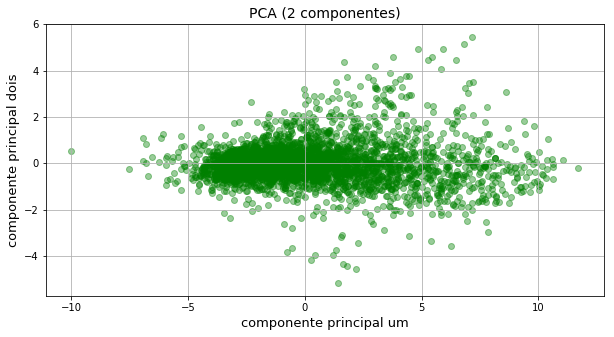

In [6]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], color="green", alpha=.4);

- vou trocar a dimensionalidade de cada gen, por uma dimesionalidade de 3x3, para assim ver o gen como uma imagem.

In [7]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3,1))
X_img = (X_img - np.mean(X_img))/np.mean(X_img)
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma matriz -----------------------------


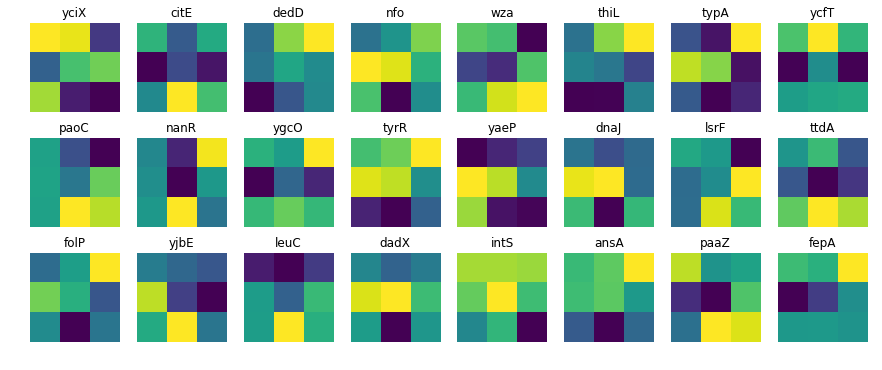

In [8]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma matriz -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i.reshape(3,3))
    plt.axis("off");
    p += 1

In [20]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        self.g_lpe = []
        self.d_lpe = []
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerD = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerG = Adam(lr=0.0004, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizerD, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(16, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.width*self.height*self.channels, activation="tanh"))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Dense(64, input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(16))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        self.g_lpe = []
        self.d_lpe = []
        for cnt in range(epochs):
            batches = self.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%20)==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %f[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
            self.g_lpe.append(g_l)
            self.d_lpe.append(d_l[0])

In [21]:
gan = GANs(width=3, height=3, channels=1, noise_input=100)

Compilando o gerador...
Compilando o discriminador...


In [22]:
print("-----------------------Estrutura da rede generativa-----------------------")
gan.G.summary()

-----------------------Estrutura da rede generativa-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                1616      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                544       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
d

In [23]:
print("-----------------------Estrutura da rede Discriminadora-----------------------")
gan.D.summary()

-----------------------Estrutura da rede Discriminadora-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 3, 3, 64)          128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 3, 3, 64)          0         
_________________________________________________________________
dense_18 (Dense)             (None, 3, 3, 32)          2080      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 3, 3, 32)          0         
_________________________________________________________________
dense_19 (Dense)             (None, 3, 3, 16)          528       
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_______________________________________________________________

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


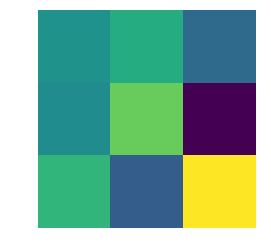

In [24]:
img_p = gan.G.predict(np.random.normal(0,1,(1,100)))
plt.imshow(img_p.reshape(3,3));
plt.axis("off");

In [25]:
t_i = time()
gan.train(X_img, epochs=1000,batch_size=16)
t_f = time()

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:[1/1000] batch:[20/254], [Discriminator::d_loss: 0.702381], [Generator::loss: 0.681192], 1.780804[sec]
epoch:[1/1000] batch:[40/254], [Discriminator::d_loss: 0.700962], [Generator::loss: 0.687125], 0.056552[sec]
epoch:[1/1000] batch:[60/254], [Discriminator::d_loss: 0.694331], [Generator::loss: 0.702485], 0.053356[sec]
epoch:[1/1000] batch:[80/254], [Discriminator::d_loss: 0.686578], [Generator::loss: 0.709466], 0.057175[sec]
epoch:[1/1000] batch:[100/254], [Discriminator::d_loss: 0.689837], [Generator::loss: 0.695648], 0.060906[sec]
epoch:[1/1000] batch:[120/254], [Discriminator::d_loss: 0.697413], [Generator::loss: 0.685309], 0.058168[sec]
epoch:[1/1000] batch:[140/254], [Discriminator::d_loss: 0.688057], [Generator::loss: 0.695266], 0.053518[sec]
epoch:[1/1000] batch:[160/254], [Discriminator::d_loss: 0.681807], [Generator::loss: 0.704267], 0.054838[sec]
epoch:[1/1000] batch:[180/254], [Discriminator::d_loss: 0.674443], [Generator::loss: 0.712303], 0.062891[sec]
epoch:[1/1000]

epoch:[7/1000] batch:[100/254], [Discriminator::d_loss: 0.692592], [Generator::loss: 0.696667], 0.063688[sec]
epoch:[7/1000] batch:[120/254], [Discriminator::d_loss: 0.695002], [Generator::loss: 0.690123], 0.054340[sec]
epoch:[7/1000] batch:[140/254], [Discriminator::d_loss: 0.694120], [Generator::loss: 0.689450], 0.056410[sec]
epoch:[7/1000] batch:[160/254], [Discriminator::d_loss: 0.694835], [Generator::loss: 0.691953], 0.052844[sec]
epoch:[7/1000] batch:[180/254], [Discriminator::d_loss: 0.692585], [Generator::loss: 0.693053], 0.065001[sec]
epoch:[7/1000] batch:[200/254], [Discriminator::d_loss: 0.694451], [Generator::loss: 0.689344], 0.054772[sec]
epoch:[7/1000] batch:[220/254], [Discriminator::d_loss: 0.693319], [Generator::loss: 0.692460], 0.054553[sec]
epoch:[7/1000] batch:[240/254], [Discriminator::d_loss: 0.692933], [Generator::loss: 0.692981], 0.054620[sec]
epoch:[8/1000] batch:[20/254], [Discriminator::d_loss: 0.693501], [Generator::loss: 0.693719], 0.059743[sec]
epoch:[8/10

epoch:[13/1000] batch:[160/254], [Discriminator::d_loss: 0.694271], [Generator::loss: 0.692474], 0.060950[sec]
epoch:[13/1000] batch:[180/254], [Discriminator::d_loss: 0.693371], [Generator::loss: 0.692890], 0.057182[sec]
epoch:[13/1000] batch:[200/254], [Discriminator::d_loss: 0.692753], [Generator::loss: 0.692412], 0.058749[sec]
epoch:[13/1000] batch:[220/254], [Discriminator::d_loss: 0.690771], [Generator::loss: 0.695819], 0.055416[sec]
epoch:[13/1000] batch:[240/254], [Discriminator::d_loss: 0.692571], [Generator::loss: 0.694566], 0.066242[sec]
epoch:[14/1000] batch:[20/254], [Discriminator::d_loss: 0.694611], [Generator::loss: 0.691330], 0.056258[sec]
epoch:[14/1000] batch:[40/254], [Discriminator::d_loss: 0.688483], [Generator::loss: 0.696293], 0.057070[sec]
epoch:[14/1000] batch:[60/254], [Discriminator::d_loss: 0.697425], [Generator::loss: 0.694422], 0.060074[sec]
epoch:[14/1000] batch:[80/254], [Discriminator::d_loss: 0.694100], [Generator::loss: 0.688069], 0.059543[sec]
epoch

epoch:[20/1000] batch:[20/254], [Discriminator::d_loss: 0.695120], [Generator::loss: 0.696360], 0.062090[sec]
epoch:[20/1000] batch:[40/254], [Discriminator::d_loss: 0.681288], [Generator::loss: 0.695987], 0.066699[sec]
epoch:[20/1000] batch:[60/254], [Discriminator::d_loss: 0.700344], [Generator::loss: 0.691991], 0.067363[sec]
epoch:[20/1000] batch:[80/254], [Discriminator::d_loss: 0.691919], [Generator::loss: 0.694766], 0.065847[sec]
epoch:[20/1000] batch:[100/254], [Discriminator::d_loss: 0.695443], [Generator::loss: 0.688279], 0.074998[sec]
epoch:[20/1000] batch:[120/254], [Discriminator::d_loss: 0.695289], [Generator::loss: 0.690719], 0.062753[sec]
epoch:[20/1000] batch:[140/254], [Discriminator::d_loss: 0.692006], [Generator::loss: 0.694095], 0.060449[sec]
epoch:[20/1000] batch:[160/254], [Discriminator::d_loss: 0.692384], [Generator::loss: 0.693181], 0.059702[sec]
epoch:[20/1000] batch:[180/254], [Discriminator::d_loss: 0.693873], [Generator::loss: 0.694556], 0.060105[sec]
epoch

epoch:[26/1000] batch:[100/254], [Discriminator::d_loss: 0.694204], [Generator::loss: 0.692288], 0.066397[sec]
epoch:[26/1000] batch:[120/254], [Discriminator::d_loss: 0.697367], [Generator::loss: 0.690624], 0.053821[sec]
epoch:[26/1000] batch:[140/254], [Discriminator::d_loss: 0.693876], [Generator::loss: 0.693519], 0.055798[sec]
epoch:[26/1000] batch:[160/254], [Discriminator::d_loss: 0.692393], [Generator::loss: 0.695327], 0.056005[sec]
epoch:[26/1000] batch:[180/254], [Discriminator::d_loss: 0.691855], [Generator::loss: 0.695588], 0.060570[sec]
epoch:[26/1000] batch:[200/254], [Discriminator::d_loss: 0.692674], [Generator::loss: 0.692027], 0.054537[sec]
epoch:[26/1000] batch:[220/254], [Discriminator::d_loss: 0.695640], [Generator::loss: 0.692027], 0.058979[sec]
epoch:[26/1000] batch:[240/254], [Discriminator::d_loss: 0.693226], [Generator::loss: 0.694453], 0.058558[sec]
epoch:[27/1000] batch:[20/254], [Discriminator::d_loss: 0.692488], [Generator::loss: 0.692248], 0.059798[sec]
ep

epoch:[32/1000] batch:[180/254], [Discriminator::d_loss: 0.694296], [Generator::loss: 0.692086], 0.061147[sec]
epoch:[32/1000] batch:[200/254], [Discriminator::d_loss: 0.693856], [Generator::loss: 0.689992], 0.056117[sec]
epoch:[32/1000] batch:[220/254], [Discriminator::d_loss: 0.690634], [Generator::loss: 0.693468], 0.052819[sec]
epoch:[32/1000] batch:[240/254], [Discriminator::d_loss: 0.690902], [Generator::loss: 0.695931], 0.055259[sec]
epoch:[33/1000] batch:[20/254], [Discriminator::d_loss: 0.695631], [Generator::loss: 0.695593], 0.061565[sec]
epoch:[33/1000] batch:[40/254], [Discriminator::d_loss: 0.681101], [Generator::loss: 0.695850], 0.055079[sec]
epoch:[33/1000] batch:[60/254], [Discriminator::d_loss: 0.701471], [Generator::loss: 0.687982], 0.054727[sec]
epoch:[33/1000] batch:[80/254], [Discriminator::d_loss: 0.692592], [Generator::loss: 0.696374], 0.053119[sec]
epoch:[33/1000] batch:[100/254], [Discriminator::d_loss: 0.690531], [Generator::loss: 0.693983], 0.061135[sec]
epoch

epoch:[39/1000] batch:[20/254], [Discriminator::d_loss: 0.696149], [Generator::loss: 0.689168], 0.064312[sec]
epoch:[39/1000] batch:[40/254], [Discriminator::d_loss: 0.686231], [Generator::loss: 0.695499], 0.052177[sec]
epoch:[39/1000] batch:[60/254], [Discriminator::d_loss: 0.691899], [Generator::loss: 0.695604], 0.060679[sec]
epoch:[39/1000] batch:[80/254], [Discriminator::d_loss: 0.693184], [Generator::loss: 0.695361], 0.055782[sec]
epoch:[39/1000] batch:[100/254], [Discriminator::d_loss: 0.693781], [Generator::loss: 0.692808], 0.059704[sec]
epoch:[39/1000] batch:[120/254], [Discriminator::d_loss: 0.694081], [Generator::loss: 0.693557], 0.061781[sec]
epoch:[39/1000] batch:[140/254], [Discriminator::d_loss: 0.693468], [Generator::loss: 0.692907], 0.056682[sec]
epoch:[39/1000] batch:[160/254], [Discriminator::d_loss: 0.693083], [Generator::loss: 0.692327], 0.055254[sec]
epoch:[39/1000] batch:[180/254], [Discriminator::d_loss: 0.696667], [Generator::loss: 0.691346], 0.058963[sec]
epoch

epoch:[45/1000] batch:[100/254], [Discriminator::d_loss: 0.690008], [Generator::loss: 0.698172], 0.061208[sec]
epoch:[45/1000] batch:[120/254], [Discriminator::d_loss: 0.693276], [Generator::loss: 0.695680], 0.053808[sec]
epoch:[45/1000] batch:[140/254], [Discriminator::d_loss: 0.691621], [Generator::loss: 0.692096], 0.054375[sec]
epoch:[45/1000] batch:[160/254], [Discriminator::d_loss: 0.694890], [Generator::loss: 0.693735], 0.052016[sec]
epoch:[45/1000] batch:[180/254], [Discriminator::d_loss: 0.692642], [Generator::loss: 0.693882], 0.060697[sec]
epoch:[45/1000] batch:[200/254], [Discriminator::d_loss: 0.694352], [Generator::loss: 0.688041], 0.061413[sec]
epoch:[45/1000] batch:[220/254], [Discriminator::d_loss: 0.696391], [Generator::loss: 0.689957], 0.053502[sec]
epoch:[45/1000] batch:[240/254], [Discriminator::d_loss: 0.693314], [Generator::loss: 0.695538], 0.056086[sec]
epoch:[46/1000] batch:[20/254], [Discriminator::d_loss: 0.691021], [Generator::loss: 0.696479], 0.057039[sec]
ep

epoch:[51/1000] batch:[180/254], [Discriminator::d_loss: 0.692971], [Generator::loss: 0.693572], 0.063226[sec]
epoch:[51/1000] batch:[200/254], [Discriminator::d_loss: 0.692705], [Generator::loss: 0.690594], 0.059294[sec]
epoch:[51/1000] batch:[220/254], [Discriminator::d_loss: 0.693734], [Generator::loss: 0.692161], 0.054579[sec]
epoch:[51/1000] batch:[240/254], [Discriminator::d_loss: 0.694366], [Generator::loss: 0.693520], 0.054072[sec]
epoch:[52/1000] batch:[20/254], [Discriminator::d_loss: 0.691426], [Generator::loss: 0.700015], 0.059019[sec]
epoch:[52/1000] batch:[40/254], [Discriminator::d_loss: 0.674829], [Generator::loss: 0.699068], 0.054477[sec]
epoch:[52/1000] batch:[60/254], [Discriminator::d_loss: 0.715014], [Generator::loss: 0.676574], 0.053133[sec]
epoch:[52/1000] batch:[80/254], [Discriminator::d_loss: 0.681331], [Generator::loss: 0.720645], 0.056503[sec]
epoch:[52/1000] batch:[100/254], [Discriminator::d_loss: 0.690990], [Generator::loss: 0.689093], 0.061525[sec]
epoch

epoch:[58/1000] batch:[20/254], [Discriminator::d_loss: 0.693044], [Generator::loss: 0.695271], 0.062925[sec]
epoch:[58/1000] batch:[40/254], [Discriminator::d_loss: 0.682463], [Generator::loss: 0.698487], 0.053606[sec]
epoch:[58/1000] batch:[60/254], [Discriminator::d_loss: 0.692143], [Generator::loss: 0.693754], 0.054586[sec]
epoch:[58/1000] batch:[80/254], [Discriminator::d_loss: 0.692243], [Generator::loss: 0.688553], 0.051888[sec]
epoch:[58/1000] batch:[100/254], [Discriminator::d_loss: 0.698295], [Generator::loss: 0.691890], 0.058470[sec]
epoch:[58/1000] batch:[120/254], [Discriminator::d_loss: 0.694640], [Generator::loss: 0.695238], 0.059624[sec]
epoch:[58/1000] batch:[140/254], [Discriminator::d_loss: 0.692244], [Generator::loss: 0.693181], 0.053405[sec]
epoch:[58/1000] batch:[160/254], [Discriminator::d_loss: 0.691779], [Generator::loss: 0.697700], 0.055959[sec]
epoch:[58/1000] batch:[180/254], [Discriminator::d_loss: 0.690772], [Generator::loss: 0.694288], 0.057464[sec]
epoch

epoch:[64/1000] batch:[100/254], [Discriminator::d_loss: 0.689864], [Generator::loss: 0.699277], 0.065968[sec]
epoch:[64/1000] batch:[120/254], [Discriminator::d_loss: 0.692445], [Generator::loss: 0.695404], 0.056835[sec]
epoch:[64/1000] batch:[140/254], [Discriminator::d_loss: 0.693297], [Generator::loss: 0.692443], 0.053370[sec]
epoch:[64/1000] batch:[160/254], [Discriminator::d_loss: 0.693621], [Generator::loss: 0.694691], 0.057151[sec]
epoch:[64/1000] batch:[180/254], [Discriminator::d_loss: 0.691549], [Generator::loss: 0.695374], 0.057423[sec]
epoch:[64/1000] batch:[200/254], [Discriminator::d_loss: 0.697442], [Generator::loss: 0.683538], 0.057618[sec]
epoch:[64/1000] batch:[220/254], [Discriminator::d_loss: 0.693143], [Generator::loss: 0.697188], 0.052700[sec]
epoch:[64/1000] batch:[240/254], [Discriminator::d_loss: 0.691894], [Generator::loss: 0.694517], 0.058200[sec]
epoch:[65/1000] batch:[20/254], [Discriminator::d_loss: 0.692773], [Generator::loss: 0.694878], 0.057025[sec]
ep

epoch:[70/1000] batch:[180/254], [Discriminator::d_loss: 0.693554], [Generator::loss: 0.693456], 0.080880[sec]
epoch:[70/1000] batch:[200/254], [Discriminator::d_loss: 0.693418], [Generator::loss: 0.691461], 0.087539[sec]
epoch:[70/1000] batch:[220/254], [Discriminator::d_loss: 0.693917], [Generator::loss: 0.691072], 0.061916[sec]
epoch:[70/1000] batch:[240/254], [Discriminator::d_loss: 0.693716], [Generator::loss: 0.693505], 0.068961[sec]
epoch:[71/1000] batch:[20/254], [Discriminator::d_loss: 0.693010], [Generator::loss: 0.698101], 0.060833[sec]
epoch:[71/1000] batch:[40/254], [Discriminator::d_loss: 0.681285], [Generator::loss: 0.694204], 0.066298[sec]
epoch:[71/1000] batch:[60/254], [Discriminator::d_loss: 0.700839], [Generator::loss: 0.688731], 0.066916[sec]
epoch:[71/1000] batch:[80/254], [Discriminator::d_loss: 0.689434], [Generator::loss: 0.698779], 0.061693[sec]
epoch:[71/1000] batch:[100/254], [Discriminator::d_loss: 0.689273], [Generator::loss: 0.698977], 0.066246[sec]
epoch

epoch:[77/1000] batch:[60/254], [Discriminator::d_loss: 0.700110], [Generator::loss: 0.694094], 0.053435[sec]
epoch:[77/1000] batch:[80/254], [Discriminator::d_loss: 0.704611], [Generator::loss: 0.678457], 0.052687[sec]
epoch:[77/1000] batch:[100/254], [Discriminator::d_loss: 0.686656], [Generator::loss: 0.704923], 0.051002[sec]
epoch:[77/1000] batch:[120/254], [Discriminator::d_loss: 0.694196], [Generator::loss: 0.692594], 0.063308[sec]
epoch:[77/1000] batch:[140/254], [Discriminator::d_loss: 0.693140], [Generator::loss: 0.689460], 0.055066[sec]
epoch:[77/1000] batch:[160/254], [Discriminator::d_loss: 0.697704], [Generator::loss: 0.691157], 0.051288[sec]
epoch:[77/1000] batch:[180/254], [Discriminator::d_loss: 0.692682], [Generator::loss: 0.694013], 0.054252[sec]
epoch:[77/1000] batch:[200/254], [Discriminator::d_loss: 0.693168], [Generator::loss: 0.693167], 0.053447[sec]
epoch:[77/1000] batch:[220/254], [Discriminator::d_loss: 0.692807], [Generator::loss: 0.693405], 0.063058[sec]
epo

epoch:[83/1000] batch:[120/254], [Discriminator::d_loss: 0.694044], [Generator::loss: 0.690685], 0.052892[sec]
epoch:[83/1000] batch:[140/254], [Discriminator::d_loss: 0.693321], [Generator::loss: 0.691089], 0.050977[sec]
epoch:[83/1000] batch:[160/254], [Discriminator::d_loss: 0.697437], [Generator::loss: 0.691339], 0.053711[sec]
epoch:[83/1000] batch:[180/254], [Discriminator::d_loss: 0.694398], [Generator::loss: 0.694127], 0.051682[sec]
epoch:[83/1000] batch:[200/254], [Discriminator::d_loss: 0.692096], [Generator::loss: 0.695359], 0.053985[sec]
epoch:[83/1000] batch:[220/254], [Discriminator::d_loss: 0.692124], [Generator::loss: 0.695302], 0.053693[sec]
epoch:[83/1000] batch:[240/254], [Discriminator::d_loss: 0.691617], [Generator::loss: 0.696441], 0.053830[sec]
epoch:[84/1000] batch:[20/254], [Discriminator::d_loss: 0.697340], [Generator::loss: 0.686634], 0.056729[sec]
epoch:[84/1000] batch:[40/254], [Discriminator::d_loss: 0.694533], [Generator::loss: 0.685588], 0.067008[sec]
epo

epoch:[89/1000] batch:[180/254], [Discriminator::d_loss: 0.694573], [Generator::loss: 0.692493], 0.053775[sec]
epoch:[89/1000] batch:[200/254], [Discriminator::d_loss: 0.693929], [Generator::loss: 0.692507], 0.053116[sec]
epoch:[89/1000] batch:[220/254], [Discriminator::d_loss: 0.693698], [Generator::loss: 0.692985], 0.052076[sec]
epoch:[89/1000] batch:[240/254], [Discriminator::d_loss: 0.693856], [Generator::loss: 0.693724], 0.054278[sec]
epoch:[90/1000] batch:[20/254], [Discriminator::d_loss: 0.695598], [Generator::loss: 0.700702], 0.053360[sec]
epoch:[90/1000] batch:[40/254], [Discriminator::d_loss: 0.680351], [Generator::loss: 0.681910], 0.056920[sec]
epoch:[90/1000] batch:[60/254], [Discriminator::d_loss: 0.695803], [Generator::loss: 0.698993], 0.053593[sec]
epoch:[90/1000] batch:[80/254], [Discriminator::d_loss: 0.693226], [Generator::loss: 0.695498], 0.051653[sec]
epoch:[90/1000] batch:[100/254], [Discriminator::d_loss: 0.693310], [Generator::loss: 0.688937], 0.053163[sec]
epoch

epoch:[96/1000] batch:[60/254], [Discriminator::d_loss: 0.701014], [Generator::loss: 0.685953], 0.053776[sec]
epoch:[96/1000] batch:[80/254], [Discriminator::d_loss: 0.688173], [Generator::loss: 0.701319], 0.053361[sec]
epoch:[96/1000] batch:[100/254], [Discriminator::d_loss: 0.691341], [Generator::loss: 0.689978], 0.053326[sec]
epoch:[96/1000] batch:[120/254], [Discriminator::d_loss: 0.696009], [Generator::loss: 0.691163], 0.052505[sec]
epoch:[96/1000] batch:[140/254], [Discriminator::d_loss: 0.694693], [Generator::loss: 0.693158], 0.054028[sec]
epoch:[96/1000] batch:[160/254], [Discriminator::d_loss: 0.693832], [Generator::loss: 0.695006], 0.053147[sec]
epoch:[96/1000] batch:[180/254], [Discriminator::d_loss: 0.694740], [Generator::loss: 0.693617], 0.052278[sec]
epoch:[96/1000] batch:[200/254], [Discriminator::d_loss: 0.695617], [Generator::loss: 0.690373], 0.054127[sec]
epoch:[96/1000] batch:[220/254], [Discriminator::d_loss: 0.688907], [Generator::loss: 0.696199], 0.054022[sec]
epo

epoch:[102/1000] batch:[100/254], [Discriminator::d_loss: 0.693624], [Generator::loss: 0.689581], 0.056170[sec]
epoch:[102/1000] batch:[120/254], [Discriminator::d_loss: 0.697174], [Generator::loss: 0.689964], 0.054100[sec]
epoch:[102/1000] batch:[140/254], [Discriminator::d_loss: 0.693984], [Generator::loss: 0.693911], 0.052557[sec]
epoch:[102/1000] batch:[160/254], [Discriminator::d_loss: 0.692057], [Generator::loss: 0.697252], 0.052609[sec]
epoch:[102/1000] batch:[180/254], [Discriminator::d_loss: 0.691012], [Generator::loss: 0.697158], 0.056614[sec]
epoch:[102/1000] batch:[200/254], [Discriminator::d_loss: 0.693672], [Generator::loss: 0.689972], 0.054452[sec]
epoch:[102/1000] batch:[220/254], [Discriminator::d_loss: 0.697975], [Generator::loss: 0.687910], 0.052711[sec]
epoch:[102/1000] batch:[240/254], [Discriminator::d_loss: 0.695999], [Generator::loss: 0.691200], 0.052174[sec]
epoch:[103/1000] batch:[20/254], [Discriminator::d_loss: 0.685890], [Generator::loss: 0.698516], 0.05426

epoch:[108/1000] batch:[180/254], [Discriminator::d_loss: 0.691938], [Generator::loss: 0.695216], 0.053445[sec]
epoch:[108/1000] batch:[200/254], [Discriminator::d_loss: 0.694233], [Generator::loss: 0.689833], 0.053500[sec]
epoch:[108/1000] batch:[220/254], [Discriminator::d_loss: 0.696044], [Generator::loss: 0.687866], 0.053426[sec]
epoch:[108/1000] batch:[240/254], [Discriminator::d_loss: 0.694595], [Generator::loss: 0.691604], 0.052706[sec]
epoch:[109/1000] batch:[20/254], [Discriminator::d_loss: 0.689598], [Generator::loss: 0.697123], 0.053433[sec]
epoch:[109/1000] batch:[40/254], [Discriminator::d_loss: 0.688859], [Generator::loss: 0.696393], 0.052522[sec]
epoch:[109/1000] batch:[60/254], [Discriminator::d_loss: 0.695070], [Generator::loss: 0.691098], 0.052846[sec]
epoch:[109/1000] batch:[80/254], [Discriminator::d_loss: 0.696653], [Generator::loss: 0.687425], 0.052914[sec]
epoch:[109/1000] batch:[100/254], [Discriminator::d_loss: 0.692806], [Generator::loss: 0.697891], 0.054350[s

epoch:[115/1000] batch:[20/254], [Discriminator::d_loss: 0.693057], [Generator::loss: 0.692916], 0.053388[sec]
epoch:[115/1000] batch:[40/254], [Discriminator::d_loss: 0.686708], [Generator::loss: 0.694521], 0.051994[sec]
epoch:[115/1000] batch:[60/254], [Discriminator::d_loss: 0.698206], [Generator::loss: 0.688595], 0.050878[sec]
epoch:[115/1000] batch:[80/254], [Discriminator::d_loss: 0.696519], [Generator::loss: 0.691139], 0.068306[sec]
epoch:[115/1000] batch:[100/254], [Discriminator::d_loss: 0.692406], [Generator::loss: 0.695352], 0.054235[sec]
epoch:[115/1000] batch:[120/254], [Discriminator::d_loss: 0.691367], [Generator::loss: 0.692933], 0.051426[sec]
epoch:[115/1000] batch:[140/254], [Discriminator::d_loss: 0.689913], [Generator::loss: 0.693853], 0.057038[sec]
epoch:[115/1000] batch:[160/254], [Discriminator::d_loss: 0.694081], [Generator::loss: 0.696283], 0.053982[sec]
epoch:[115/1000] batch:[180/254], [Discriminator::d_loss: 0.691478], [Generator::loss: 0.697409], 0.053164[s

epoch:[121/1000] batch:[100/254], [Discriminator::d_loss: 0.695451], [Generator::loss: 0.690780], 0.053974[sec]
epoch:[121/1000] batch:[120/254], [Discriminator::d_loss: 0.698285], [Generator::loss: 0.691097], 0.052405[sec]
epoch:[121/1000] batch:[140/254], [Discriminator::d_loss: 0.693811], [Generator::loss: 0.694600], 0.053555[sec]
epoch:[121/1000] batch:[160/254], [Discriminator::d_loss: 0.691978], [Generator::loss: 0.698676], 0.052853[sec]
epoch:[121/1000] batch:[180/254], [Discriminator::d_loss: 0.691410], [Generator::loss: 0.697208], 0.054623[sec]
epoch:[121/1000] batch:[200/254], [Discriminator::d_loss: 0.697861], [Generator::loss: 0.692309], 0.054434[sec]
epoch:[121/1000] batch:[220/254], [Discriminator::d_loss: 0.693958], [Generator::loss: 0.691012], 0.052692[sec]
epoch:[121/1000] batch:[240/254], [Discriminator::d_loss: 0.691447], [Generator::loss: 0.693695], 0.052709[sec]
epoch:[122/1000] batch:[20/254], [Discriminator::d_loss: 0.690857], [Generator::loss: 0.694270], 0.05396

epoch:[127/1000] batch:[180/254], [Discriminator::d_loss: 0.693702], [Generator::loss: 0.693054], 0.053180[sec]
epoch:[127/1000] batch:[200/254], [Discriminator::d_loss: 0.693852], [Generator::loss: 0.692500], 0.054123[sec]
epoch:[127/1000] batch:[220/254], [Discriminator::d_loss: 0.694457], [Generator::loss: 0.692766], 0.052523[sec]
epoch:[127/1000] batch:[240/254], [Discriminator::d_loss: 0.693326], [Generator::loss: 0.694729], 0.052483[sec]
epoch:[128/1000] batch:[20/254], [Discriminator::d_loss: 0.698589], [Generator::loss: 0.694350], 0.054167[sec]
epoch:[128/1000] batch:[40/254], [Discriminator::d_loss: 0.687306], [Generator::loss: 0.695378], 0.052470[sec]
epoch:[128/1000] batch:[60/254], [Discriminator::d_loss: 0.692930], [Generator::loss: 0.696321], 0.052867[sec]
epoch:[128/1000] batch:[80/254], [Discriminator::d_loss: 0.690986], [Generator::loss: 0.693510], 0.051947[sec]
epoch:[128/1000] batch:[100/254], [Discriminator::d_loss: 0.694553], [Generator::loss: 0.690704], 0.053395[s

epoch:[134/1000] batch:[20/254], [Discriminator::d_loss: 0.695585], [Generator::loss: 0.694560], 0.053455[sec]
epoch:[134/1000] batch:[40/254], [Discriminator::d_loss: 0.686895], [Generator::loss: 0.689893], 0.052778[sec]
epoch:[134/1000] batch:[60/254], [Discriminator::d_loss: 0.691593], [Generator::loss: 0.695567], 0.051147[sec]
epoch:[134/1000] batch:[80/254], [Discriminator::d_loss: 0.687838], [Generator::loss: 0.692911], 0.050847[sec]
epoch:[134/1000] batch:[100/254], [Discriminator::d_loss: 0.697317], [Generator::loss: 0.687171], 0.053069[sec]
epoch:[134/1000] batch:[120/254], [Discriminator::d_loss: 0.696960], [Generator::loss: 0.693629], 0.051622[sec]
epoch:[134/1000] batch:[140/254], [Discriminator::d_loss: 0.693500], [Generator::loss: 0.694701], 0.051101[sec]
epoch:[134/1000] batch:[160/254], [Discriminator::d_loss: 0.691649], [Generator::loss: 0.697927], 0.052793[sec]
epoch:[134/1000] batch:[180/254], [Discriminator::d_loss: 0.690051], [Generator::loss: 0.697510], 0.054245[s

epoch:[140/1000] batch:[120/254], [Discriminator::d_loss: 0.693219], [Generator::loss: 0.693323], 0.053207[sec]
epoch:[140/1000] batch:[140/254], [Discriminator::d_loss: 0.691999], [Generator::loss: 0.692660], 0.050989[sec]
epoch:[140/1000] batch:[160/254], [Discriminator::d_loss: 0.693378], [Generator::loss: 0.695092], 0.051608[sec]
epoch:[140/1000] batch:[180/254], [Discriminator::d_loss: 0.692310], [Generator::loss: 0.696536], 0.051818[sec]
epoch:[140/1000] batch:[200/254], [Discriminator::d_loss: 0.691400], [Generator::loss: 0.694332], 0.055070[sec]
epoch:[140/1000] batch:[220/254], [Discriminator::d_loss: 0.693313], [Generator::loss: 0.692736], 0.051532[sec]
epoch:[140/1000] batch:[240/254], [Discriminator::d_loss: 0.695105], [Generator::loss: 0.690568], 0.051883[sec]
epoch:[141/1000] batch:[20/254], [Discriminator::d_loss: 0.693835], [Generator::loss: 0.696314], 0.051816[sec]
epoch:[141/1000] batch:[40/254], [Discriminator::d_loss: 0.687869], [Generator::loss: 0.695932], 0.069839

epoch:[146/1000] batch:[180/254], [Discriminator::d_loss: 0.692938], [Generator::loss: 0.695407], 0.051837[sec]
epoch:[146/1000] batch:[200/254], [Discriminator::d_loss: 0.692234], [Generator::loss: 0.694786], 0.051091[sec]
epoch:[146/1000] batch:[220/254], [Discriminator::d_loss: 0.692141], [Generator::loss: 0.694784], 0.051707[sec]
epoch:[146/1000] batch:[240/254], [Discriminator::d_loss: 0.691302], [Generator::loss: 0.697285], 0.051014[sec]
epoch:[147/1000] batch:[20/254], [Discriminator::d_loss: 0.694365], [Generator::loss: 0.698994], 0.051183[sec]
epoch:[147/1000] batch:[40/254], [Discriminator::d_loss: 0.687831], [Generator::loss: 0.688925], 0.050817[sec]
epoch:[147/1000] batch:[60/254], [Discriminator::d_loss: 0.696736], [Generator::loss: 0.695663], 0.050725[sec]
epoch:[147/1000] batch:[80/254], [Discriminator::d_loss: 0.688909], [Generator::loss: 0.697423], 0.050841[sec]
epoch:[147/1000] batch:[100/254], [Discriminator::d_loss: 0.694783], [Generator::loss: 0.691409], 0.051953[s

epoch:[153/1000] batch:[20/254], [Discriminator::d_loss: 0.692914], [Generator::loss: 0.698065], 0.052640[sec]
epoch:[153/1000] batch:[40/254], [Discriminator::d_loss: 0.671114], [Generator::loss: 0.702232], 0.050842[sec]
epoch:[153/1000] batch:[60/254], [Discriminator::d_loss: 0.706889], [Generator::loss: 0.681187], 0.050812[sec]
epoch:[153/1000] batch:[80/254], [Discriminator::d_loss: 0.695378], [Generator::loss: 0.694139], 0.050675[sec]
epoch:[153/1000] batch:[100/254], [Discriminator::d_loss: 0.690972], [Generator::loss: 0.696026], 0.053644[sec]
epoch:[153/1000] batch:[120/254], [Discriminator::d_loss: 0.692195], [Generator::loss: 0.694863], 0.050882[sec]
epoch:[153/1000] batch:[140/254], [Discriminator::d_loss: 0.689231], [Generator::loss: 0.695527], 0.050948[sec]
epoch:[153/1000] batch:[160/254], [Discriminator::d_loss: 0.695162], [Generator::loss: 0.691723], 0.050344[sec]
epoch:[153/1000] batch:[180/254], [Discriminator::d_loss: 0.695306], [Generator::loss: 0.691290], 0.052015[s

epoch:[159/1000] batch:[100/254], [Discriminator::d_loss: 0.690510], [Generator::loss: 0.694609], 0.051874[sec]
epoch:[159/1000] batch:[120/254], [Discriminator::d_loss: 0.694764], [Generator::loss: 0.691192], 0.050864[sec]
epoch:[159/1000] batch:[140/254], [Discriminator::d_loss: 0.693674], [Generator::loss: 0.692478], 0.051328[sec]
epoch:[159/1000] batch:[160/254], [Discriminator::d_loss: 0.695403], [Generator::loss: 0.694305], 0.051352[sec]
epoch:[159/1000] batch:[180/254], [Discriminator::d_loss: 0.693435], [Generator::loss: 0.696374], 0.051943[sec]
epoch:[159/1000] batch:[200/254], [Discriminator::d_loss: 0.694139], [Generator::loss: 0.687893], 0.051507[sec]
epoch:[159/1000] batch:[220/254], [Discriminator::d_loss: 0.695725], [Generator::loss: 0.690483], 0.050992[sec]
epoch:[159/1000] batch:[240/254], [Discriminator::d_loss: 0.691270], [Generator::loss: 0.696787], 0.050977[sec]
epoch:[160/1000] batch:[20/254], [Discriminator::d_loss: 0.692938], [Generator::loss: 0.695114], 0.05200

epoch:[165/1000] batch:[180/254], [Discriminator::d_loss: 0.691847], [Generator::loss: 0.696482], 0.055002[sec]
epoch:[165/1000] batch:[200/254], [Discriminator::d_loss: 0.692854], [Generator::loss: 0.692064], 0.052366[sec]
epoch:[165/1000] batch:[220/254], [Discriminator::d_loss: 0.694881], [Generator::loss: 0.690619], 0.051978[sec]
epoch:[165/1000] batch:[240/254], [Discriminator::d_loss: 0.693014], [Generator::loss: 0.693916], 0.051981[sec]
epoch:[166/1000] batch:[20/254], [Discriminator::d_loss: 0.691334], [Generator::loss: 0.694460], 0.054339[sec]
epoch:[166/1000] batch:[40/254], [Discriminator::d_loss: 0.688670], [Generator::loss: 0.697598], 0.051977[sec]
epoch:[166/1000] batch:[60/254], [Discriminator::d_loss: 0.691795], [Generator::loss: 0.692884], 0.052133[sec]
epoch:[166/1000] batch:[80/254], [Discriminator::d_loss: 0.688917], [Generator::loss: 0.699121], 0.052686[sec]
epoch:[166/1000] batch:[100/254], [Discriminator::d_loss: 0.696222], [Generator::loss: 0.692125], 0.054538[s

epoch:[172/1000] batch:[40/254], [Discriminator::d_loss: 0.702533], [Generator::loss: 0.691283], 0.055107[sec]
epoch:[172/1000] batch:[60/254], [Discriminator::d_loss: 0.695440], [Generator::loss: 0.694607], 0.051871[sec]
epoch:[172/1000] batch:[80/254], [Discriminator::d_loss: 0.692865], [Generator::loss: 0.695033], 0.055150[sec]
epoch:[172/1000] batch:[100/254], [Discriminator::d_loss: 0.691512], [Generator::loss: 0.695420], 0.059031[sec]
epoch:[172/1000] batch:[120/254], [Discriminator::d_loss: 0.690799], [Generator::loss: 0.695839], 0.054453[sec]
epoch:[172/1000] batch:[140/254], [Discriminator::d_loss: 0.700206], [Generator::loss: 0.684417], 0.052555[sec]
epoch:[172/1000] batch:[160/254], [Discriminator::d_loss: 0.698104], [Generator::loss: 0.687391], 0.051229[sec]
epoch:[172/1000] batch:[180/254], [Discriminator::d_loss: 0.683821], [Generator::loss: 0.700749], 0.053154[sec]
epoch:[172/1000] batch:[200/254], [Discriminator::d_loss: 0.689316], [Generator::loss: 0.690487], 0.058866[

epoch:[178/1000] batch:[100/254], [Discriminator::d_loss: 0.693793], [Generator::loss: 0.692191], 0.058684[sec]
epoch:[178/1000] batch:[120/254], [Discriminator::d_loss: 0.696199], [Generator::loss: 0.691678], 0.051863[sec]
epoch:[178/1000] batch:[140/254], [Discriminator::d_loss: 0.693867], [Generator::loss: 0.693766], 0.051120[sec]
epoch:[178/1000] batch:[160/254], [Discriminator::d_loss: 0.694213], [Generator::loss: 0.694947], 0.051541[sec]
epoch:[178/1000] batch:[180/254], [Discriminator::d_loss: 0.692519], [Generator::loss: 0.695362], 0.060414[sec]
epoch:[178/1000] batch:[200/254], [Discriminator::d_loss: 0.693526], [Generator::loss: 0.692620], 0.051632[sec]
epoch:[178/1000] batch:[220/254], [Discriminator::d_loss: 0.693799], [Generator::loss: 0.691880], 0.051033[sec]
epoch:[178/1000] batch:[240/254], [Discriminator::d_loss: 0.693257], [Generator::loss: 0.693948], 0.055943[sec]
epoch:[179/1000] batch:[20/254], [Discriminator::d_loss: 0.692642], [Generator::loss: 0.697716], 0.05898

epoch:[184/1000] batch:[180/254], [Discriminator::d_loss: 0.693166], [Generator::loss: 0.692727], 0.051893[sec]
epoch:[184/1000] batch:[200/254], [Discriminator::d_loss: 0.693166], [Generator::loss: 0.692370], 0.051904[sec]
epoch:[184/1000] batch:[220/254], [Discriminator::d_loss: 0.693672], [Generator::loss: 0.692651], 0.052342[sec]
epoch:[184/1000] batch:[240/254], [Discriminator::d_loss: 0.693568], [Generator::loss: 0.693724], 0.051263[sec]
epoch:[185/1000] batch:[20/254], [Discriminator::d_loss: 0.694346], [Generator::loss: 0.696353], 0.052573[sec]
epoch:[185/1000] batch:[40/254], [Discriminator::d_loss: 0.682855], [Generator::loss: 0.696048], 0.051238[sec]
epoch:[185/1000] batch:[60/254], [Discriminator::d_loss: 0.693118], [Generator::loss: 0.693998], 0.052570[sec]
epoch:[185/1000] batch:[80/254], [Discriminator::d_loss: 0.688986], [Generator::loss: 0.693612], 0.054571[sec]
epoch:[185/1000] batch:[100/254], [Discriminator::d_loss: 0.694704], [Generator::loss: 0.690026], 0.052692[s

epoch:[191/1000] batch:[20/254], [Discriminator::d_loss: 0.693423], [Generator::loss: 0.692848], 0.055422[sec]
epoch:[191/1000] batch:[40/254], [Discriminator::d_loss: 0.689448], [Generator::loss: 0.695289], 0.056104[sec]
epoch:[191/1000] batch:[60/254], [Discriminator::d_loss: 0.699942], [Generator::loss: 0.688336], 0.054943[sec]
epoch:[191/1000] batch:[80/254], [Discriminator::d_loss: 0.694350], [Generator::loss: 0.692936], 0.056484[sec]
epoch:[191/1000] batch:[100/254], [Discriminator::d_loss: 0.690333], [Generator::loss: 0.696572], 0.057669[sec]
epoch:[191/1000] batch:[120/254], [Discriminator::d_loss: 0.691788], [Generator::loss: 0.696400], 0.054946[sec]
epoch:[191/1000] batch:[140/254], [Discriminator::d_loss: 0.691693], [Generator::loss: 0.690578], 0.054494[sec]
epoch:[191/1000] batch:[160/254], [Discriminator::d_loss: 0.697296], [Generator::loss: 0.691125], 0.055148[sec]
epoch:[191/1000] batch:[180/254], [Discriminator::d_loss: 0.692026], [Generator::loss: 0.696035], 0.059868[s

epoch:[197/1000] batch:[100/254], [Discriminator::d_loss: 0.693059], [Generator::loss: 0.692704], 0.055976[sec]
epoch:[197/1000] batch:[120/254], [Discriminator::d_loss: 0.695916], [Generator::loss: 0.688330], 0.052187[sec]
epoch:[197/1000] batch:[140/254], [Discriminator::d_loss: 0.695735], [Generator::loss: 0.689083], 0.050818[sec]
epoch:[197/1000] batch:[160/254], [Discriminator::d_loss: 0.692478], [Generator::loss: 0.694097], 0.051134[sec]
epoch:[197/1000] batch:[180/254], [Discriminator::d_loss: 0.691108], [Generator::loss: 0.694033], 0.052268[sec]
epoch:[197/1000] batch:[200/254], [Discriminator::d_loss: 0.694582], [Generator::loss: 0.690560], 0.051292[sec]
epoch:[197/1000] batch:[220/254], [Discriminator::d_loss: 0.696176], [Generator::loss: 0.691779], 0.052513[sec]
epoch:[197/1000] batch:[240/254], [Discriminator::d_loss: 0.694368], [Generator::loss: 0.693996], 0.062747[sec]
epoch:[198/1000] batch:[20/254], [Discriminator::d_loss: 0.689771], [Generator::loss: 0.702084], 0.05312

epoch:[203/1000] batch:[180/254], [Discriminator::d_loss: 0.692550], [Generator::loss: 0.697058], 0.055681[sec]
epoch:[203/1000] batch:[200/254], [Discriminator::d_loss: 0.692124], [Generator::loss: 0.694598], 0.051618[sec]
epoch:[203/1000] batch:[220/254], [Discriminator::d_loss: 0.694354], [Generator::loss: 0.692102], 0.051649[sec]
epoch:[203/1000] batch:[240/254], [Discriminator::d_loss: 0.693002], [Generator::loss: 0.693880], 0.050969[sec]
epoch:[204/1000] batch:[20/254], [Discriminator::d_loss: 0.695834], [Generator::loss: 0.690746], 0.053000[sec]
epoch:[204/1000] batch:[40/254], [Discriminator::d_loss: 0.695919], [Generator::loss: 0.689595], 0.051259[sec]
epoch:[204/1000] batch:[60/254], [Discriminator::d_loss: 0.689828], [Generator::loss: 0.695159], 0.051917[sec]
epoch:[204/1000] batch:[80/254], [Discriminator::d_loss: 0.694642], [Generator::loss: 0.689946], 0.051028[sec]
epoch:[204/1000] batch:[100/254], [Discriminator::d_loss: 0.696304], [Generator::loss: 0.691392], 0.059174[s

epoch:[210/1000] batch:[20/254], [Discriminator::d_loss: 0.690938], [Generator::loss: 0.697975], 0.051946[sec]
epoch:[210/1000] batch:[40/254], [Discriminator::d_loss: 0.682031], [Generator::loss: 0.702097], 0.050876[sec]
epoch:[210/1000] batch:[60/254], [Discriminator::d_loss: 0.705283], [Generator::loss: 0.677632], 0.051172[sec]
epoch:[210/1000] batch:[80/254], [Discriminator::d_loss: 0.694767], [Generator::loss: 0.690593], 0.051333[sec]
epoch:[210/1000] batch:[100/254], [Discriminator::d_loss: 0.689178], [Generator::loss: 0.698223], 0.051828[sec]
epoch:[210/1000] batch:[120/254], [Discriminator::d_loss: 0.693632], [Generator::loss: 0.693525], 0.051462[sec]
epoch:[210/1000] batch:[140/254], [Discriminator::d_loss: 0.693871], [Generator::loss: 0.693169], 0.066103[sec]
epoch:[210/1000] batch:[160/254], [Discriminator::d_loss: 0.694827], [Generator::loss: 0.692621], 0.065891[sec]
epoch:[210/1000] batch:[180/254], [Discriminator::d_loss: 0.694080], [Generator::loss: 0.690353], 0.053157[s

epoch:[216/1000] batch:[100/254], [Discriminator::d_loss: 0.689763], [Generator::loss: 0.696105], 0.053629[sec]
epoch:[216/1000] batch:[120/254], [Discriminator::d_loss: 0.693177], [Generator::loss: 0.692660], 0.065869[sec]
epoch:[216/1000] batch:[140/254], [Discriminator::d_loss: 0.693488], [Generator::loss: 0.692566], 0.051204[sec]
epoch:[216/1000] batch:[160/254], [Discriminator::d_loss: 0.695246], [Generator::loss: 0.694212], 0.050948[sec]
epoch:[216/1000] batch:[180/254], [Discriminator::d_loss: 0.693642], [Generator::loss: 0.694845], 0.051829[sec]
epoch:[216/1000] batch:[200/254], [Discriminator::d_loss: 0.695582], [Generator::loss: 0.689516], 0.050963[sec]
epoch:[216/1000] batch:[220/254], [Discriminator::d_loss: 0.690859], [Generator::loss: 0.696072], 0.051092[sec]
epoch:[216/1000] batch:[240/254], [Discriminator::d_loss: 0.691469], [Generator::loss: 0.693432], 0.050950[sec]
epoch:[217/1000] batch:[20/254], [Discriminator::d_loss: 0.693991], [Generator::loss: 0.695278], 0.05158

epoch:[222/1000] batch:[180/254], [Discriminator::d_loss: 0.692686], [Generator::loss: 0.694710], 0.052596[sec]
epoch:[222/1000] batch:[200/254], [Discriminator::d_loss: 0.693063], [Generator::loss: 0.692318], 0.051250[sec]
epoch:[222/1000] batch:[220/254], [Discriminator::d_loss: 0.693616], [Generator::loss: 0.691408], 0.056315[sec]
epoch:[222/1000] batch:[240/254], [Discriminator::d_loss: 0.692977], [Generator::loss: 0.691885], 0.052643[sec]
epoch:[223/1000] batch:[20/254], [Discriminator::d_loss: 0.693411], [Generator::loss: 0.696307], 0.066983[sec]
epoch:[223/1000] batch:[40/254], [Discriminator::d_loss: 0.688094], [Generator::loss: 0.695619], 0.051953[sec]
epoch:[223/1000] batch:[60/254], [Discriminator::d_loss: 0.693232], [Generator::loss: 0.692564], 0.051040[sec]
epoch:[223/1000] batch:[80/254], [Discriminator::d_loss: 0.690607], [Generator::loss: 0.695168], 0.063995[sec]
epoch:[223/1000] batch:[100/254], [Discriminator::d_loss: 0.694387], [Generator::loss: 0.696823], 0.052804[s

epoch:[228/1000] batch:[220/254], [Discriminator::d_loss: 0.692746], [Generator::loss: 0.693231], 0.055398[sec]
epoch:[228/1000] batch:[240/254], [Discriminator::d_loss: 0.692825], [Generator::loss: 0.694515], 0.054017[sec]
epoch:[229/1000] batch:[20/254], [Discriminator::d_loss: 0.692725], [Generator::loss: 0.694656], 0.053502[sec]
epoch:[229/1000] batch:[40/254], [Discriminator::d_loss: 0.685499], [Generator::loss: 0.702187], 0.052289[sec]
epoch:[229/1000] batch:[60/254], [Discriminator::d_loss: 0.696654], [Generator::loss: 0.692179], 0.053391[sec]
epoch:[229/1000] batch:[80/254], [Discriminator::d_loss: 0.695385], [Generator::loss: 0.688577], 0.052464[sec]
epoch:[229/1000] batch:[100/254], [Discriminator::d_loss: 0.691853], [Generator::loss: 0.693108], 0.052731[sec]
epoch:[229/1000] batch:[120/254], [Discriminator::d_loss: 0.693730], [Generator::loss: 0.693873], 0.052127[sec]
epoch:[229/1000] batch:[140/254], [Discriminator::d_loss: 0.692504], [Generator::loss: 0.693182], 0.054393[s

epoch:[235/1000] batch:[60/254], [Discriminator::d_loss: 0.692327], [Generator::loss: 0.690915], 0.054403[sec]
epoch:[235/1000] batch:[80/254], [Discriminator::d_loss: 0.691707], [Generator::loss: 0.694496], 0.052219[sec]
epoch:[235/1000] batch:[100/254], [Discriminator::d_loss: 0.692981], [Generator::loss: 0.692256], 0.054445[sec]
epoch:[235/1000] batch:[120/254], [Discriminator::d_loss: 0.694453], [Generator::loss: 0.693283], 0.052849[sec]
epoch:[235/1000] batch:[140/254], [Discriminator::d_loss: 0.693923], [Generator::loss: 0.693837], 0.054349[sec]
epoch:[235/1000] batch:[160/254], [Discriminator::d_loss: 0.694104], [Generator::loss: 0.692940], 0.053454[sec]
epoch:[235/1000] batch:[180/254], [Discriminator::d_loss: 0.694157], [Generator::loss: 0.692671], 0.052709[sec]
epoch:[235/1000] batch:[200/254], [Discriminator::d_loss: 0.689881], [Generator::loss: 0.694495], 0.052796[sec]
epoch:[235/1000] batch:[220/254], [Discriminator::d_loss: 0.690152], [Generator::loss: 0.692330], 0.053499

epoch:[241/1000] batch:[140/254], [Discriminator::d_loss: 0.693092], [Generator::loss: 0.692666], 0.054557[sec]
epoch:[241/1000] batch:[160/254], [Discriminator::d_loss: 0.694259], [Generator::loss: 0.692347], 0.053016[sec]
epoch:[241/1000] batch:[180/254], [Discriminator::d_loss: 0.692913], [Generator::loss: 0.693402], 0.051715[sec]
epoch:[241/1000] batch:[200/254], [Discriminator::d_loss: 0.685072], [Generator::loss: 0.701227], 0.052243[sec]
epoch:[241/1000] batch:[220/254], [Discriminator::d_loss: 0.694924], [Generator::loss: 0.690605], 0.053513[sec]
epoch:[241/1000] batch:[240/254], [Discriminator::d_loss: 0.696616], [Generator::loss: 0.691764], 0.055228[sec]
epoch:[242/1000] batch:[20/254], [Discriminator::d_loss: 0.694503], [Generator::loss: 0.697484], 0.052929[sec]
epoch:[242/1000] batch:[40/254], [Discriminator::d_loss: 0.681956], [Generator::loss: 0.696695], 0.052267[sec]
epoch:[242/1000] batch:[60/254], [Discriminator::d_loss: 0.699946], [Generator::loss: 0.690532], 0.053485[

epoch:[247/1000] batch:[180/254], [Discriminator::d_loss: 0.692546], [Generator::loss: 0.693787], 0.055563[sec]
epoch:[247/1000] batch:[200/254], [Discriminator::d_loss: 0.692618], [Generator::loss: 0.694229], 0.054985[sec]
epoch:[247/1000] batch:[220/254], [Discriminator::d_loss: 0.692540], [Generator::loss: 0.694090], 0.054476[sec]
epoch:[247/1000] batch:[240/254], [Discriminator::d_loss: 0.693628], [Generator::loss: 0.692634], 0.053417[sec]
epoch:[248/1000] batch:[20/254], [Discriminator::d_loss: 0.694553], [Generator::loss: 0.695208], 0.052548[sec]
epoch:[248/1000] batch:[40/254], [Discriminator::d_loss: 0.685400], [Generator::loss: 0.697596], 0.051625[sec]
epoch:[248/1000] batch:[60/254], [Discriminator::d_loss: 0.695343], [Generator::loss: 0.695021], 0.052847[sec]
epoch:[248/1000] batch:[80/254], [Discriminator::d_loss: 0.691107], [Generator::loss: 0.694173], 0.052316[sec]
epoch:[248/1000] batch:[100/254], [Discriminator::d_loss: 0.692225], [Generator::loss: 0.691529], 0.052636[s

epoch:[254/1000] batch:[20/254], [Discriminator::d_loss: 0.693934], [Generator::loss: 0.694806], 0.053803[sec]
epoch:[254/1000] batch:[40/254], [Discriminator::d_loss: 0.685718], [Generator::loss: 0.698254], 0.052027[sec]
epoch:[254/1000] batch:[60/254], [Discriminator::d_loss: 0.697615], [Generator::loss: 0.690871], 0.051989[sec]
epoch:[254/1000] batch:[80/254], [Discriminator::d_loss: 0.691412], [Generator::loss: 0.694462], 0.051893[sec]
epoch:[254/1000] batch:[100/254], [Discriminator::d_loss: 0.687167], [Generator::loss: 0.696821], 0.055772[sec]
epoch:[254/1000] batch:[120/254], [Discriminator::d_loss: 0.692780], [Generator::loss: 0.692879], 0.056847[sec]
epoch:[254/1000] batch:[140/254], [Discriminator::d_loss: 0.693636], [Generator::loss: 0.691841], 0.067769[sec]
epoch:[254/1000] batch:[160/254], [Discriminator::d_loss: 0.696229], [Generator::loss: 0.691830], 0.054292[sec]
epoch:[254/1000] batch:[180/254], [Discriminator::d_loss: 0.694866], [Generator::loss: 0.692331], 0.055732[s

epoch:[260/1000] batch:[60/254], [Discriminator::d_loss: 0.694278], [Generator::loss: 0.694548], 0.063394[sec]
epoch:[260/1000] batch:[80/254], [Discriminator::d_loss: 0.691800], [Generator::loss: 0.691691], 0.055720[sec]
epoch:[260/1000] batch:[100/254], [Discriminator::d_loss: 0.693335], [Generator::loss: 0.690978], 0.052667[sec]
epoch:[260/1000] batch:[120/254], [Discriminator::d_loss: 0.695197], [Generator::loss: 0.691569], 0.055936[sec]
epoch:[260/1000] batch:[140/254], [Discriminator::d_loss: 0.692469], [Generator::loss: 0.692755], 0.056933[sec]
epoch:[260/1000] batch:[160/254], [Discriminator::d_loss: 0.693709], [Generator::loss: 0.694286], 0.058712[sec]
epoch:[260/1000] batch:[180/254], [Discriminator::d_loss: 0.692119], [Generator::loss: 0.694624], 0.054972[sec]
epoch:[260/1000] batch:[200/254], [Discriminator::d_loss: 0.693798], [Generator::loss: 0.692444], 0.052205[sec]
epoch:[260/1000] batch:[220/254], [Discriminator::d_loss: 0.694374], [Generator::loss: 0.691220], 0.083341

epoch:[266/1000] batch:[100/254], [Discriminator::d_loss: 0.692479], [Generator::loss: 0.693954], 0.055898[sec]
epoch:[266/1000] batch:[120/254], [Discriminator::d_loss: 0.692010], [Generator::loss: 0.693386], 0.051412[sec]
epoch:[266/1000] batch:[140/254], [Discriminator::d_loss: 0.693760], [Generator::loss: 0.693175], 0.051342[sec]
epoch:[266/1000] batch:[160/254], [Discriminator::d_loss: 0.692747], [Generator::loss: 0.693300], 0.053350[sec]
epoch:[266/1000] batch:[180/254], [Discriminator::d_loss: 0.693870], [Generator::loss: 0.690315], 0.053320[sec]
epoch:[266/1000] batch:[200/254], [Discriminator::d_loss: 0.692630], [Generator::loss: 0.693097], 0.052029[sec]
epoch:[266/1000] batch:[220/254], [Discriminator::d_loss: 0.690373], [Generator::loss: 0.694391], 0.051808[sec]
epoch:[266/1000] batch:[240/254], [Discriminator::d_loss: 0.694137], [Generator::loss: 0.693827], 0.052155[sec]
epoch:[267/1000] batch:[20/254], [Discriminator::d_loss: 0.694242], [Generator::loss: 0.695164], 0.05276

epoch:[272/1000] batch:[180/254], [Discriminator::d_loss: 0.697948], [Generator::loss: 0.683641], 0.065207[sec]
epoch:[272/1000] batch:[200/254], [Discriminator::d_loss: 0.688150], [Generator::loss: 0.700002], 0.051626[sec]
epoch:[272/1000] batch:[220/254], [Discriminator::d_loss: 0.690057], [Generator::loss: 0.695746], 0.051233[sec]
epoch:[272/1000] batch:[240/254], [Discriminator::d_loss: 0.693513], [Generator::loss: 0.692482], 0.051333[sec]
epoch:[273/1000] batch:[20/254], [Discriminator::d_loss: 0.694432], [Generator::loss: 0.695604], 0.054408[sec]
epoch:[273/1000] batch:[40/254], [Discriminator::d_loss: 0.686935], [Generator::loss: 0.695351], 0.052052[sec]
epoch:[273/1000] batch:[60/254], [Discriminator::d_loss: 0.701864], [Generator::loss: 0.688164], 0.051784[sec]
epoch:[273/1000] batch:[80/254], [Discriminator::d_loss: 0.690257], [Generator::loss: 0.696506], 0.054959[sec]
epoch:[273/1000] batch:[100/254], [Discriminator::d_loss: 0.691832], [Generator::loss: 0.694088], 0.057049[s

epoch:[279/1000] batch:[20/254], [Discriminator::d_loss: 0.695161], [Generator::loss: 0.694179], 0.052333[sec]
epoch:[279/1000] batch:[40/254], [Discriminator::d_loss: 0.691781], [Generator::loss: 0.695036], 0.050947[sec]
epoch:[279/1000] batch:[60/254], [Discriminator::d_loss: 0.690226], [Generator::loss: 0.694851], 0.050848[sec]
epoch:[279/1000] batch:[80/254], [Discriminator::d_loss: 0.694483], [Generator::loss: 0.692974], 0.050681[sec]
epoch:[279/1000] batch:[100/254], [Discriminator::d_loss: 0.694988], [Generator::loss: 0.691714], 0.052699[sec]
epoch:[279/1000] batch:[120/254], [Discriminator::d_loss: 0.694602], [Generator::loss: 0.692241], 0.054943[sec]
epoch:[279/1000] batch:[140/254], [Discriminator::d_loss: 0.694138], [Generator::loss: 0.692253], 0.051506[sec]
epoch:[279/1000] batch:[160/254], [Discriminator::d_loss: 0.692625], [Generator::loss: 0.693546], 0.051101[sec]
epoch:[279/1000] batch:[180/254], [Discriminator::d_loss: 0.692180], [Generator::loss: 0.693634], 0.051719[s

epoch:[285/1000] batch:[100/254], [Discriminator::d_loss: 0.693493], [Generator::loss: 0.690516], 0.052023[sec]
epoch:[285/1000] batch:[120/254], [Discriminator::d_loss: 0.693256], [Generator::loss: 0.692147], 0.058949[sec]
epoch:[285/1000] batch:[140/254], [Discriminator::d_loss: 0.691628], [Generator::loss: 0.693855], 0.053872[sec]
epoch:[285/1000] batch:[160/254], [Discriminator::d_loss: 0.693044], [Generator::loss: 0.694964], 0.050781[sec]
epoch:[285/1000] batch:[180/254], [Discriminator::d_loss: 0.692363], [Generator::loss: 0.694959], 0.060066[sec]
epoch:[285/1000] batch:[200/254], [Discriminator::d_loss: 0.692264], [Generator::loss: 0.695699], 0.053612[sec]
epoch:[285/1000] batch:[220/254], [Discriminator::d_loss: 0.693676], [Generator::loss: 0.693116], 0.052133[sec]
epoch:[285/1000] batch:[240/254], [Discriminator::d_loss: 0.692830], [Generator::loss: 0.695127], 0.051184[sec]
epoch:[286/1000] batch:[20/254], [Discriminator::d_loss: 0.692382], [Generator::loss: 0.701739], 0.05172

epoch:[291/1000] batch:[180/254], [Discriminator::d_loss: 0.694103], [Generator::loss: 0.693628], 0.053059[sec]
epoch:[291/1000] batch:[200/254], [Discriminator::d_loss: 0.692840], [Generator::loss: 0.694041], 0.053975[sec]
epoch:[291/1000] batch:[220/254], [Discriminator::d_loss: 0.692860], [Generator::loss: 0.693598], 0.052273[sec]
epoch:[291/1000] batch:[240/254], [Discriminator::d_loss: 0.692508], [Generator::loss: 0.694449], 0.052486[sec]
epoch:[292/1000] batch:[20/254], [Discriminator::d_loss: 0.693772], [Generator::loss: 0.697366], 0.052663[sec]
epoch:[292/1000] batch:[40/254], [Discriminator::d_loss: 0.681706], [Generator::loss: 0.699197], 0.052665[sec]
epoch:[292/1000] batch:[60/254], [Discriminator::d_loss: 0.698988], [Generator::loss: 0.688797], 0.052621[sec]
epoch:[292/1000] batch:[80/254], [Discriminator::d_loss: 0.689954], [Generator::loss: 0.697904], 0.052479[sec]
epoch:[292/1000] batch:[100/254], [Discriminator::d_loss: 0.691860], [Generator::loss: 0.694008], 0.053069[s

epoch:[298/1000] batch:[20/254], [Discriminator::d_loss: 0.695854], [Generator::loss: 0.691765], 0.051791[sec]
epoch:[298/1000] batch:[40/254], [Discriminator::d_loss: 0.690836], [Generator::loss: 0.693760], 0.050531[sec]
epoch:[298/1000] batch:[60/254], [Discriminator::d_loss: 0.691332], [Generator::loss: 0.693587], 0.050912[sec]
epoch:[298/1000] batch:[80/254], [Discriminator::d_loss: 0.691496], [Generator::loss: 0.693817], 0.050918[sec]
epoch:[298/1000] batch:[100/254], [Discriminator::d_loss: 0.695002], [Generator::loss: 0.692646], 0.051714[sec]
epoch:[298/1000] batch:[120/254], [Discriminator::d_loss: 0.696861], [Generator::loss: 0.691605], 0.051320[sec]
epoch:[298/1000] batch:[140/254], [Discriminator::d_loss: 0.693321], [Generator::loss: 0.694893], 0.052589[sec]
epoch:[298/1000] batch:[160/254], [Discriminator::d_loss: 0.691752], [Generator::loss: 0.695805], 0.051259[sec]
epoch:[298/1000] batch:[180/254], [Discriminator::d_loss: 0.692382], [Generator::loss: 0.693590], 0.052500[s

epoch:[304/1000] batch:[100/254], [Discriminator::d_loss: 0.693107], [Generator::loss: 0.694278], 0.053402[sec]
epoch:[304/1000] batch:[120/254], [Discriminator::d_loss: 0.695032], [Generator::loss: 0.692304], 0.052438[sec]
epoch:[304/1000] batch:[140/254], [Discriminator::d_loss: 0.694043], [Generator::loss: 0.691931], 0.051978[sec]
epoch:[304/1000] batch:[160/254], [Discriminator::d_loss: 0.694080], [Generator::loss: 0.690888], 0.053475[sec]
epoch:[304/1000] batch:[180/254], [Discriminator::d_loss: 0.692798], [Generator::loss: 0.692877], 0.054819[sec]
epoch:[304/1000] batch:[200/254], [Discriminator::d_loss: 0.691211], [Generator::loss: 0.694481], 0.052746[sec]
epoch:[304/1000] batch:[220/254], [Discriminator::d_loss: 0.692459], [Generator::loss: 0.692304], 0.052689[sec]
epoch:[304/1000] batch:[240/254], [Discriminator::d_loss: 0.693359], [Generator::loss: 0.693272], 0.051387[sec]
epoch:[305/1000] batch:[20/254], [Discriminator::d_loss: 0.695469], [Generator::loss: 0.696839], 0.05164

epoch:[310/1000] batch:[180/254], [Discriminator::d_loss: 0.691511], [Generator::loss: 0.694621], 0.053403[sec]
epoch:[310/1000] batch:[200/254], [Discriminator::d_loss: 0.693745], [Generator::loss: 0.691401], 0.052711[sec]
epoch:[310/1000] batch:[220/254], [Discriminator::d_loss: 0.693660], [Generator::loss: 0.692418], 0.054128[sec]
epoch:[310/1000] batch:[240/254], [Discriminator::d_loss: 0.693923], [Generator::loss: 0.691751], 0.051557[sec]
epoch:[311/1000] batch:[20/254], [Discriminator::d_loss: 0.691184], [Generator::loss: 0.696451], 0.052752[sec]
epoch:[311/1000] batch:[40/254], [Discriminator::d_loss: 0.687183], [Generator::loss: 0.698217], 0.056938[sec]
epoch:[311/1000] batch:[60/254], [Discriminator::d_loss: 0.693602], [Generator::loss: 0.691684], 0.055360[sec]
epoch:[311/1000] batch:[80/254], [Discriminator::d_loss: 0.697808], [Generator::loss: 0.691078], 0.053888[sec]
epoch:[311/1000] batch:[100/254], [Discriminator::d_loss: 0.692673], [Generator::loss: 0.691619], 0.054205[s

epoch:[317/1000] batch:[20/254], [Discriminator::d_loss: 0.691916], [Generator::loss: 0.695273], 0.052919[sec]
epoch:[317/1000] batch:[40/254], [Discriminator::d_loss: 0.690946], [Generator::loss: 0.697437], 0.052645[sec]
epoch:[317/1000] batch:[60/254], [Discriminator::d_loss: 0.695665], [Generator::loss: 0.693366], 0.053898[sec]
epoch:[317/1000] batch:[80/254], [Discriminator::d_loss: 0.694200], [Generator::loss: 0.691067], 0.052823[sec]
epoch:[317/1000] batch:[100/254], [Discriminator::d_loss: 0.694221], [Generator::loss: 0.691385], 0.053939[sec]
epoch:[317/1000] batch:[120/254], [Discriminator::d_loss: 0.694217], [Generator::loss: 0.691605], 0.053227[sec]
epoch:[317/1000] batch:[140/254], [Discriminator::d_loss: 0.694710], [Generator::loss: 0.692087], 0.052355[sec]
epoch:[317/1000] batch:[160/254], [Discriminator::d_loss: 0.692923], [Generator::loss: 0.693818], 0.051506[sec]
epoch:[317/1000] batch:[180/254], [Discriminator::d_loss: 0.689752], [Generator::loss: 0.696773], 0.052191[s

epoch:[323/1000] batch:[100/254], [Discriminator::d_loss: 0.693362], [Generator::loss: 0.693740], 0.053651[sec]
epoch:[323/1000] batch:[120/254], [Discriminator::d_loss: 0.693999], [Generator::loss: 0.693240], 0.053138[sec]
epoch:[323/1000] batch:[140/254], [Discriminator::d_loss: 0.692959], [Generator::loss: 0.694145], 0.052345[sec]
epoch:[323/1000] batch:[160/254], [Discriminator::d_loss: 0.693038], [Generator::loss: 0.693051], 0.052311[sec]
epoch:[323/1000] batch:[180/254], [Discriminator::d_loss: 0.694553], [Generator::loss: 0.690069], 0.053471[sec]
epoch:[323/1000] batch:[200/254], [Discriminator::d_loss: 0.692717], [Generator::loss: 0.692236], 0.053300[sec]
epoch:[323/1000] batch:[220/254], [Discriminator::d_loss: 0.691948], [Generator::loss: 0.693828], 0.053982[sec]
epoch:[323/1000] batch:[240/254], [Discriminator::d_loss: 0.693019], [Generator::loss: 0.693623], 0.052435[sec]
epoch:[324/1000] batch:[20/254], [Discriminator::d_loss: 0.692937], [Generator::loss: 0.697719], 0.05214

epoch:[329/1000] batch:[180/254], [Discriminator::d_loss: 0.691561], [Generator::loss: 0.696378], 0.052445[sec]
epoch:[329/1000] batch:[200/254], [Discriminator::d_loss: 0.686886], [Generator::loss: 0.695995], 0.051835[sec]
epoch:[329/1000] batch:[220/254], [Discriminator::d_loss: 0.692430], [Generator::loss: 0.692322], 0.051838[sec]
epoch:[329/1000] batch:[240/254], [Discriminator::d_loss: 0.695806], [Generator::loss: 0.691875], 0.051929[sec]
epoch:[330/1000] batch:[20/254], [Discriminator::d_loss: 0.696304], [Generator::loss: 0.693840], 0.055188[sec]
epoch:[330/1000] batch:[40/254], [Discriminator::d_loss: 0.684914], [Generator::loss: 0.701034], 0.055027[sec]
epoch:[330/1000] batch:[60/254], [Discriminator::d_loss: 0.695678], [Generator::loss: 0.692673], 0.052960[sec]
epoch:[330/1000] batch:[80/254], [Discriminator::d_loss: 0.691963], [Generator::loss: 0.695130], 0.051704[sec]
epoch:[330/1000] batch:[100/254], [Discriminator::d_loss: 0.689458], [Generator::loss: 0.703113], 0.052373[s

epoch:[336/1000] batch:[20/254], [Discriminator::d_loss: 0.692976], [Generator::loss: 0.696624], 0.052861[sec]
epoch:[336/1000] batch:[40/254], [Discriminator::d_loss: 0.686079], [Generator::loss: 0.700255], 0.051727[sec]
epoch:[336/1000] batch:[60/254], [Discriminator::d_loss: 0.695767], [Generator::loss: 0.692791], 0.050811[sec]
epoch:[336/1000] batch:[80/254], [Discriminator::d_loss: 0.694119], [Generator::loss: 0.687958], 0.051372[sec]
epoch:[336/1000] batch:[100/254], [Discriminator::d_loss: 0.693838], [Generator::loss: 0.690673], 0.052624[sec]
epoch:[336/1000] batch:[120/254], [Discriminator::d_loss: 0.691881], [Generator::loss: 0.694493], 0.050900[sec]
epoch:[336/1000] batch:[140/254], [Discriminator::d_loss: 0.692028], [Generator::loss: 0.692266], 0.051764[sec]
epoch:[336/1000] batch:[160/254], [Discriminator::d_loss: 0.693929], [Generator::loss: 0.692993], 0.050631[sec]
epoch:[336/1000] batch:[180/254], [Discriminator::d_loss: 0.693074], [Generator::loss: 0.693022], 0.052378[s

epoch:[342/1000] batch:[100/254], [Discriminator::d_loss: 0.693248], [Generator::loss: 0.693422], 0.051968[sec]
epoch:[342/1000] batch:[120/254], [Discriminator::d_loss: 0.694071], [Generator::loss: 0.693722], 0.051721[sec]
epoch:[342/1000] batch:[140/254], [Discriminator::d_loss: 0.692064], [Generator::loss: 0.694343], 0.050528[sec]
epoch:[342/1000] batch:[160/254], [Discriminator::d_loss: 0.693803], [Generator::loss: 0.693766], 0.051164[sec]
epoch:[342/1000] batch:[180/254], [Discriminator::d_loss: 0.693599], [Generator::loss: 0.691796], 0.053277[sec]
epoch:[342/1000] batch:[200/254], [Discriminator::d_loss: 0.689197], [Generator::loss: 0.695281], 0.051552[sec]
epoch:[342/1000] batch:[220/254], [Discriminator::d_loss: 0.693186], [Generator::loss: 0.692099], 0.051468[sec]
epoch:[342/1000] batch:[240/254], [Discriminator::d_loss: 0.695391], [Generator::loss: 0.692097], 0.051106[sec]
epoch:[343/1000] batch:[20/254], [Discriminator::d_loss: 0.693637], [Generator::loss: 0.695122], 0.05286

epoch:[348/1000] batch:[180/254], [Discriminator::d_loss: 0.692508], [Generator::loss: 0.695004], 0.053835[sec]
epoch:[348/1000] batch:[200/254], [Discriminator::d_loss: 0.692701], [Generator::loss: 0.693277], 0.052568[sec]
epoch:[348/1000] batch:[220/254], [Discriminator::d_loss: 0.693356], [Generator::loss: 0.693435], 0.052723[sec]
epoch:[348/1000] batch:[240/254], [Discriminator::d_loss: 0.693121], [Generator::loss: 0.693196], 0.058364[sec]
epoch:[349/1000] batch:[20/254], [Discriminator::d_loss: 0.694923], [Generator::loss: 0.694615], 0.052075[sec]
epoch:[349/1000] batch:[40/254], [Discriminator::d_loss: 0.688899], [Generator::loss: 0.691143], 0.051342[sec]
epoch:[349/1000] batch:[60/254], [Discriminator::d_loss: 0.693221], [Generator::loss: 0.693406], 0.052267[sec]
epoch:[349/1000] batch:[80/254], [Discriminator::d_loss: 0.689618], [Generator::loss: 0.696807], 0.053461[sec]
epoch:[349/1000] batch:[100/254], [Discriminator::d_loss: 0.693946], [Generator::loss: 0.694665], 0.053322[s

epoch:[355/1000] batch:[20/254], [Discriminator::d_loss: 0.698232], [Generator::loss: 0.692037], 0.053421[sec]
epoch:[355/1000] batch:[40/254], [Discriminator::d_loss: 0.693765], [Generator::loss: 0.692211], 0.054851[sec]
epoch:[355/1000] batch:[60/254], [Discriminator::d_loss: 0.694055], [Generator::loss: 0.691331], 0.052459[sec]
epoch:[355/1000] batch:[80/254], [Discriminator::d_loss: 0.693376], [Generator::loss: 0.694901], 0.053121[sec]
epoch:[355/1000] batch:[100/254], [Discriminator::d_loss: 0.693389], [Generator::loss: 0.694898], 0.053200[sec]
epoch:[355/1000] batch:[120/254], [Discriminator::d_loss: 0.694093], [Generator::loss: 0.692748], 0.057971[sec]
epoch:[355/1000] batch:[140/254], [Discriminator::d_loss: 0.694088], [Generator::loss: 0.691830], 0.059634[sec]
epoch:[355/1000] batch:[160/254], [Discriminator::d_loss: 0.693657], [Generator::loss: 0.692035], 0.058485[sec]
epoch:[355/1000] batch:[180/254], [Discriminator::d_loss: 0.688675], [Generator::loss: 0.696967], 0.061097[s

epoch:[361/1000] batch:[100/254], [Discriminator::d_loss: 0.694156], [Generator::loss: 0.692604], 0.053526[sec]
epoch:[361/1000] batch:[120/254], [Discriminator::d_loss: 0.693726], [Generator::loss: 0.693472], 0.051049[sec]
epoch:[361/1000] batch:[140/254], [Discriminator::d_loss: 0.693385], [Generator::loss: 0.693243], 0.050989[sec]
epoch:[361/1000] batch:[160/254], [Discriminator::d_loss: 0.693259], [Generator::loss: 0.693447], 0.051641[sec]
epoch:[361/1000] batch:[180/254], [Discriminator::d_loss: 0.693987], [Generator::loss: 0.692687], 0.056108[sec]
epoch:[361/1000] batch:[200/254], [Discriminator::d_loss: 0.695579], [Generator::loss: 0.690063], 0.051289[sec]
epoch:[361/1000] batch:[220/254], [Discriminator::d_loss: 0.692806], [Generator::loss: 0.693455], 0.065555[sec]
epoch:[361/1000] batch:[240/254], [Discriminator::d_loss: 0.692517], [Generator::loss: 0.694051], 0.053024[sec]
epoch:[362/1000] batch:[20/254], [Discriminator::d_loss: 0.692470], [Generator::loss: 0.693919], 0.05107

epoch:[367/1000] batch:[140/254], [Discriminator::d_loss: 0.688246], [Generator::loss: 0.694368], 0.069129[sec]
epoch:[367/1000] batch:[160/254], [Discriminator::d_loss: 0.692660], [Generator::loss: 0.692933], 0.057474[sec]
epoch:[367/1000] batch:[180/254], [Discriminator::d_loss: 0.694853], [Generator::loss: 0.693477], 0.059512[sec]
epoch:[367/1000] batch:[200/254], [Discriminator::d_loss: 0.694810], [Generator::loss: 0.692343], 0.066171[sec]
epoch:[367/1000] batch:[220/254], [Discriminator::d_loss: 0.693029], [Generator::loss: 0.694618], 0.056229[sec]
epoch:[367/1000] batch:[240/254], [Discriminator::d_loss: 0.692114], [Generator::loss: 0.694585], 0.053077[sec]
epoch:[368/1000] batch:[20/254], [Discriminator::d_loss: 0.695513], [Generator::loss: 0.692290], 0.051605[sec]
epoch:[368/1000] batch:[40/254], [Discriminator::d_loss: 0.691509], [Generator::loss: 0.690175], 0.052177[sec]
epoch:[368/1000] batch:[60/254], [Discriminator::d_loss: 0.690660], [Generator::loss: 0.695874], 0.053854[

epoch:[373/1000] batch:[240/254], [Discriminator::d_loss: 0.693666], [Generator::loss: 0.692180], 0.062436[sec]
epoch:[374/1000] batch:[20/254], [Discriminator::d_loss: 0.692971], [Generator::loss: 0.694584], 0.060346[sec]
epoch:[374/1000] batch:[40/254], [Discriminator::d_loss: 0.691155], [Generator::loss: 0.697094], 0.061810[sec]
epoch:[374/1000] batch:[60/254], [Discriminator::d_loss: 0.694782], [Generator::loss: 0.694069], 0.067029[sec]
epoch:[374/1000] batch:[80/254], [Discriminator::d_loss: 0.693968], [Generator::loss: 0.690863], 0.053291[sec]
epoch:[374/1000] batch:[100/254], [Discriminator::d_loss: 0.693654], [Generator::loss: 0.691345], 0.053089[sec]
epoch:[374/1000] batch:[120/254], [Discriminator::d_loss: 0.694583], [Generator::loss: 0.688853], 0.053525[sec]
epoch:[374/1000] batch:[140/254], [Discriminator::d_loss: 0.691707], [Generator::loss: 0.695595], 0.054970[sec]
epoch:[374/1000] batch:[160/254], [Discriminator::d_loss: 0.692002], [Generator::loss: 0.694125], 0.053491[s

epoch:[380/1000] batch:[100/254], [Discriminator::d_loss: 0.692640], [Generator::loss: 0.693789], 0.056033[sec]
epoch:[380/1000] batch:[120/254], [Discriminator::d_loss: 0.696168], [Generator::loss: 0.691401], 0.054314[sec]
epoch:[380/1000] batch:[140/254], [Discriminator::d_loss: 0.695237], [Generator::loss: 0.692030], 0.056824[sec]
epoch:[380/1000] batch:[160/254], [Discriminator::d_loss: 0.693073], [Generator::loss: 0.693905], 0.053965[sec]
epoch:[380/1000] batch:[180/254], [Discriminator::d_loss: 0.691951], [Generator::loss: 0.694133], 0.055292[sec]
epoch:[380/1000] batch:[200/254], [Discriminator::d_loss: 0.694474], [Generator::loss: 0.690439], 0.056342[sec]
epoch:[380/1000] batch:[220/254], [Discriminator::d_loss: 0.694423], [Generator::loss: 0.693770], 0.054057[sec]
epoch:[380/1000] batch:[240/254], [Discriminator::d_loss: 0.691714], [Generator::loss: 0.695008], 0.055944[sec]
epoch:[381/1000] batch:[20/254], [Discriminator::d_loss: 0.694284], [Generator::loss: 0.693376], 0.05389

epoch:[386/1000] batch:[180/254], [Discriminator::d_loss: 0.693530], [Generator::loss: 0.692907], 0.054723[sec]
epoch:[386/1000] batch:[200/254], [Discriminator::d_loss: 0.693135], [Generator::loss: 0.692277], 0.054978[sec]
epoch:[386/1000] batch:[220/254], [Discriminator::d_loss: 0.692802], [Generator::loss: 0.692436], 0.053728[sec]
epoch:[386/1000] batch:[240/254], [Discriminator::d_loss: 0.693612], [Generator::loss: 0.692927], 0.056496[sec]
epoch:[387/1000] batch:[20/254], [Discriminator::d_loss: 0.695065], [Generator::loss: 0.695155], 0.054388[sec]
epoch:[387/1000] batch:[40/254], [Discriminator::d_loss: 0.683970], [Generator::loss: 0.702339], 0.057146[sec]
epoch:[387/1000] batch:[60/254], [Discriminator::d_loss: 0.695916], [Generator::loss: 0.689424], 0.054724[sec]
epoch:[387/1000] batch:[80/254], [Discriminator::d_loss: 0.691278], [Generator::loss: 0.693562], 0.054000[sec]
epoch:[387/1000] batch:[100/254], [Discriminator::d_loss: 0.691878], [Generator::loss: 0.693391], 0.056835[s

epoch:[393/1000] batch:[20/254], [Discriminator::d_loss: 0.693934], [Generator::loss: 0.694984], 0.057809[sec]
epoch:[393/1000] batch:[40/254], [Discriminator::d_loss: 0.685527], [Generator::loss: 0.697282], 0.099671[sec]
epoch:[393/1000] batch:[60/254], [Discriminator::d_loss: 0.697527], [Generator::loss: 0.690494], 0.102930[sec]
epoch:[393/1000] batch:[80/254], [Discriminator::d_loss: 0.688383], [Generator::loss: 0.696745], 0.084214[sec]
epoch:[393/1000] batch:[100/254], [Discriminator::d_loss: 0.693529], [Generator::loss: 0.692288], 0.083835[sec]
epoch:[393/1000] batch:[120/254], [Discriminator::d_loss: 0.694384], [Generator::loss: 0.692704], 0.077601[sec]
epoch:[393/1000] batch:[140/254], [Discriminator::d_loss: 0.696180], [Generator::loss: 0.691568], 0.093624[sec]
epoch:[393/1000] batch:[160/254], [Discriminator::d_loss: 0.693377], [Generator::loss: 0.694260], 0.082092[sec]
epoch:[393/1000] batch:[180/254], [Discriminator::d_loss: 0.691695], [Generator::loss: 0.694608], 0.068678[s

epoch:[399/1000] batch:[80/254], [Discriminator::d_loss: 0.692199], [Generator::loss: 0.693996], 0.053414[sec]
epoch:[399/1000] batch:[100/254], [Discriminator::d_loss: 0.692573], [Generator::loss: 0.694020], 0.069337[sec]
epoch:[399/1000] batch:[120/254], [Discriminator::d_loss: 0.693161], [Generator::loss: 0.692768], 0.070516[sec]
epoch:[399/1000] batch:[140/254], [Discriminator::d_loss: 0.698775], [Generator::loss: 0.686091], 0.067690[sec]
epoch:[399/1000] batch:[160/254], [Discriminator::d_loss: 0.691518], [Generator::loss: 0.700064], 0.064057[sec]
epoch:[399/1000] batch:[180/254], [Discriminator::d_loss: 0.692122], [Generator::loss: 0.693206], 0.063719[sec]
epoch:[399/1000] batch:[200/254], [Discriminator::d_loss: 0.693408], [Generator::loss: 0.692870], 0.058211[sec]
epoch:[399/1000] batch:[220/254], [Discriminator::d_loss: 0.694208], [Generator::loss: 0.692824], 0.053645[sec]
epoch:[399/1000] batch:[240/254], [Discriminator::d_loss: 0.694032], [Generator::loss: 0.693862], 0.05244

epoch:[405/1000] batch:[160/254], [Discriminator::d_loss: 0.692376], [Generator::loss: 0.694595], 0.072324[sec]
epoch:[405/1000] batch:[180/254], [Discriminator::d_loss: 0.692725], [Generator::loss: 0.692594], 0.064305[sec]
epoch:[405/1000] batch:[200/254], [Discriminator::d_loss: 0.693095], [Generator::loss: 0.691170], 0.054060[sec]
epoch:[405/1000] batch:[220/254], [Discriminator::d_loss: 0.694095], [Generator::loss: 0.690178], 0.053502[sec]
epoch:[405/1000] batch:[240/254], [Discriminator::d_loss: 0.693531], [Generator::loss: 0.694570], 0.053670[sec]
epoch:[406/1000] batch:[20/254], [Discriminator::d_loss: 0.693200], [Generator::loss: 0.695845], 0.052938[sec]
epoch:[406/1000] batch:[40/254], [Discriminator::d_loss: 0.687723], [Generator::loss: 0.698556], 0.053786[sec]
epoch:[406/1000] batch:[60/254], [Discriminator::d_loss: 0.695323], [Generator::loss: 0.690046], 0.056336[sec]
epoch:[406/1000] batch:[80/254], [Discriminator::d_loss: 0.690902], [Generator::loss: 0.694952], 0.073402[s

epoch:[411/1000] batch:[220/254], [Discriminator::d_loss: 0.694168], [Generator::loss: 0.691209], 0.052453[sec]
epoch:[411/1000] batch:[240/254], [Discriminator::d_loss: 0.693815], [Generator::loss: 0.692928], 0.051093[sec]
epoch:[412/1000] batch:[20/254], [Discriminator::d_loss: 0.692266], [Generator::loss: 0.696499], 0.051355[sec]
epoch:[412/1000] batch:[40/254], [Discriminator::d_loss: 0.685749], [Generator::loss: 0.699374], 0.051868[sec]
epoch:[412/1000] batch:[60/254], [Discriminator::d_loss: 0.697162], [Generator::loss: 0.690872], 0.055696[sec]
epoch:[412/1000] batch:[80/254], [Discriminator::d_loss: 0.694703], [Generator::loss: 0.689410], 0.052556[sec]
epoch:[412/1000] batch:[100/254], [Discriminator::d_loss: 0.692286], [Generator::loss: 0.693451], 0.052440[sec]
epoch:[412/1000] batch:[120/254], [Discriminator::d_loss: 0.692557], [Generator::loss: 0.694439], 0.052590[sec]
epoch:[412/1000] batch:[140/254], [Discriminator::d_loss: 0.692381], [Generator::loss: 0.693310], 0.051696[s

epoch:[418/1000] batch:[20/254], [Discriminator::d_loss: 0.693309], [Generator::loss: 0.696237], 0.052786[sec]
epoch:[418/1000] batch:[40/254], [Discriminator::d_loss: 0.687864], [Generator::loss: 0.698625], 0.051296[sec]
epoch:[418/1000] batch:[60/254], [Discriminator::d_loss: 0.697105], [Generator::loss: 0.691587], 0.051033[sec]
epoch:[418/1000] batch:[80/254], [Discriminator::d_loss: 0.694034], [Generator::loss: 0.691217], 0.050678[sec]
epoch:[418/1000] batch:[100/254], [Discriminator::d_loss: 0.690850], [Generator::loss: 0.694246], 0.054015[sec]
epoch:[418/1000] batch:[120/254], [Discriminator::d_loss: 0.692104], [Generator::loss: 0.692322], 0.050776[sec]
epoch:[418/1000] batch:[140/254], [Discriminator::d_loss: 0.691960], [Generator::loss: 0.692818], 0.050760[sec]
epoch:[418/1000] batch:[160/254], [Discriminator::d_loss: 0.694990], [Generator::loss: 0.692783], 0.050693[sec]
epoch:[418/1000] batch:[180/254], [Discriminator::d_loss: 0.694075], [Generator::loss: 0.693516], 0.052274[s

epoch:[424/1000] batch:[100/254], [Discriminator::d_loss: 0.692682], [Generator::loss: 0.694579], 0.053698[sec]
epoch:[424/1000] batch:[120/254], [Discriminator::d_loss: 0.693701], [Generator::loss: 0.693601], 0.051557[sec]
epoch:[424/1000] batch:[140/254], [Discriminator::d_loss: 0.692627], [Generator::loss: 0.693172], 0.051777[sec]
epoch:[424/1000] batch:[160/254], [Discriminator::d_loss: 0.692974], [Generator::loss: 0.694439], 0.050664[sec]
epoch:[424/1000] batch:[180/254], [Discriminator::d_loss: 0.692248], [Generator::loss: 0.692998], 0.052853[sec]
epoch:[424/1000] batch:[200/254], [Discriminator::d_loss: 0.693120], [Generator::loss: 0.691329], 0.051073[sec]
epoch:[424/1000] batch:[220/254], [Discriminator::d_loss: 0.692748], [Generator::loss: 0.692149], 0.060959[sec]
epoch:[424/1000] batch:[240/254], [Discriminator::d_loss: 0.693571], [Generator::loss: 0.692552], 0.053664[sec]
epoch:[425/1000] batch:[20/254], [Discriminator::d_loss: 0.693483], [Generator::loss: 0.696313], 0.05281

epoch:[430/1000] batch:[180/254], [Discriminator::d_loss: 0.693533], [Generator::loss: 0.691679], 0.053122[sec]
epoch:[430/1000] batch:[200/254], [Discriminator::d_loss: 0.693220], [Generator::loss: 0.692044], 0.052463[sec]
epoch:[430/1000] batch:[220/254], [Discriminator::d_loss: 0.692073], [Generator::loss: 0.694544], 0.052096[sec]
epoch:[430/1000] batch:[240/254], [Discriminator::d_loss: 0.693112], [Generator::loss: 0.693029], 0.052135[sec]
epoch:[431/1000] batch:[20/254], [Discriminator::d_loss: 0.692757], [Generator::loss: 0.696644], 0.053514[sec]
epoch:[431/1000] batch:[40/254], [Discriminator::d_loss: 0.683767], [Generator::loss: 0.701727], 0.054356[sec]
epoch:[431/1000] batch:[60/254], [Discriminator::d_loss: 0.696887], [Generator::loss: 0.691286], 0.053361[sec]
epoch:[431/1000] batch:[80/254], [Discriminator::d_loss: 0.694237], [Generator::loss: 0.690106], 0.051159[sec]
epoch:[431/1000] batch:[100/254], [Discriminator::d_loss: 0.689611], [Generator::loss: 0.695663], 0.052990[s

epoch:[437/1000] batch:[20/254], [Discriminator::d_loss: 0.692526], [Generator::loss: 0.694682], 0.052302[sec]
epoch:[437/1000] batch:[40/254], [Discriminator::d_loss: 0.690292], [Generator::loss: 0.697700], 0.052046[sec]
epoch:[437/1000] batch:[60/254], [Discriminator::d_loss: 0.693923], [Generator::loss: 0.693002], 0.051752[sec]
epoch:[437/1000] batch:[80/254], [Discriminator::d_loss: 0.694010], [Generator::loss: 0.690615], 0.054356[sec]
epoch:[437/1000] batch:[100/254], [Discriminator::d_loss: 0.693100], [Generator::loss: 0.693772], 0.056648[sec]
epoch:[437/1000] batch:[120/254], [Discriminator::d_loss: 0.692729], [Generator::loss: 0.693440], 0.057527[sec]
epoch:[437/1000] batch:[140/254], [Discriminator::d_loss: 0.692783], [Generator::loss: 0.694782], 0.058552[sec]
epoch:[437/1000] batch:[160/254], [Discriminator::d_loss: 0.694126], [Generator::loss: 0.693148], 0.055049[sec]
epoch:[437/1000] batch:[180/254], [Discriminator::d_loss: 0.693541], [Generator::loss: 0.692092], 0.055584[s

epoch:[443/1000] batch:[100/254], [Discriminator::d_loss: 0.688985], [Generator::loss: 0.697264], 0.052113[sec]
epoch:[443/1000] batch:[120/254], [Discriminator::d_loss: 0.694963], [Generator::loss: 0.691695], 0.055725[sec]
epoch:[443/1000] batch:[140/254], [Discriminator::d_loss: 0.694480], [Generator::loss: 0.692934], 0.051316[sec]
epoch:[443/1000] batch:[160/254], [Discriminator::d_loss: 0.693398], [Generator::loss: 0.693927], 0.051534[sec]
epoch:[443/1000] batch:[180/254], [Discriminator::d_loss: 0.693985], [Generator::loss: 0.692289], 0.052869[sec]
epoch:[443/1000] batch:[200/254], [Discriminator::d_loss: 0.693738], [Generator::loss: 0.691807], 0.050956[sec]
epoch:[443/1000] batch:[220/254], [Discriminator::d_loss: 0.693041], [Generator::loss: 0.692969], 0.050593[sec]
epoch:[443/1000] batch:[240/254], [Discriminator::d_loss: 0.693458], [Generator::loss: 0.693651], 0.052072[sec]
epoch:[444/1000] batch:[20/254], [Discriminator::d_loss: 0.693549], [Generator::loss: 0.696515], 0.05215

epoch:[449/1000] batch:[160/254], [Discriminator::d_loss: 0.693440], [Generator::loss: 0.693087], 0.073449[sec]
epoch:[449/1000] batch:[180/254], [Discriminator::d_loss: 0.692738], [Generator::loss: 0.692994], 0.083544[sec]
epoch:[449/1000] batch:[200/254], [Discriminator::d_loss: 0.692798], [Generator::loss: 0.692054], 0.081429[sec]
epoch:[449/1000] batch:[220/254], [Discriminator::d_loss: 0.693606], [Generator::loss: 0.691955], 0.074973[sec]
epoch:[449/1000] batch:[240/254], [Discriminator::d_loss: 0.693871], [Generator::loss: 0.693415], 0.069803[sec]
epoch:[450/1000] batch:[20/254], [Discriminator::d_loss: 0.692834], [Generator::loss: 0.697095], 0.066043[sec]
epoch:[450/1000] batch:[40/254], [Discriminator::d_loss: 0.683841], [Generator::loss: 0.699685], 0.068883[sec]
epoch:[450/1000] batch:[60/254], [Discriminator::d_loss: 0.700121], [Generator::loss: 0.689537], 0.064444[sec]
epoch:[450/1000] batch:[80/254], [Discriminator::d_loss: 0.691241], [Generator::loss: 0.694367], 0.078978[s

epoch:[456/1000] batch:[20/254], [Discriminator::d_loss: 0.691621], [Generator::loss: 0.694767], 0.064092[sec]
epoch:[456/1000] batch:[40/254], [Discriminator::d_loss: 0.689306], [Generator::loss: 0.697477], 0.053784[sec]
epoch:[456/1000] batch:[60/254], [Discriminator::d_loss: 0.695031], [Generator::loss: 0.692990], 0.054835[sec]
epoch:[456/1000] batch:[80/254], [Discriminator::d_loss: 0.695955], [Generator::loss: 0.690377], 0.055015[sec]
epoch:[456/1000] batch:[100/254], [Discriminator::d_loss: 0.693021], [Generator::loss: 0.692833], 0.058249[sec]
epoch:[456/1000] batch:[120/254], [Discriminator::d_loss: 0.692040], [Generator::loss: 0.693177], 0.064631[sec]
epoch:[456/1000] batch:[140/254], [Discriminator::d_loss: 0.691125], [Generator::loss: 0.693742], 0.054271[sec]
epoch:[456/1000] batch:[160/254], [Discriminator::d_loss: 0.693874], [Generator::loss: 0.693275], 0.052495[sec]
epoch:[456/1000] batch:[180/254], [Discriminator::d_loss: 0.693480], [Generator::loss: 0.693383], 0.059866[s

epoch:[462/1000] batch:[100/254], [Discriminator::d_loss: 0.696526], [Generator::loss: 0.691309], 0.051769[sec]
epoch:[462/1000] batch:[120/254], [Discriminator::d_loss: 0.695369], [Generator::loss: 0.694126], 0.050552[sec]
epoch:[462/1000] batch:[140/254], [Discriminator::d_loss: 0.692481], [Generator::loss: 0.695388], 0.051928[sec]
epoch:[462/1000] batch:[160/254], [Discriminator::d_loss: 0.691328], [Generator::loss: 0.696359], 0.052278[sec]
epoch:[462/1000] batch:[180/254], [Discriminator::d_loss: 0.692333], [Generator::loss: 0.694457], 0.053020[sec]
epoch:[462/1000] batch:[200/254], [Discriminator::d_loss: 0.695538], [Generator::loss: 0.689740], 0.052254[sec]
epoch:[462/1000] batch:[220/254], [Discriminator::d_loss: 0.692000], [Generator::loss: 0.690900], 0.052375[sec]
epoch:[462/1000] batch:[240/254], [Discriminator::d_loss: 0.692313], [Generator::loss: 0.692118], 0.051928[sec]
epoch:[463/1000] batch:[20/254], [Discriminator::d_loss: 0.693311], [Generator::loss: 0.693705], 0.05570

epoch:[468/1000] batch:[180/254], [Discriminator::d_loss: 0.692906], [Generator::loss: 0.693243], 0.051973[sec]
epoch:[468/1000] batch:[200/254], [Discriminator::d_loss: 0.694461], [Generator::loss: 0.690669], 0.051410[sec]
epoch:[468/1000] batch:[220/254], [Discriminator::d_loss: 0.693784], [Generator::loss: 0.692408], 0.050750[sec]
epoch:[468/1000] batch:[240/254], [Discriminator::d_loss: 0.691846], [Generator::loss: 0.695115], 0.051487[sec]
epoch:[469/1000] batch:[20/254], [Discriminator::d_loss: 0.693176], [Generator::loss: 0.694747], 0.052519[sec]
epoch:[469/1000] batch:[40/254], [Discriminator::d_loss: 0.687380], [Generator::loss: 0.699371], 0.051128[sec]
epoch:[469/1000] batch:[60/254], [Discriminator::d_loss: 0.696846], [Generator::loss: 0.692816], 0.051254[sec]
epoch:[469/1000] batch:[80/254], [Discriminator::d_loss: 0.695667], [Generator::loss: 0.689470], 0.051475[sec]
epoch:[469/1000] batch:[100/254], [Discriminator::d_loss: 0.692714], [Generator::loss: 0.692196], 0.058707[s

epoch:[474/1000] batch:[220/254], [Discriminator::d_loss: 0.692984], [Generator::loss: 0.692687], 0.064961[sec]
epoch:[474/1000] batch:[240/254], [Discriminator::d_loss: 0.694489], [Generator::loss: 0.691935], 0.063251[sec]
epoch:[475/1000] batch:[20/254], [Discriminator::d_loss: 0.691525], [Generator::loss: 0.695361], 0.059900[sec]
epoch:[475/1000] batch:[40/254], [Discriminator::d_loss: 0.689102], [Generator::loss: 0.696700], 0.062659[sec]
epoch:[475/1000] batch:[60/254], [Discriminator::d_loss: 0.695678], [Generator::loss: 0.691683], 0.060333[sec]
epoch:[475/1000] batch:[80/254], [Discriminator::d_loss: 0.693831], [Generator::loss: 0.693108], 0.060858[sec]
epoch:[475/1000] batch:[100/254], [Discriminator::d_loss: 0.691117], [Generator::loss: 0.693925], 0.063757[sec]
epoch:[475/1000] batch:[120/254], [Discriminator::d_loss: 0.695117], [Generator::loss: 0.691492], 0.061906[sec]
epoch:[475/1000] batch:[140/254], [Discriminator::d_loss: 0.692506], [Generator::loss: 0.694253], 0.074963[s

epoch:[481/1000] batch:[20/254], [Discriminator::d_loss: 0.694149], [Generator::loss: 0.693136], 0.051742[sec]
epoch:[481/1000] batch:[40/254], [Discriminator::d_loss: 0.689921], [Generator::loss: 0.695590], 0.051402[sec]
epoch:[481/1000] batch:[60/254], [Discriminator::d_loss: 0.694074], [Generator::loss: 0.692941], 0.051382[sec]
epoch:[481/1000] batch:[80/254], [Discriminator::d_loss: 0.692593], [Generator::loss: 0.692852], 0.052332[sec]
epoch:[481/1000] batch:[100/254], [Discriminator::d_loss: 0.693832], [Generator::loss: 0.692438], 0.052780[sec]
epoch:[481/1000] batch:[120/254], [Discriminator::d_loss: 0.694304], [Generator::loss: 0.692538], 0.051620[sec]
epoch:[481/1000] batch:[140/254], [Discriminator::d_loss: 0.693328], [Generator::loss: 0.693737], 0.051898[sec]
epoch:[481/1000] batch:[160/254], [Discriminator::d_loss: 0.691559], [Generator::loss: 0.695521], 0.052426[sec]
epoch:[481/1000] batch:[180/254], [Discriminator::d_loss: 0.692232], [Generator::loss: 0.694247], 0.053699[s

epoch:[487/1000] batch:[100/254], [Discriminator::d_loss: 0.690775], [Generator::loss: 0.695426], 0.055474[sec]
epoch:[487/1000] batch:[120/254], [Discriminator::d_loss: 0.694346], [Generator::loss: 0.692976], 0.052982[sec]
epoch:[487/1000] batch:[140/254], [Discriminator::d_loss: 0.694001], [Generator::loss: 0.692919], 0.052111[sec]
epoch:[487/1000] batch:[160/254], [Discriminator::d_loss: 0.693979], [Generator::loss: 0.694647], 0.052116[sec]
epoch:[487/1000] batch:[180/254], [Discriminator::d_loss: 0.692937], [Generator::loss: 0.694823], 0.052803[sec]
epoch:[487/1000] batch:[200/254], [Discriminator::d_loss: 0.694091], [Generator::loss: 0.691238], 0.051005[sec]
epoch:[487/1000] batch:[220/254], [Discriminator::d_loss: 0.695101], [Generator::loss: 0.690083], 0.050598[sec]
epoch:[487/1000] batch:[240/254], [Discriminator::d_loss: 0.691280], [Generator::loss: 0.694688], 0.051451[sec]
epoch:[488/1000] batch:[20/254], [Discriminator::d_loss: 0.692546], [Generator::loss: 0.692523], 0.05168

epoch:[493/1000] batch:[180/254], [Discriminator::d_loss: 0.693095], [Generator::loss: 0.692425], 0.056813[sec]
epoch:[493/1000] batch:[200/254], [Discriminator::d_loss: 0.692765], [Generator::loss: 0.691874], 0.054626[sec]
epoch:[493/1000] batch:[220/254], [Discriminator::d_loss: 0.691621], [Generator::loss: 0.692531], 0.051749[sec]
epoch:[493/1000] batch:[240/254], [Discriminator::d_loss: 0.691733], [Generator::loss: 0.695147], 0.051198[sec]
epoch:[494/1000] batch:[20/254], [Discriminator::d_loss: 0.693147], [Generator::loss: 0.694748], 0.052367[sec]
epoch:[494/1000] batch:[40/254], [Discriminator::d_loss: 0.688167], [Generator::loss: 0.698052], 0.051520[sec]
epoch:[494/1000] batch:[60/254], [Discriminator::d_loss: 0.696956], [Generator::loss: 0.691314], 0.052256[sec]
epoch:[494/1000] batch:[80/254], [Discriminator::d_loss: 0.696448], [Generator::loss: 0.687864], 0.052414[sec]
epoch:[494/1000] batch:[100/254], [Discriminator::d_loss: 0.687112], [Generator::loss: 0.698953], 0.061646[s

epoch:[500/1000] batch:[20/254], [Discriminator::d_loss: 0.695674], [Generator::loss: 0.693632], 0.052586[sec]
epoch:[500/1000] batch:[40/254], [Discriminator::d_loss: 0.690581], [Generator::loss: 0.694395], 0.053990[sec]
epoch:[500/1000] batch:[60/254], [Discriminator::d_loss: 0.691844], [Generator::loss: 0.694320], 0.053536[sec]
epoch:[500/1000] batch:[80/254], [Discriminator::d_loss: 0.686765], [Generator::loss: 0.697176], 0.053621[sec]
epoch:[500/1000] batch:[100/254], [Discriminator::d_loss: 0.696597], [Generator::loss: 0.691177], 0.054255[sec]
epoch:[500/1000] batch:[120/254], [Discriminator::d_loss: 0.692958], [Generator::loss: 0.695651], 0.051448[sec]
epoch:[500/1000] batch:[140/254], [Discriminator::d_loss: 0.693658], [Generator::loss: 0.693091], 0.051203[sec]
epoch:[500/1000] batch:[160/254], [Discriminator::d_loss: 0.694600], [Generator::loss: 0.692363], 0.051242[sec]
epoch:[500/1000] batch:[180/254], [Discriminator::d_loss: 0.694494], [Generator::loss: 0.691555], 0.055186[s

epoch:[506/1000] batch:[120/254], [Discriminator::d_loss: 0.693088], [Generator::loss: 0.692783], 0.052240[sec]
epoch:[506/1000] batch:[140/254], [Discriminator::d_loss: 0.693027], [Generator::loss: 0.692759], 0.051106[sec]
epoch:[506/1000] batch:[160/254], [Discriminator::d_loss: 0.693566], [Generator::loss: 0.692710], 0.050828[sec]
epoch:[506/1000] batch:[180/254], [Discriminator::d_loss: 0.693217], [Generator::loss: 0.692862], 0.050692[sec]
epoch:[506/1000] batch:[200/254], [Discriminator::d_loss: 0.692572], [Generator::loss: 0.693653], 0.052840[sec]
epoch:[506/1000] batch:[220/254], [Discriminator::d_loss: 0.691979], [Generator::loss: 0.694072], 0.051498[sec]
epoch:[506/1000] batch:[240/254], [Discriminator::d_loss: 0.692981], [Generator::loss: 0.693594], 0.052977[sec]
epoch:[507/1000] batch:[20/254], [Discriminator::d_loss: 0.693130], [Generator::loss: 0.695584], 0.053635[sec]
epoch:[507/1000] batch:[40/254], [Discriminator::d_loss: 0.683998], [Generator::loss: 0.698320], 0.052784

epoch:[512/1000] batch:[160/254], [Discriminator::d_loss: 0.692794], [Generator::loss: 0.694263], 0.052544[sec]
epoch:[512/1000] batch:[180/254], [Discriminator::d_loss: 0.694059], [Generator::loss: 0.692693], 0.051431[sec]
epoch:[512/1000] batch:[200/254], [Discriminator::d_loss: 0.691531], [Generator::loss: 0.694170], 0.050984[sec]
epoch:[512/1000] batch:[220/254], [Discriminator::d_loss: 0.691073], [Generator::loss: 0.693698], 0.052491[sec]
epoch:[512/1000] batch:[240/254], [Discriminator::d_loss: 0.693563], [Generator::loss: 0.692921], 0.054284[sec]
epoch:[513/1000] batch:[20/254], [Discriminator::d_loss: 0.693962], [Generator::loss: 0.693897], 0.053169[sec]
epoch:[513/1000] batch:[40/254], [Discriminator::d_loss: 0.688269], [Generator::loss: 0.697361], 0.052517[sec]
epoch:[513/1000] batch:[60/254], [Discriminator::d_loss: 0.697709], [Generator::loss: 0.690291], 0.051375[sec]
epoch:[513/1000] batch:[80/254], [Discriminator::d_loss: 0.693019], [Generator::loss: 0.693016], 0.053308[s

epoch:[518/1000] batch:[200/254], [Discriminator::d_loss: 0.695146], [Generator::loss: 0.690163], 0.062197[sec]
epoch:[518/1000] batch:[220/254], [Discriminator::d_loss: 0.689432], [Generator::loss: 0.695128], 0.059907[sec]
epoch:[518/1000] batch:[240/254], [Discriminator::d_loss: 0.692994], [Generator::loss: 0.693028], 0.062130[sec]
epoch:[519/1000] batch:[20/254], [Discriminator::d_loss: 0.693676], [Generator::loss: 0.693029], 0.086519[sec]
epoch:[519/1000] batch:[40/254], [Discriminator::d_loss: 0.689607], [Generator::loss: 0.697277], 0.060749[sec]
epoch:[519/1000] batch:[60/254], [Discriminator::d_loss: 0.693782], [Generator::loss: 0.694945], 0.063247[sec]
epoch:[519/1000] batch:[80/254], [Discriminator::d_loss: 0.691392], [Generator::loss: 0.693581], 0.061444[sec]
epoch:[519/1000] batch:[100/254], [Discriminator::d_loss: 0.692046], [Generator::loss: 0.693400], 0.062670[sec]
epoch:[519/1000] batch:[120/254], [Discriminator::d_loss: 0.691410], [Generator::loss: 0.693044], 0.060369[s

epoch:[525/1000] batch:[20/254], [Discriminator::d_loss: 0.693016], [Generator::loss: 0.693731], 0.061974[sec]
epoch:[525/1000] batch:[40/254], [Discriminator::d_loss: 0.688864], [Generator::loss: 0.697037], 0.061305[sec]
epoch:[525/1000] batch:[60/254], [Discriminator::d_loss: 0.696632], [Generator::loss: 0.691982], 0.061814[sec]
epoch:[525/1000] batch:[80/254], [Discriminator::d_loss: 0.696286], [Generator::loss: 0.689211], 0.062010[sec]
epoch:[525/1000] batch:[100/254], [Discriminator::d_loss: 0.691070], [Generator::loss: 0.694413], 0.061593[sec]
epoch:[525/1000] batch:[120/254], [Discriminator::d_loss: 0.691956], [Generator::loss: 0.694359], 0.061751[sec]
epoch:[525/1000] batch:[140/254], [Discriminator::d_loss: 0.692452], [Generator::loss: 0.693094], 0.061427[sec]
epoch:[525/1000] batch:[160/254], [Discriminator::d_loss: 0.694201], [Generator::loss: 0.693527], 0.060333[sec]
epoch:[525/1000] batch:[180/254], [Discriminator::d_loss: 0.692833], [Generator::loss: 0.694584], 0.063489[s

epoch:[531/1000] batch:[100/254], [Discriminator::d_loss: 0.693767], [Generator::loss: 0.693841], 0.063341[sec]
epoch:[531/1000] batch:[120/254], [Discriminator::d_loss: 0.695687], [Generator::loss: 0.692783], 0.062160[sec]
epoch:[531/1000] batch:[140/254], [Discriminator::d_loss: 0.693030], [Generator::loss: 0.694959], 0.059658[sec]
epoch:[531/1000] batch:[160/254], [Discriminator::d_loss: 0.692012], [Generator::loss: 0.693952], 0.060804[sec]
epoch:[531/1000] batch:[180/254], [Discriminator::d_loss: 0.695305], [Generator::loss: 0.690447], 0.060527[sec]
epoch:[531/1000] batch:[200/254], [Discriminator::d_loss: 0.689812], [Generator::loss: 0.695133], 0.055970[sec]
epoch:[531/1000] batch:[220/254], [Discriminator::d_loss: 0.692342], [Generator::loss: 0.693268], 0.052992[sec]
epoch:[531/1000] batch:[240/254], [Discriminator::d_loss: 0.694573], [Generator::loss: 0.692299], 0.051991[sec]
epoch:[532/1000] batch:[20/254], [Discriminator::d_loss: 0.693496], [Generator::loss: 0.694158], 0.05300

epoch:[537/1000] batch:[180/254], [Discriminator::d_loss: 0.693258], [Generator::loss: 0.693808], 0.054808[sec]
epoch:[537/1000] batch:[200/254], [Discriminator::d_loss: 0.694750], [Generator::loss: 0.690672], 0.052824[sec]
epoch:[537/1000] batch:[220/254], [Discriminator::d_loss: 0.693491], [Generator::loss: 0.692802], 0.051913[sec]
epoch:[537/1000] batch:[240/254], [Discriminator::d_loss: 0.692082], [Generator::loss: 0.694216], 0.052362[sec]
epoch:[538/1000] batch:[20/254], [Discriminator::d_loss: 0.693082], [Generator::loss: 0.695368], 0.054653[sec]
epoch:[538/1000] batch:[40/254], [Discriminator::d_loss: 0.686042], [Generator::loss: 0.698754], 0.052854[sec]
epoch:[538/1000] batch:[60/254], [Discriminator::d_loss: 0.697686], [Generator::loss: 0.690881], 0.052497[sec]
epoch:[538/1000] batch:[80/254], [Discriminator::d_loss: 0.691429], [Generator::loss: 0.694238], 0.054767[sec]
epoch:[538/1000] batch:[100/254], [Discriminator::d_loss: 0.693878], [Generator::loss: 0.691473], 0.053495[s

epoch:[543/1000] batch:[220/254], [Discriminator::d_loss: 0.693945], [Generator::loss: 0.691857], 0.052948[sec]
epoch:[543/1000] batch:[240/254], [Discriminator::d_loss: 0.691199], [Generator::loss: 0.694341], 0.052809[sec]
epoch:[544/1000] batch:[20/254], [Discriminator::d_loss: 0.691837], [Generator::loss: 0.693128], 0.051258[sec]
epoch:[544/1000] batch:[40/254], [Discriminator::d_loss: 0.695560], [Generator::loss: 0.694218], 0.052067[sec]
epoch:[544/1000] batch:[60/254], [Discriminator::d_loss: 0.694765], [Generator::loss: 0.692709], 0.053481[sec]
epoch:[544/1000] batch:[80/254], [Discriminator::d_loss: 0.694137], [Generator::loss: 0.692029], 0.051844[sec]
epoch:[544/1000] batch:[100/254], [Discriminator::d_loss: 0.693691], [Generator::loss: 0.692101], 0.051500[sec]
epoch:[544/1000] batch:[120/254], [Discriminator::d_loss: 0.693391], [Generator::loss: 0.692547], 0.051499[sec]
epoch:[544/1000] batch:[140/254], [Discriminator::d_loss: 0.692979], [Generator::loss: 0.693133], 0.052544[s

epoch:[550/1000] batch:[60/254], [Discriminator::d_loss: 0.692024], [Generator::loss: 0.693404], 0.052712[sec]
epoch:[550/1000] batch:[80/254], [Discriminator::d_loss: 0.689866], [Generator::loss: 0.695000], 0.051887[sec]
epoch:[550/1000] batch:[100/254], [Discriminator::d_loss: 0.694926], [Generator::loss: 0.691549], 0.051333[sec]
epoch:[550/1000] batch:[120/254], [Discriminator::d_loss: 0.694124], [Generator::loss: 0.693997], 0.051781[sec]
epoch:[550/1000] batch:[140/254], [Discriminator::d_loss: 0.692807], [Generator::loss: 0.694042], 0.052799[sec]
epoch:[550/1000] batch:[160/254], [Discriminator::d_loss: 0.694320], [Generator::loss: 0.692040], 0.052329[sec]
epoch:[550/1000] batch:[180/254], [Discriminator::d_loss: 0.695277], [Generator::loss: 0.691678], 0.052626[sec]
epoch:[550/1000] batch:[200/254], [Discriminator::d_loss: 0.693000], [Generator::loss: 0.692853], 0.052484[sec]
epoch:[550/1000] batch:[220/254], [Discriminator::d_loss: 0.690446], [Generator::loss: 0.695501], 0.053773

epoch:[556/1000] batch:[140/254], [Discriminator::d_loss: 0.693464], [Generator::loss: 0.693235], 0.052222[sec]
epoch:[556/1000] batch:[160/254], [Discriminator::d_loss: 0.692505], [Generator::loss: 0.695023], 0.051843[sec]
epoch:[556/1000] batch:[180/254], [Discriminator::d_loss: 0.691682], [Generator::loss: 0.695115], 0.050702[sec]
epoch:[556/1000] batch:[200/254], [Discriminator::d_loss: 0.693112], [Generator::loss: 0.692721], 0.050809[sec]
epoch:[556/1000] batch:[220/254], [Discriminator::d_loss: 0.693229], [Generator::loss: 0.692571], 0.053062[sec]
epoch:[556/1000] batch:[240/254], [Discriminator::d_loss: 0.692515], [Generator::loss: 0.693550], 0.051356[sec]
epoch:[557/1000] batch:[20/254], [Discriminator::d_loss: 0.693211], [Generator::loss: 0.694333], 0.050840[sec]
epoch:[557/1000] batch:[40/254], [Discriminator::d_loss: 0.689205], [Generator::loss: 0.694130], 0.051291[sec]
epoch:[557/1000] batch:[60/254], [Discriminator::d_loss: 0.694671], [Generator::loss: 0.691164], 0.052824[

epoch:[562/1000] batch:[220/254], [Discriminator::d_loss: 0.693706], [Generator::loss: 0.692144], 0.052353[sec]
epoch:[562/1000] batch:[240/254], [Discriminator::d_loss: 0.693385], [Generator::loss: 0.692634], 0.051245[sec]
epoch:[563/1000] batch:[20/254], [Discriminator::d_loss: 0.693069], [Generator::loss: 0.694285], 0.050370[sec]
epoch:[563/1000] batch:[40/254], [Discriminator::d_loss: 0.688870], [Generator::loss: 0.696850], 0.051090[sec]
epoch:[563/1000] batch:[60/254], [Discriminator::d_loss: 0.694233], [Generator::loss: 0.692722], 0.052215[sec]
epoch:[563/1000] batch:[80/254], [Discriminator::d_loss: 0.691982], [Generator::loss: 0.693040], 0.051258[sec]
epoch:[563/1000] batch:[100/254], [Discriminator::d_loss: 0.691613], [Generator::loss: 0.694384], 0.051938[sec]
epoch:[563/1000] batch:[120/254], [Discriminator::d_loss: 0.692862], [Generator::loss: 0.694296], 0.050572[sec]
epoch:[563/1000] batch:[140/254], [Discriminator::d_loss: 0.693130], [Generator::loss: 0.692898], 0.052418[s

epoch:[569/1000] batch:[60/254], [Discriminator::d_loss: 0.691825], [Generator::loss: 0.694244], 0.053463[sec]
epoch:[569/1000] batch:[80/254], [Discriminator::d_loss: 0.693233], [Generator::loss: 0.693084], 0.050918[sec]
epoch:[569/1000] batch:[100/254], [Discriminator::d_loss: 0.693441], [Generator::loss: 0.693134], 0.051089[sec]
epoch:[569/1000] batch:[120/254], [Discriminator::d_loss: 0.693030], [Generator::loss: 0.693720], 0.051400[sec]
epoch:[569/1000] batch:[140/254], [Discriminator::d_loss: 0.693103], [Generator::loss: 0.693589], 0.056064[sec]
epoch:[569/1000] batch:[160/254], [Discriminator::d_loss: 0.691903], [Generator::loss: 0.694201], 0.057000[sec]
epoch:[569/1000] batch:[180/254], [Discriminator::d_loss: 0.695380], [Generator::loss: 0.689940], 0.051279[sec]
epoch:[569/1000] batch:[200/254], [Discriminator::d_loss: 0.692309], [Generator::loss: 0.694124], 0.051668[sec]
epoch:[569/1000] batch:[220/254], [Discriminator::d_loss: 0.690759], [Generator::loss: 0.693621], 0.052045

epoch:[575/1000] batch:[120/254], [Discriminator::d_loss: 0.693718], [Generator::loss: 0.692916], 0.065781[sec]
epoch:[575/1000] batch:[140/254], [Discriminator::d_loss: 0.693372], [Generator::loss: 0.693234], 0.050968[sec]
epoch:[575/1000] batch:[160/254], [Discriminator::d_loss: 0.693486], [Generator::loss: 0.693831], 0.052414[sec]
epoch:[575/1000] batch:[180/254], [Discriminator::d_loss: 0.693900], [Generator::loss: 0.692622], 0.051164[sec]
epoch:[575/1000] batch:[200/254], [Discriminator::d_loss: 0.690188], [Generator::loss: 0.694898], 0.070514[sec]
epoch:[575/1000] batch:[220/254], [Discriminator::d_loss: 0.692459], [Generator::loss: 0.693281], 0.050891[sec]
epoch:[575/1000] batch:[240/254], [Discriminator::d_loss: 0.694129], [Generator::loss: 0.693198], 0.050853[sec]
epoch:[576/1000] batch:[20/254], [Discriminator::d_loss: 0.693155], [Generator::loss: 0.695863], 0.051313[sec]
epoch:[576/1000] batch:[40/254], [Discriminator::d_loss: 0.685699], [Generator::loss: 0.699819], 0.051139

epoch:[581/1000] batch:[180/254], [Discriminator::d_loss: 0.694058], [Generator::loss: 0.691682], 0.052551[sec]
epoch:[581/1000] batch:[200/254], [Discriminator::d_loss: 0.693417], [Generator::loss: 0.691534], 0.050998[sec]
epoch:[581/1000] batch:[220/254], [Discriminator::d_loss: 0.692748], [Generator::loss: 0.692495], 0.051173[sec]
epoch:[581/1000] batch:[240/254], [Discriminator::d_loss: 0.693289], [Generator::loss: 0.693378], 0.051913[sec]
epoch:[582/1000] batch:[20/254], [Discriminator::d_loss: 0.692831], [Generator::loss: 0.695566], 0.052074[sec]
epoch:[582/1000] batch:[40/254], [Discriminator::d_loss: 0.687376], [Generator::loss: 0.698879], 0.053751[sec]
epoch:[582/1000] batch:[60/254], [Discriminator::d_loss: 0.696873], [Generator::loss: 0.690518], 0.051451[sec]
epoch:[582/1000] batch:[80/254], [Discriminator::d_loss: 0.694036], [Generator::loss: 0.690536], 0.052281[sec]
epoch:[582/1000] batch:[100/254], [Discriminator::d_loss: 0.691281], [Generator::loss: 0.691996], 0.052108[s

epoch:[588/1000] batch:[20/254], [Discriminator::d_loss: 0.693452], [Generator::loss: 0.693380], 0.072563[sec]
epoch:[588/1000] batch:[40/254], [Discriminator::d_loss: 0.691372], [Generator::loss: 0.695950], 0.065095[sec]
epoch:[588/1000] batch:[60/254], [Discriminator::d_loss: 0.693896], [Generator::loss: 0.693412], 0.057666[sec]
epoch:[588/1000] batch:[80/254], [Discriminator::d_loss: 0.692827], [Generator::loss: 0.691732], 0.058921[sec]
epoch:[588/1000] batch:[100/254], [Discriminator::d_loss: 0.693445], [Generator::loss: 0.692597], 0.056473[sec]
epoch:[588/1000] batch:[120/254], [Discriminator::d_loss: 0.692977], [Generator::loss: 0.694250], 0.053319[sec]
epoch:[588/1000] batch:[140/254], [Discriminator::d_loss: 0.692930], [Generator::loss: 0.692961], 0.054991[sec]
epoch:[588/1000] batch:[160/254], [Discriminator::d_loss: 0.694020], [Generator::loss: 0.693380], 0.053245[sec]
epoch:[588/1000] batch:[180/254], [Discriminator::d_loss: 0.692600], [Generator::loss: 0.694219], 0.054512[s

epoch:[594/1000] batch:[100/254], [Discriminator::d_loss: 0.692643], [Generator::loss: 0.692845], 0.053610[sec]
epoch:[594/1000] batch:[120/254], [Discriminator::d_loss: 0.694018], [Generator::loss: 0.692683], 0.053313[sec]
epoch:[594/1000] batch:[140/254], [Discriminator::d_loss: 0.693215], [Generator::loss: 0.693218], 0.053171[sec]
epoch:[594/1000] batch:[160/254], [Discriminator::d_loss: 0.693053], [Generator::loss: 0.694264], 0.051318[sec]
epoch:[594/1000] batch:[180/254], [Discriminator::d_loss: 0.692377], [Generator::loss: 0.694153], 0.051823[sec]
epoch:[594/1000] batch:[200/254], [Discriminator::d_loss: 0.694332], [Generator::loss: 0.690734], 0.052054[sec]
epoch:[594/1000] batch:[220/254], [Discriminator::d_loss: 0.692307], [Generator::loss: 0.693188], 0.051183[sec]
epoch:[594/1000] batch:[240/254], [Discriminator::d_loss: 0.692558], [Generator::loss: 0.693515], 0.050336[sec]
epoch:[595/1000] batch:[20/254], [Discriminator::d_loss: 0.693135], [Generator::loss: 0.695872], 0.05122

epoch:[600/1000] batch:[180/254], [Discriminator::d_loss: 0.694444], [Generator::loss: 0.692697], 0.052226[sec]
epoch:[600/1000] batch:[200/254], [Discriminator::d_loss: 0.693568], [Generator::loss: 0.693492], 0.051061[sec]
epoch:[600/1000] batch:[220/254], [Discriminator::d_loss: 0.693714], [Generator::loss: 0.693258], 0.058896[sec]
epoch:[600/1000] batch:[240/254], [Discriminator::d_loss: 0.694457], [Generator::loss: 0.692502], 0.051453[sec]
epoch:[601/1000] batch:[20/254], [Discriminator::d_loss: 0.692818], [Generator::loss: 0.695362], 0.062413[sec]
epoch:[601/1000] batch:[40/254], [Discriminator::d_loss: 0.688132], [Generator::loss: 0.699001], 0.066791[sec]
epoch:[601/1000] batch:[60/254], [Discriminator::d_loss: 0.696693], [Generator::loss: 0.689412], 0.051283[sec]
epoch:[601/1000] batch:[80/254], [Discriminator::d_loss: 0.692078], [Generator::loss: 0.691860], 0.050850[sec]
epoch:[601/1000] batch:[100/254], [Discriminator::d_loss: 0.694264], [Generator::loss: 0.692263], 0.053070[s

epoch:[607/1000] batch:[20/254], [Discriminator::d_loss: 0.693029], [Generator::loss: 0.695844], 0.056499[sec]
epoch:[607/1000] batch:[40/254], [Discriminator::d_loss: 0.687225], [Generator::loss: 0.698261], 0.053638[sec]
epoch:[607/1000] batch:[60/254], [Discriminator::d_loss: 0.695224], [Generator::loss: 0.692408], 0.053887[sec]
epoch:[607/1000] batch:[80/254], [Discriminator::d_loss: 0.693925], [Generator::loss: 0.690355], 0.052314[sec]
epoch:[607/1000] batch:[100/254], [Discriminator::d_loss: 0.692872], [Generator::loss: 0.692565], 0.054506[sec]
epoch:[607/1000] batch:[120/254], [Discriminator::d_loss: 0.694116], [Generator::loss: 0.692818], 0.051838[sec]
epoch:[607/1000] batch:[140/254], [Discriminator::d_loss: 0.694343], [Generator::loss: 0.691527], 0.050975[sec]
epoch:[607/1000] batch:[160/254], [Discriminator::d_loss: 0.693888], [Generator::loss: 0.693499], 0.050958[sec]
epoch:[607/1000] batch:[180/254], [Discriminator::d_loss: 0.690103], [Generator::loss: 0.696911], 0.053657[s

epoch:[613/1000] batch:[100/254], [Discriminator::d_loss: 0.694107], [Generator::loss: 0.692200], 0.055744[sec]
epoch:[613/1000] batch:[120/254], [Discriminator::d_loss: 0.695102], [Generator::loss: 0.692419], 0.052831[sec]
epoch:[613/1000] batch:[140/254], [Discriminator::d_loss: 0.693364], [Generator::loss: 0.692838], 0.052165[sec]
epoch:[613/1000] batch:[160/254], [Discriminator::d_loss: 0.693320], [Generator::loss: 0.694040], 0.052435[sec]
epoch:[613/1000] batch:[180/254], [Discriminator::d_loss: 0.693232], [Generator::loss: 0.693657], 0.055861[sec]
epoch:[613/1000] batch:[200/254], [Discriminator::d_loss: 0.693469], [Generator::loss: 0.692763], 0.052853[sec]
epoch:[613/1000] batch:[220/254], [Discriminator::d_loss: 0.693320], [Generator::loss: 0.693083], 0.052502[sec]
epoch:[613/1000] batch:[240/254], [Discriminator::d_loss: 0.693359], [Generator::loss: 0.692281], 0.050894[sec]
epoch:[614/1000] batch:[20/254], [Discriminator::d_loss: 0.693401], [Generator::loss: 0.692863], 0.05155

epoch:[619/1000] batch:[180/254], [Discriminator::d_loss: 0.694767], [Generator::loss: 0.691033], 0.053863[sec]
epoch:[619/1000] batch:[200/254], [Discriminator::d_loss: 0.695747], [Generator::loss: 0.689827], 0.053257[sec]
epoch:[619/1000] batch:[220/254], [Discriminator::d_loss: 0.691801], [Generator::loss: 0.693918], 0.051463[sec]
epoch:[619/1000] batch:[240/254], [Discriminator::d_loss: 0.692357], [Generator::loss: 0.693910], 0.052475[sec]
epoch:[620/1000] batch:[20/254], [Discriminator::d_loss: 0.693013], [Generator::loss: 0.692914], 0.060002[sec]
epoch:[620/1000] batch:[40/254], [Discriminator::d_loss: 0.687232], [Generator::loss: 0.697450], 0.055893[sec]
epoch:[620/1000] batch:[60/254], [Discriminator::d_loss: 0.694673], [Generator::loss: 0.694615], 0.054268[sec]
epoch:[620/1000] batch:[80/254], [Discriminator::d_loss: 0.695586], [Generator::loss: 0.689978], 0.052313[sec]
epoch:[620/1000] batch:[100/254], [Discriminator::d_loss: 0.691403], [Generator::loss: 0.693767], 0.053485[s

epoch:[626/1000] batch:[20/254], [Discriminator::d_loss: 0.693525], [Generator::loss: 0.695126], 0.053706[sec]
epoch:[626/1000] batch:[40/254], [Discriminator::d_loss: 0.686634], [Generator::loss: 0.697019], 0.053956[sec]
epoch:[626/1000] batch:[60/254], [Discriminator::d_loss: 0.697505], [Generator::loss: 0.691244], 0.055514[sec]
epoch:[626/1000] batch:[80/254], [Discriminator::d_loss: 0.690015], [Generator::loss: 0.697323], 0.052711[sec]
epoch:[626/1000] batch:[100/254], [Discriminator::d_loss: 0.692355], [Generator::loss: 0.693571], 0.056685[sec]
epoch:[626/1000] batch:[120/254], [Discriminator::d_loss: 0.695178], [Generator::loss: 0.691952], 0.052557[sec]
epoch:[626/1000] batch:[140/254], [Discriminator::d_loss: 0.693884], [Generator::loss: 0.692674], 0.051383[sec]
epoch:[626/1000] batch:[160/254], [Discriminator::d_loss: 0.694375], [Generator::loss: 0.693513], 0.051690[sec]
epoch:[626/1000] batch:[180/254], [Discriminator::d_loss: 0.690697], [Generator::loss: 0.698149], 0.051986[s

epoch:[632/1000] batch:[100/254], [Discriminator::d_loss: 0.691358], [Generator::loss: 0.695441], 0.056212[sec]
epoch:[632/1000] batch:[120/254], [Discriminator::d_loss: 0.692365], [Generator::loss: 0.693689], 0.053326[sec]
epoch:[632/1000] batch:[140/254], [Discriminator::d_loss: 0.693330], [Generator::loss: 0.693148], 0.051864[sec]
epoch:[632/1000] batch:[160/254], [Discriminator::d_loss: 0.693922], [Generator::loss: 0.692251], 0.051031[sec]
epoch:[632/1000] batch:[180/254], [Discriminator::d_loss: 0.695976], [Generator::loss: 0.689381], 0.051914[sec]
epoch:[632/1000] batch:[200/254], [Discriminator::d_loss: 0.691596], [Generator::loss: 0.693964], 0.050784[sec]
epoch:[632/1000] batch:[220/254], [Discriminator::d_loss: 0.690611], [Generator::loss: 0.694743], 0.053284[sec]
epoch:[632/1000] batch:[240/254], [Discriminator::d_loss: 0.693437], [Generator::loss: 0.692923], 0.055222[sec]
epoch:[633/1000] batch:[20/254], [Discriminator::d_loss: 0.693788], [Generator::loss: 0.693606], 0.05212

epoch:[638/1000] batch:[180/254], [Discriminator::d_loss: 0.693642], [Generator::loss: 0.693562], 0.058266[sec]
epoch:[638/1000] batch:[200/254], [Discriminator::d_loss: 0.693125], [Generator::loss: 0.692950], 0.054006[sec]
epoch:[638/1000] batch:[220/254], [Discriminator::d_loss: 0.693185], [Generator::loss: 0.693191], 0.052872[sec]
epoch:[638/1000] batch:[240/254], [Discriminator::d_loss: 0.693121], [Generator::loss: 0.693490], 0.053441[sec]
epoch:[639/1000] batch:[20/254], [Discriminator::d_loss: 0.693378], [Generator::loss: 0.694938], 0.053799[sec]
epoch:[639/1000] batch:[40/254], [Discriminator::d_loss: 0.688141], [Generator::loss: 0.696821], 0.053859[sec]
epoch:[639/1000] batch:[60/254], [Discriminator::d_loss: 0.696214], [Generator::loss: 0.690105], 0.052653[sec]
epoch:[639/1000] batch:[80/254], [Discriminator::d_loss: 0.691793], [Generator::loss: 0.694278], 0.053011[sec]
epoch:[639/1000] batch:[100/254], [Discriminator::d_loss: 0.692476], [Generator::loss: 0.692516], 0.053022[s

epoch:[645/1000] batch:[20/254], [Discriminator::d_loss: 0.693126], [Generator::loss: 0.695620], 0.052604[sec]
epoch:[645/1000] batch:[40/254], [Discriminator::d_loss: 0.685777], [Generator::loss: 0.698790], 0.054868[sec]
epoch:[645/1000] batch:[60/254], [Discriminator::d_loss: 0.696602], [Generator::loss: 0.691668], 0.052204[sec]
epoch:[645/1000] batch:[80/254], [Discriminator::d_loss: 0.695180], [Generator::loss: 0.690410], 0.053091[sec]
epoch:[645/1000] batch:[100/254], [Discriminator::d_loss: 0.686849], [Generator::loss: 0.700815], 0.060748[sec]
epoch:[645/1000] batch:[120/254], [Discriminator::d_loss: 0.693435], [Generator::loss: 0.694303], 0.052435[sec]
epoch:[645/1000] batch:[140/254], [Discriminator::d_loss: 0.695220], [Generator::loss: 0.690603], 0.052570[sec]
epoch:[645/1000] batch:[160/254], [Discriminator::d_loss: 0.694752], [Generator::loss: 0.692905], 0.053534[sec]
epoch:[645/1000] batch:[180/254], [Discriminator::d_loss: 0.693252], [Generator::loss: 0.693681], 0.053917[s

epoch:[651/1000] batch:[100/254], [Discriminator::d_loss: 0.689157], [Generator::loss: 0.696211], 0.054714[sec]
epoch:[651/1000] batch:[120/254], [Discriminator::d_loss: 0.694357], [Generator::loss: 0.691883], 0.051233[sec]
epoch:[651/1000] batch:[140/254], [Discriminator::d_loss: 0.693500], [Generator::loss: 0.692003], 0.051222[sec]
epoch:[651/1000] batch:[160/254], [Discriminator::d_loss: 0.694690], [Generator::loss: 0.692925], 0.050924[sec]
epoch:[651/1000] batch:[180/254], [Discriminator::d_loss: 0.693732], [Generator::loss: 0.693268], 0.051243[sec]
epoch:[651/1000] batch:[200/254], [Discriminator::d_loss: 0.692694], [Generator::loss: 0.693373], 0.051005[sec]
epoch:[651/1000] batch:[220/254], [Discriminator::d_loss: 0.693107], [Generator::loss: 0.693413], 0.052140[sec]
epoch:[651/1000] batch:[240/254], [Discriminator::d_loss: 0.692733], [Generator::loss: 0.694427], 0.053818[sec]
epoch:[652/1000] batch:[20/254], [Discriminator::d_loss: 0.694421], [Generator::loss: 0.693161], 0.05374

epoch:[657/1000] batch:[180/254], [Discriminator::d_loss: 0.692962], [Generator::loss: 0.693546], 0.056251[sec]
epoch:[657/1000] batch:[200/254], [Discriminator::d_loss: 0.693297], [Generator::loss: 0.692448], 0.053089[sec]
epoch:[657/1000] batch:[220/254], [Discriminator::d_loss: 0.693547], [Generator::loss: 0.692102], 0.052448[sec]
epoch:[657/1000] batch:[240/254], [Discriminator::d_loss: 0.693223], [Generator::loss: 0.692999], 0.053926[sec]
epoch:[658/1000] batch:[20/254], [Discriminator::d_loss: 0.693353], [Generator::loss: 0.694174], 0.053491[sec]
epoch:[658/1000] batch:[40/254], [Discriminator::d_loss: 0.690686], [Generator::loss: 0.695505], 0.052714[sec]
epoch:[658/1000] batch:[60/254], [Discriminator::d_loss: 0.694050], [Generator::loss: 0.693548], 0.054196[sec]
epoch:[658/1000] batch:[80/254], [Discriminator::d_loss: 0.694605], [Generator::loss: 0.689228], 0.053594[sec]
epoch:[658/1000] batch:[100/254], [Discriminator::d_loss: 0.693171], [Generator::loss: 0.693996], 0.054079[s

epoch:[664/1000] batch:[20/254], [Discriminator::d_loss: 0.693408], [Generator::loss: 0.693188], 0.051533[sec]
epoch:[664/1000] batch:[40/254], [Discriminator::d_loss: 0.691855], [Generator::loss: 0.695084], 0.051030[sec]
epoch:[664/1000] batch:[60/254], [Discriminator::d_loss: 0.693000], [Generator::loss: 0.694241], 0.051328[sec]
epoch:[664/1000] batch:[80/254], [Discriminator::d_loss: 0.693928], [Generator::loss: 0.691830], 0.051343[sec]
epoch:[664/1000] batch:[100/254], [Discriminator::d_loss: 0.693123], [Generator::loss: 0.693658], 0.054185[sec]
epoch:[664/1000] batch:[120/254], [Discriminator::d_loss: 0.694046], [Generator::loss: 0.692568], 0.052270[sec]
epoch:[664/1000] batch:[140/254], [Discriminator::d_loss: 0.692824], [Generator::loss: 0.693200], 0.050963[sec]
epoch:[664/1000] batch:[160/254], [Discriminator::d_loss: 0.693221], [Generator::loss: 0.693494], 0.063058[sec]
epoch:[664/1000] batch:[180/254], [Discriminator::d_loss: 0.692837], [Generator::loss: 0.693644], 0.053015[s

epoch:[670/1000] batch:[100/254], [Discriminator::d_loss: 0.690449], [Generator::loss: 0.695712], 0.052356[sec]
epoch:[670/1000] batch:[120/254], [Discriminator::d_loss: 0.693497], [Generator::loss: 0.693115], 0.053791[sec]
epoch:[670/1000] batch:[140/254], [Discriminator::d_loss: 0.693792], [Generator::loss: 0.692653], 0.052738[sec]
epoch:[670/1000] batch:[160/254], [Discriminator::d_loss: 0.694166], [Generator::loss: 0.693410], 0.054245[sec]
epoch:[670/1000] batch:[180/254], [Discriminator::d_loss: 0.692867], [Generator::loss: 0.694472], 0.053001[sec]
epoch:[670/1000] batch:[200/254], [Discriminator::d_loss: 0.693550], [Generator::loss: 0.691506], 0.051297[sec]
epoch:[670/1000] batch:[220/254], [Discriminator::d_loss: 0.693309], [Generator::loss: 0.692955], 0.051213[sec]
epoch:[670/1000] batch:[240/254], [Discriminator::d_loss: 0.691891], [Generator::loss: 0.694427], 0.051490[sec]
epoch:[671/1000] batch:[20/254], [Discriminator::d_loss: 0.693893], [Generator::loss: 0.691908], 0.05316

epoch:[676/1000] batch:[180/254], [Discriminator::d_loss: 0.694104], [Generator::loss: 0.692032], 0.052322[sec]
epoch:[676/1000] batch:[200/254], [Discriminator::d_loss: 0.693416], [Generator::loss: 0.692644], 0.052673[sec]
epoch:[676/1000] batch:[220/254], [Discriminator::d_loss: 0.691999], [Generator::loss: 0.694237], 0.052022[sec]
epoch:[676/1000] batch:[240/254], [Discriminator::d_loss: 0.692729], [Generator::loss: 0.693514], 0.054076[sec]
epoch:[677/1000] batch:[20/254], [Discriminator::d_loss: 0.693477], [Generator::loss: 0.693801], 0.056198[sec]
epoch:[677/1000] batch:[40/254], [Discriminator::d_loss: 0.690789], [Generator::loss: 0.693319], 0.058542[sec]
epoch:[677/1000] batch:[60/254], [Discriminator::d_loss: 0.694907], [Generator::loss: 0.692557], 0.052378[sec]
epoch:[677/1000] batch:[80/254], [Discriminator::d_loss: 0.691170], [Generator::loss: 0.694508], 0.052422[sec]
epoch:[677/1000] batch:[100/254], [Discriminator::d_loss: 0.694355], [Generator::loss: 0.692709], 0.055384[s

epoch:[683/1000] batch:[20/254], [Discriminator::d_loss: 0.693717], [Generator::loss: 0.693698], 0.052677[sec]
epoch:[683/1000] batch:[40/254], [Discriminator::d_loss: 0.688707], [Generator::loss: 0.695731], 0.052990[sec]
epoch:[683/1000] batch:[60/254], [Discriminator::d_loss: 0.694947], [Generator::loss: 0.692014], 0.052905[sec]
epoch:[683/1000] batch:[80/254], [Discriminator::d_loss: 0.694093], [Generator::loss: 0.692516], 0.062930[sec]
epoch:[683/1000] batch:[100/254], [Discriminator::d_loss: 0.693533], [Generator::loss: 0.692738], 0.058432[sec]
epoch:[683/1000] batch:[120/254], [Discriminator::d_loss: 0.693745], [Generator::loss: 0.693076], 0.051573[sec]
epoch:[683/1000] batch:[140/254], [Discriminator::d_loss: 0.693370], [Generator::loss: 0.693058], 0.058330[sec]
epoch:[683/1000] batch:[160/254], [Discriminator::d_loss: 0.693369], [Generator::loss: 0.693088], 0.053006[sec]
epoch:[683/1000] batch:[180/254], [Discriminator::d_loss: 0.691774], [Generator::loss: 0.694957], 0.052312[s

epoch:[689/1000] batch:[100/254], [Discriminator::d_loss: 0.691815], [Generator::loss: 0.693707], 0.053347[sec]
epoch:[689/1000] batch:[120/254], [Discriminator::d_loss: 0.695063], [Generator::loss: 0.692355], 0.059178[sec]
epoch:[689/1000] batch:[140/254], [Discriminator::d_loss: 0.693398], [Generator::loss: 0.692708], 0.052036[sec]
epoch:[689/1000] batch:[160/254], [Discriminator::d_loss: 0.693372], [Generator::loss: 0.693912], 0.051181[sec]
epoch:[689/1000] batch:[180/254], [Discriminator::d_loss: 0.692743], [Generator::loss: 0.694193], 0.058866[sec]
epoch:[689/1000] batch:[200/254], [Discriminator::d_loss: 0.693432], [Generator::loss: 0.693334], 0.051599[sec]
epoch:[689/1000] batch:[220/254], [Discriminator::d_loss: 0.694673], [Generator::loss: 0.691874], 0.053795[sec]
epoch:[689/1000] batch:[240/254], [Discriminator::d_loss: 0.693053], [Generator::loss: 0.694550], 0.077137[sec]
epoch:[690/1000] batch:[20/254], [Discriminator::d_loss: 0.692656], [Generator::loss: 0.694260], 0.05098

epoch:[695/1000] batch:[180/254], [Discriminator::d_loss: 0.691218], [Generator::loss: 0.694693], 0.053954[sec]
epoch:[695/1000] batch:[200/254], [Discriminator::d_loss: 0.692466], [Generator::loss: 0.694725], 0.051550[sec]
epoch:[695/1000] batch:[220/254], [Discriminator::d_loss: 0.693342], [Generator::loss: 0.692802], 0.050946[sec]
epoch:[695/1000] batch:[240/254], [Discriminator::d_loss: 0.694164], [Generator::loss: 0.692540], 0.062710[sec]
epoch:[696/1000] batch:[20/254], [Discriminator::d_loss: 0.694138], [Generator::loss: 0.692975], 0.051249[sec]
epoch:[696/1000] batch:[40/254], [Discriminator::d_loss: 0.692126], [Generator::loss: 0.693953], 0.080857[sec]
epoch:[696/1000] batch:[60/254], [Discriminator::d_loss: 0.692676], [Generator::loss: 0.693776], 0.076957[sec]
epoch:[696/1000] batch:[80/254], [Discriminator::d_loss: 0.693079], [Generator::loss: 0.693201], 0.084346[sec]
epoch:[696/1000] batch:[100/254], [Discriminator::d_loss: 0.693783], [Generator::loss: 0.692424], 0.076749[s

epoch:[702/1000] batch:[20/254], [Discriminator::d_loss: 0.693623], [Generator::loss: 0.694361], 0.052895[sec]
epoch:[702/1000] batch:[40/254], [Discriminator::d_loss: 0.689430], [Generator::loss: 0.695348], 0.051185[sec]
epoch:[702/1000] batch:[60/254], [Discriminator::d_loss: 0.694786], [Generator::loss: 0.690482], 0.069733[sec]
epoch:[702/1000] batch:[80/254], [Discriminator::d_loss: 0.691478], [Generator::loss: 0.694255], 0.054924[sec]
epoch:[702/1000] batch:[100/254], [Discriminator::d_loss: 0.693186], [Generator::loss: 0.693705], 0.053442[sec]
epoch:[702/1000] batch:[120/254], [Discriminator::d_loss: 0.695346], [Generator::loss: 0.692364], 0.051314[sec]
epoch:[702/1000] batch:[140/254], [Discriminator::d_loss: 0.694067], [Generator::loss: 0.692960], 0.051325[sec]
epoch:[702/1000] batch:[160/254], [Discriminator::d_loss: 0.692779], [Generator::loss: 0.694761], 0.051467[sec]
epoch:[702/1000] batch:[180/254], [Discriminator::d_loss: 0.691303], [Generator::loss: 0.695428], 0.052178[s

epoch:[708/1000] batch:[100/254], [Discriminator::d_loss: 0.690925], [Generator::loss: 0.696572], 0.053994[sec]
epoch:[708/1000] batch:[120/254], [Discriminator::d_loss: 0.691741], [Generator::loss: 0.693237], 0.051427[sec]
epoch:[708/1000] batch:[140/254], [Discriminator::d_loss: 0.693518], [Generator::loss: 0.692434], 0.058804[sec]
epoch:[708/1000] batch:[160/254], [Discriminator::d_loss: 0.694258], [Generator::loss: 0.692421], 0.061580[sec]
epoch:[708/1000] batch:[180/254], [Discriminator::d_loss: 0.693470], [Generator::loss: 0.693015], 0.111522[sec]
epoch:[708/1000] batch:[200/254], [Discriminator::d_loss: 0.693535], [Generator::loss: 0.692829], 0.135036[sec]
epoch:[708/1000] batch:[220/254], [Discriminator::d_loss: 0.693613], [Generator::loss: 0.692739], 0.103389[sec]
epoch:[708/1000] batch:[240/254], [Discriminator::d_loss: 0.693301], [Generator::loss: 0.693281], 0.083476[sec]
epoch:[709/1000] batch:[20/254], [Discriminator::d_loss: 0.692785], [Generator::loss: 0.693834], 0.11264

epoch:[714/1000] batch:[140/254], [Discriminator::d_loss: 0.693229], [Generator::loss: 0.693932], 0.090337[sec]
epoch:[714/1000] batch:[160/254], [Discriminator::d_loss: 0.692563], [Generator::loss: 0.694352], 0.087682[sec]
epoch:[714/1000] batch:[180/254], [Discriminator::d_loss: 0.693617], [Generator::loss: 0.692323], 0.087940[sec]
epoch:[714/1000] batch:[200/254], [Discriminator::d_loss: 0.691883], [Generator::loss: 0.693922], 0.091688[sec]
epoch:[714/1000] batch:[220/254], [Discriminator::d_loss: 0.692337], [Generator::loss: 0.694543], 0.085807[sec]
epoch:[714/1000] batch:[240/254], [Discriminator::d_loss: 0.693948], [Generator::loss: 0.692519], 0.091743[sec]
epoch:[715/1000] batch:[20/254], [Discriminator::d_loss: 0.693924], [Generator::loss: 0.692132], 0.090469[sec]
epoch:[715/1000] batch:[40/254], [Discriminator::d_loss: 0.693568], [Generator::loss: 0.693002], 0.091965[sec]
epoch:[715/1000] batch:[60/254], [Discriminator::d_loss: 0.688408], [Generator::loss: 0.697908], 0.084116[

epoch:[720/1000] batch:[220/254], [Discriminator::d_loss: 0.693513], [Generator::loss: 0.692554], 0.094817[sec]
epoch:[720/1000] batch:[240/254], [Discriminator::d_loss: 0.694391], [Generator::loss: 0.693124], 0.080643[sec]
epoch:[721/1000] batch:[20/254], [Discriminator::d_loss: 0.693600], [Generator::loss: 0.693738], 0.077300[sec]
epoch:[721/1000] batch:[40/254], [Discriminator::d_loss: 0.691392], [Generator::loss: 0.695865], 0.083238[sec]
epoch:[721/1000] batch:[60/254], [Discriminator::d_loss: 0.695902], [Generator::loss: 0.691532], 0.089402[sec]
epoch:[721/1000] batch:[80/254], [Discriminator::d_loss: 0.691696], [Generator::loss: 0.694752], 0.126574[sec]
epoch:[721/1000] batch:[100/254], [Discriminator::d_loss: 0.693928], [Generator::loss: 0.691472], 0.072810[sec]
epoch:[721/1000] batch:[120/254], [Discriminator::d_loss: 0.694285], [Generator::loss: 0.693168], 0.099206[sec]
epoch:[721/1000] batch:[140/254], [Discriminator::d_loss: 0.692477], [Generator::loss: 0.693536], 0.099275[s

epoch:[727/1000] batch:[20/254], [Discriminator::d_loss: 0.693543], [Generator::loss: 0.693629], 0.077870[sec]
epoch:[727/1000] batch:[40/254], [Discriminator::d_loss: 0.689360], [Generator::loss: 0.695738], 0.055645[sec]
epoch:[727/1000] batch:[60/254], [Discriminator::d_loss: 0.693438], [Generator::loss: 0.693522], 0.056732[sec]
epoch:[727/1000] batch:[80/254], [Discriminator::d_loss: 0.693321], [Generator::loss: 0.692455], 0.054210[sec]
epoch:[727/1000] batch:[100/254], [Discriminator::d_loss: 0.693040], [Generator::loss: 0.693591], 0.058084[sec]
epoch:[727/1000] batch:[120/254], [Discriminator::d_loss: 0.693588], [Generator::loss: 0.694303], 0.060699[sec]
epoch:[727/1000] batch:[140/254], [Discriminator::d_loss: 0.693377], [Generator::loss: 0.693195], 0.057621[sec]
epoch:[727/1000] batch:[160/254], [Discriminator::d_loss: 0.693562], [Generator::loss: 0.693148], 0.061303[sec]
epoch:[727/1000] batch:[180/254], [Discriminator::d_loss: 0.693063], [Generator::loss: 0.693716], 0.065586[s

epoch:[733/1000] batch:[100/254], [Discriminator::d_loss: 0.695638], [Generator::loss: 0.691397], 0.069525[sec]
epoch:[733/1000] batch:[120/254], [Discriminator::d_loss: 0.691511], [Generator::loss: 0.695605], 0.065847[sec]
epoch:[733/1000] batch:[140/254], [Discriminator::d_loss: 0.691213], [Generator::loss: 0.694358], 0.063354[sec]
epoch:[733/1000] batch:[160/254], [Discriminator::d_loss: 0.694589], [Generator::loss: 0.692281], 0.062551[sec]
epoch:[733/1000] batch:[180/254], [Discriminator::d_loss: 0.694098], [Generator::loss: 0.692575], 0.060487[sec]
epoch:[733/1000] batch:[200/254], [Discriminator::d_loss: 0.693362], [Generator::loss: 0.692984], 0.066774[sec]
epoch:[733/1000] batch:[220/254], [Discriminator::d_loss: 0.693122], [Generator::loss: 0.693083], 0.057599[sec]
epoch:[733/1000] batch:[240/254], [Discriminator::d_loss: 0.693192], [Generator::loss: 0.693386], 0.061334[sec]
epoch:[734/1000] batch:[20/254], [Discriminator::d_loss: 0.693229], [Generator::loss: 0.694792], 0.05978

epoch:[739/1000] batch:[140/254], [Discriminator::d_loss: 0.693196], [Generator::loss: 0.693051], 0.095814[sec]
epoch:[739/1000] batch:[160/254], [Discriminator::d_loss: 0.693038], [Generator::loss: 0.693358], 0.093283[sec]
epoch:[739/1000] batch:[180/254], [Discriminator::d_loss: 0.693422], [Generator::loss: 0.693461], 0.092346[sec]
epoch:[739/1000] batch:[200/254], [Discriminator::d_loss: 0.693339], [Generator::loss: 0.693331], 0.095392[sec]
epoch:[739/1000] batch:[220/254], [Discriminator::d_loss: 0.691844], [Generator::loss: 0.694326], 0.128979[sec]
epoch:[739/1000] batch:[240/254], [Discriminator::d_loss: 0.693435], [Generator::loss: 0.692447], 0.152847[sec]
epoch:[740/1000] batch:[20/254], [Discriminator::d_loss: 0.692351], [Generator::loss: 0.694284], 0.085487[sec]
epoch:[740/1000] batch:[40/254], [Discriminator::d_loss: 0.691634], [Generator::loss: 0.695986], 0.091473[sec]
epoch:[740/1000] batch:[60/254], [Discriminator::d_loss: 0.693859], [Generator::loss: 0.693678], 0.082238[

epoch:[745/1000] batch:[240/254], [Discriminator::d_loss: 0.692904], [Generator::loss: 0.693120], 0.055047[sec]
epoch:[746/1000] batch:[20/254], [Discriminator::d_loss: 0.694630], [Generator::loss: 0.691935], 0.050981[sec]
epoch:[746/1000] batch:[40/254], [Discriminator::d_loss: 0.692634], [Generator::loss: 0.693043], 0.050864[sec]
epoch:[746/1000] batch:[60/254], [Discriminator::d_loss: 0.691361], [Generator::loss: 0.694338], 0.052087[sec]
epoch:[746/1000] batch:[80/254], [Discriminator::d_loss: 0.694112], [Generator::loss: 0.692978], 0.053184[sec]
epoch:[746/1000] batch:[100/254], [Discriminator::d_loss: 0.694803], [Generator::loss: 0.692908], 0.050935[sec]
epoch:[746/1000] batch:[120/254], [Discriminator::d_loss: 0.693588], [Generator::loss: 0.693654], 0.050676[sec]
epoch:[746/1000] batch:[140/254], [Discriminator::d_loss: 0.693161], [Generator::loss: 0.693457], 0.051486[sec]
epoch:[746/1000] batch:[160/254], [Discriminator::d_loss: 0.693215], [Generator::loss: 0.692796], 0.052552[s

epoch:[752/1000] batch:[80/254], [Discriminator::d_loss: 0.690951], [Generator::loss: 0.694804], 0.051790[sec]
epoch:[752/1000] batch:[100/254], [Discriminator::d_loss: 0.694525], [Generator::loss: 0.692232], 0.050986[sec]
epoch:[752/1000] batch:[120/254], [Discriminator::d_loss: 0.694641], [Generator::loss: 0.692412], 0.051880[sec]
epoch:[752/1000] batch:[140/254], [Discriminator::d_loss: 0.693516], [Generator::loss: 0.692704], 0.050916[sec]
epoch:[752/1000] batch:[160/254], [Discriminator::d_loss: 0.693153], [Generator::loss: 0.693417], 0.055419[sec]
epoch:[752/1000] batch:[180/254], [Discriminator::d_loss: 0.692617], [Generator::loss: 0.693795], 0.051119[sec]
epoch:[752/1000] batch:[200/254], [Discriminator::d_loss: 0.693117], [Generator::loss: 0.692850], 0.051283[sec]
epoch:[752/1000] batch:[220/254], [Discriminator::d_loss: 0.693258], [Generator::loss: 0.692795], 0.052220[sec]
epoch:[752/1000] batch:[240/254], [Discriminator::d_loss: 0.693298], [Generator::loss: 0.692784], 0.05416

epoch:[758/1000] batch:[180/254], [Discriminator::d_loss: 0.692859], [Generator::loss: 0.694442], 0.053754[sec]
epoch:[758/1000] batch:[200/254], [Discriminator::d_loss: 0.694295], [Generator::loss: 0.693247], 0.052273[sec]
epoch:[758/1000] batch:[220/254], [Discriminator::d_loss: 0.691973], [Generator::loss: 0.694802], 0.051704[sec]
epoch:[758/1000] batch:[240/254], [Discriminator::d_loss: 0.693820], [Generator::loss: 0.692794], 0.052067[sec]
epoch:[759/1000] batch:[20/254], [Discriminator::d_loss: 0.693833], [Generator::loss: 0.692817], 0.058101[sec]
epoch:[759/1000] batch:[40/254], [Discriminator::d_loss: 0.690819], [Generator::loss: 0.695392], 0.053600[sec]
epoch:[759/1000] batch:[60/254], [Discriminator::d_loss: 0.695710], [Generator::loss: 0.692161], 0.051222[sec]
epoch:[759/1000] batch:[80/254], [Discriminator::d_loss: 0.693376], [Generator::loss: 0.691683], 0.051713[sec]
epoch:[759/1000] batch:[100/254], [Discriminator::d_loss: 0.692685], [Generator::loss: 0.692875], 0.052663[s

epoch:[765/1000] batch:[20/254], [Discriminator::d_loss: 0.692768], [Generator::loss: 0.693893], 0.051707[sec]
epoch:[765/1000] batch:[40/254], [Discriminator::d_loss: 0.691927], [Generator::loss: 0.694422], 0.051225[sec]
epoch:[765/1000] batch:[60/254], [Discriminator::d_loss: 0.694062], [Generator::loss: 0.692519], 0.051244[sec]
epoch:[765/1000] batch:[80/254], [Discriminator::d_loss: 0.692499], [Generator::loss: 0.692953], 0.051237[sec]
epoch:[765/1000] batch:[100/254], [Discriminator::d_loss: 0.693161], [Generator::loss: 0.692859], 0.052843[sec]
epoch:[765/1000] batch:[120/254], [Discriminator::d_loss: 0.694121], [Generator::loss: 0.692429], 0.051316[sec]
epoch:[765/1000] batch:[140/254], [Discriminator::d_loss: 0.692406], [Generator::loss: 0.693773], 0.050636[sec]
epoch:[765/1000] batch:[160/254], [Discriminator::d_loss: 0.692542], [Generator::loss: 0.694187], 0.050613[sec]
epoch:[765/1000] batch:[180/254], [Discriminator::d_loss: 0.691704], [Generator::loss: 0.694758], 0.052197[s

epoch:[771/1000] batch:[60/254], [Discriminator::d_loss: 0.693824], [Generator::loss: 0.694437], 0.052724[sec]
epoch:[771/1000] batch:[80/254], [Discriminator::d_loss: 0.692624], [Generator::loss: 0.692271], 0.051069[sec]
epoch:[771/1000] batch:[100/254], [Discriminator::d_loss: 0.695394], [Generator::loss: 0.690404], 0.050973[sec]
epoch:[771/1000] batch:[120/254], [Discriminator::d_loss: 0.691878], [Generator::loss: 0.694607], 0.051536[sec]
epoch:[771/1000] batch:[140/254], [Discriminator::d_loss: 0.688982], [Generator::loss: 0.695387], 0.052478[sec]
epoch:[771/1000] batch:[160/254], [Discriminator::d_loss: 0.693369], [Generator::loss: 0.692657], 0.051542[sec]
epoch:[771/1000] batch:[180/254], [Discriminator::d_loss: 0.694371], [Generator::loss: 0.691528], 0.051256[sec]
epoch:[771/1000] batch:[200/254], [Discriminator::d_loss: 0.694841], [Generator::loss: 0.691978], 0.051307[sec]
epoch:[771/1000] batch:[220/254], [Discriminator::d_loss: 0.691379], [Generator::loss: 0.694859], 0.053115

epoch:[777/1000] batch:[140/254], [Discriminator::d_loss: 0.695660], [Generator::loss: 0.689722], 0.052882[sec]
epoch:[777/1000] batch:[160/254], [Discriminator::d_loss: 0.694592], [Generator::loss: 0.693211], 0.051559[sec]
epoch:[777/1000] batch:[180/254], [Discriminator::d_loss: 0.692285], [Generator::loss: 0.694862], 0.051169[sec]
epoch:[777/1000] batch:[200/254], [Discriminator::d_loss: 0.692968], [Generator::loss: 0.692546], 0.051127[sec]
epoch:[777/1000] batch:[220/254], [Discriminator::d_loss: 0.693205], [Generator::loss: 0.692502], 0.052943[sec]
epoch:[777/1000] batch:[240/254], [Discriminator::d_loss: 0.693757], [Generator::loss: 0.692398], 0.054533[sec]
epoch:[778/1000] batch:[20/254], [Discriminator::d_loss: 0.694099], [Generator::loss: 0.694039], 0.051724[sec]
epoch:[778/1000] batch:[40/254], [Discriminator::d_loss: 0.688611], [Generator::loss: 0.696360], 0.050795[sec]
epoch:[778/1000] batch:[60/254], [Discriminator::d_loss: 0.694795], [Generator::loss: 0.692362], 0.052420[

epoch:[783/1000] batch:[220/254], [Discriminator::d_loss: 0.694570], [Generator::loss: 0.690792], 0.052670[sec]
epoch:[783/1000] batch:[240/254], [Discriminator::d_loss: 0.694406], [Generator::loss: 0.692098], 0.051240[sec]
epoch:[784/1000] batch:[20/254], [Discriminator::d_loss: 0.691612], [Generator::loss: 0.693823], 0.051012[sec]
epoch:[784/1000] batch:[40/254], [Discriminator::d_loss: 0.692101], [Generator::loss: 0.694362], 0.051576[sec]
epoch:[784/1000] batch:[60/254], [Discriminator::d_loss: 0.692459], [Generator::loss: 0.694762], 0.052876[sec]
epoch:[784/1000] batch:[80/254], [Discriminator::d_loss: 0.691083], [Generator::loss: 0.694532], 0.051349[sec]
epoch:[784/1000] batch:[100/254], [Discriminator::d_loss: 0.694782], [Generator::loss: 0.691953], 0.051394[sec]
epoch:[784/1000] batch:[120/254], [Discriminator::d_loss: 0.691245], [Generator::loss: 0.699030], 0.051621[sec]
epoch:[784/1000] batch:[140/254], [Discriminator::d_loss: 0.690930], [Generator::loss: 0.694240], 0.061892[s

epoch:[790/1000] batch:[60/254], [Discriminator::d_loss: 0.695102], [Generator::loss: 0.692389], 0.053341[sec]
epoch:[790/1000] batch:[80/254], [Discriminator::d_loss: 0.688784], [Generator::loss: 0.694946], 0.050877[sec]
epoch:[790/1000] batch:[100/254], [Discriminator::d_loss: 0.693500], [Generator::loss: 0.693844], 0.050593[sec]
epoch:[790/1000] batch:[120/254], [Discriminator::d_loss: 0.695143], [Generator::loss: 0.692709], 0.051116[sec]
epoch:[790/1000] batch:[140/254], [Discriminator::d_loss: 0.693864], [Generator::loss: 0.693064], 0.051951[sec]
epoch:[790/1000] batch:[160/254], [Discriminator::d_loss: 0.693168], [Generator::loss: 0.693825], 0.051239[sec]
epoch:[790/1000] batch:[180/254], [Discriminator::d_loss: 0.695142], [Generator::loss: 0.691226], 0.051296[sec]
epoch:[790/1000] batch:[200/254], [Discriminator::d_loss: 0.692786], [Generator::loss: 0.692923], 0.051229[sec]
epoch:[790/1000] batch:[220/254], [Discriminator::d_loss: 0.691866], [Generator::loss: 0.694111], 0.052972

epoch:[796/1000] batch:[160/254], [Discriminator::d_loss: 0.692800], [Generator::loss: 0.693581], 0.052774[sec]
epoch:[796/1000] batch:[180/254], [Discriminator::d_loss: 0.693504], [Generator::loss: 0.693129], 0.051475[sec]
epoch:[796/1000] batch:[200/254], [Discriminator::d_loss: 0.693416], [Generator::loss: 0.692316], 0.051897[sec]
epoch:[796/1000] batch:[220/254], [Discriminator::d_loss: 0.692146], [Generator::loss: 0.693469], 0.051623[sec]
epoch:[796/1000] batch:[240/254], [Discriminator::d_loss: 0.693331], [Generator::loss: 0.693421], 0.054656[sec]
epoch:[797/1000] batch:[20/254], [Discriminator::d_loss: 0.693051], [Generator::loss: 0.694509], 0.120849[sec]
epoch:[797/1000] batch:[40/254], [Discriminator::d_loss: 0.688918], [Generator::loss: 0.698075], 0.112636[sec]
epoch:[797/1000] batch:[60/254], [Discriminator::d_loss: 0.694428], [Generator::loss: 0.693815], 0.053215[sec]
epoch:[797/1000] batch:[80/254], [Discriminator::d_loss: 0.695917], [Generator::loss: 0.688649], 0.053007[s

epoch:[802/1000] batch:[200/254], [Discriminator::d_loss: 0.693437], [Generator::loss: 0.693231], 0.057147[sec]
epoch:[802/1000] batch:[220/254], [Discriminator::d_loss: 0.693518], [Generator::loss: 0.693104], 0.055904[sec]
epoch:[802/1000] batch:[240/254], [Discriminator::d_loss: 0.693285], [Generator::loss: 0.693446], 0.058044[sec]
epoch:[803/1000] batch:[20/254], [Discriminator::d_loss: 0.694211], [Generator::loss: 0.693040], 0.073294[sec]
epoch:[803/1000] batch:[40/254], [Discriminator::d_loss: 0.691619], [Generator::loss: 0.694661], 0.056956[sec]
epoch:[803/1000] batch:[60/254], [Discriminator::d_loss: 0.692334], [Generator::loss: 0.691631], 0.055739[sec]
epoch:[803/1000] batch:[80/254], [Discriminator::d_loss: 0.693751], [Generator::loss: 0.692350], 0.059060[sec]
epoch:[803/1000] batch:[100/254], [Discriminator::d_loss: 0.694332], [Generator::loss: 0.692281], 0.058946[sec]
epoch:[803/1000] batch:[120/254], [Discriminator::d_loss: 0.693788], [Generator::loss: 0.693623], 0.055065[s

epoch:[809/1000] batch:[20/254], [Discriminator::d_loss: 0.693075], [Generator::loss: 0.694581], 0.058961[sec]
epoch:[809/1000] batch:[40/254], [Discriminator::d_loss: 0.687993], [Generator::loss: 0.697258], 0.055892[sec]
epoch:[809/1000] batch:[60/254], [Discriminator::d_loss: 0.694896], [Generator::loss: 0.692568], 0.055385[sec]
epoch:[809/1000] batch:[80/254], [Discriminator::d_loss: 0.693172], [Generator::loss: 0.692675], 0.056700[sec]
epoch:[809/1000] batch:[100/254], [Discriminator::d_loss: 0.690127], [Generator::loss: 0.697841], 0.057875[sec]
epoch:[809/1000] batch:[120/254], [Discriminator::d_loss: 0.695643], [Generator::loss: 0.691482], 0.056612[sec]
epoch:[809/1000] batch:[140/254], [Discriminator::d_loss: 0.694290], [Generator::loss: 0.691956], 0.056096[sec]
epoch:[809/1000] batch:[160/254], [Discriminator::d_loss: 0.694739], [Generator::loss: 0.692774], 0.056365[sec]
epoch:[809/1000] batch:[180/254], [Discriminator::d_loss: 0.693332], [Generator::loss: 0.693906], 0.056712[s

epoch:[815/1000] batch:[100/254], [Discriminator::d_loss: 0.691966], [Generator::loss: 0.694005], 0.051927[sec]
epoch:[815/1000] batch:[120/254], [Discriminator::d_loss: 0.693769], [Generator::loss: 0.692908], 0.055801[sec]
epoch:[815/1000] batch:[140/254], [Discriminator::d_loss: 0.693539], [Generator::loss: 0.692830], 0.051563[sec]
epoch:[815/1000] batch:[160/254], [Discriminator::d_loss: 0.693723], [Generator::loss: 0.693197], 0.051568[sec]
epoch:[815/1000] batch:[180/254], [Discriminator::d_loss: 0.692896], [Generator::loss: 0.693869], 0.055740[sec]
epoch:[815/1000] batch:[200/254], [Discriminator::d_loss: 0.692598], [Generator::loss: 0.693560], 0.051203[sec]
epoch:[815/1000] batch:[220/254], [Discriminator::d_loss: 0.693662], [Generator::loss: 0.692501], 0.054523[sec]
epoch:[815/1000] batch:[240/254], [Discriminator::d_loss: 0.691907], [Generator::loss: 0.694417], 0.051247[sec]
epoch:[816/1000] batch:[20/254], [Discriminator::d_loss: 0.693494], [Generator::loss: 0.693054], 0.05229

epoch:[821/1000] batch:[180/254], [Discriminator::d_loss: 0.692483], [Generator::loss: 0.694186], 0.060356[sec]
epoch:[821/1000] batch:[200/254], [Discriminator::d_loss: 0.692213], [Generator::loss: 0.693814], 0.051074[sec]
epoch:[821/1000] batch:[220/254], [Discriminator::d_loss: 0.692490], [Generator::loss: 0.693746], 0.054033[sec]
epoch:[821/1000] batch:[240/254], [Discriminator::d_loss: 0.693194], [Generator::loss: 0.692974], 0.051939[sec]
epoch:[822/1000] batch:[20/254], [Discriminator::d_loss: 0.694929], [Generator::loss: 0.691902], 0.051832[sec]
epoch:[822/1000] batch:[40/254], [Discriminator::d_loss: 0.693917], [Generator::loss: 0.693771], 0.051240[sec]
epoch:[822/1000] batch:[60/254], [Discriminator::d_loss: 0.692836], [Generator::loss: 0.692982], 0.051160[sec]
epoch:[822/1000] batch:[80/254], [Discriminator::d_loss: 0.693668], [Generator::loss: 0.693029], 0.054641[sec]
epoch:[822/1000] batch:[100/254], [Discriminator::d_loss: 0.693543], [Generator::loss: 0.693203], 0.051847[s

epoch:[828/1000] batch:[20/254], [Discriminator::d_loss: 0.693550], [Generator::loss: 0.694442], 0.051910[sec]
epoch:[828/1000] batch:[40/254], [Discriminator::d_loss: 0.692037], [Generator::loss: 0.691717], 0.050995[sec]
epoch:[828/1000] batch:[60/254], [Discriminator::d_loss: 0.692842], [Generator::loss: 0.693244], 0.050785[sec]
epoch:[828/1000] batch:[80/254], [Discriminator::d_loss: 0.692219], [Generator::loss: 0.694200], 0.055524[sec]
epoch:[828/1000] batch:[100/254], [Discriminator::d_loss: 0.693387], [Generator::loss: 0.693362], 0.052179[sec]
epoch:[828/1000] batch:[120/254], [Discriminator::d_loss: 0.694326], [Generator::loss: 0.692974], 0.052094[sec]
epoch:[828/1000] batch:[140/254], [Discriminator::d_loss: 0.693269], [Generator::loss: 0.692905], 0.051437[sec]
epoch:[828/1000] batch:[160/254], [Discriminator::d_loss: 0.693598], [Generator::loss: 0.693150], 0.051028[sec]
epoch:[828/1000] batch:[180/254], [Discriminator::d_loss: 0.693227], [Generator::loss: 0.693123], 0.054967[s

epoch:[834/1000] batch:[60/254], [Discriminator::d_loss: 0.693086], [Generator::loss: 0.692696], 0.061278[sec]
epoch:[834/1000] batch:[80/254], [Discriminator::d_loss: 0.692176], [Generator::loss: 0.694669], 0.056194[sec]
epoch:[834/1000] batch:[100/254], [Discriminator::d_loss: 0.694183], [Generator::loss: 0.692816], 0.052453[sec]
epoch:[834/1000] batch:[120/254], [Discriminator::d_loss: 0.694279], [Generator::loss: 0.692967], 0.050761[sec]
epoch:[834/1000] batch:[140/254], [Discriminator::d_loss: 0.693447], [Generator::loss: 0.693177], 0.052608[sec]
epoch:[834/1000] batch:[160/254], [Discriminator::d_loss: 0.693031], [Generator::loss: 0.693908], 0.051895[sec]
epoch:[834/1000] batch:[180/254], [Discriminator::d_loss: 0.692427], [Generator::loss: 0.694381], 0.051281[sec]
epoch:[834/1000] batch:[200/254], [Discriminator::d_loss: 0.693160], [Generator::loss: 0.692772], 0.050914[sec]
epoch:[834/1000] batch:[220/254], [Discriminator::d_loss: 0.694093], [Generator::loss: 0.692225], 0.052404

epoch:[840/1000] batch:[140/254], [Discriminator::d_loss: 0.694350], [Generator::loss: 0.692571], 0.052714[sec]
epoch:[840/1000] batch:[160/254], [Discriminator::d_loss: 0.694897], [Generator::loss: 0.691365], 0.051575[sec]
epoch:[840/1000] batch:[180/254], [Discriminator::d_loss: 0.692871], [Generator::loss: 0.692711], 0.051512[sec]
epoch:[840/1000] batch:[200/254], [Discriminator::d_loss: 0.692139], [Generator::loss: 0.692982], 0.051148[sec]
epoch:[840/1000] batch:[220/254], [Discriminator::d_loss: 0.693518], [Generator::loss: 0.692513], 0.051937[sec]
epoch:[840/1000] batch:[240/254], [Discriminator::d_loss: 0.693791], [Generator::loss: 0.693024], 0.050982[sec]
epoch:[841/1000] batch:[20/254], [Discriminator::d_loss: 0.693133], [Generator::loss: 0.694141], 0.056381[sec]
epoch:[841/1000] batch:[40/254], [Discriminator::d_loss: 0.690182], [Generator::loss: 0.696553], 0.087032[sec]
epoch:[841/1000] batch:[60/254], [Discriminator::d_loss: 0.695218], [Generator::loss: 0.692893], 0.063906[

epoch:[846/1000] batch:[180/254], [Discriminator::d_loss: 0.693653], [Generator::loss: 0.692900], 0.052278[sec]
epoch:[846/1000] batch:[200/254], [Discriminator::d_loss: 0.693483], [Generator::loss: 0.692826], 0.051542[sec]
epoch:[846/1000] batch:[220/254], [Discriminator::d_loss: 0.693455], [Generator::loss: 0.693024], 0.054524[sec]
epoch:[846/1000] batch:[240/254], [Discriminator::d_loss: 0.693042], [Generator::loss: 0.693340], 0.050767[sec]
epoch:[847/1000] batch:[20/254], [Discriminator::d_loss: 0.692836], [Generator::loss: 0.694975], 0.052653[sec]
epoch:[847/1000] batch:[40/254], [Discriminator::d_loss: 0.688772], [Generator::loss: 0.695258], 0.051080[sec]
epoch:[847/1000] batch:[60/254], [Discriminator::d_loss: 0.694999], [Generator::loss: 0.691569], 0.050972[sec]
epoch:[847/1000] batch:[80/254], [Discriminator::d_loss: 0.692584], [Generator::loss: 0.693539], 0.051138[sec]
epoch:[847/1000] batch:[100/254], [Discriminator::d_loss: 0.694136], [Generator::loss: 0.692649], 0.051546[s

epoch:[852/1000] batch:[240/254], [Discriminator::d_loss: 0.693312], [Generator::loss: 0.693095], 0.051828[sec]
epoch:[853/1000] batch:[20/254], [Discriminator::d_loss: 0.693292], [Generator::loss: 0.693439], 0.050359[sec]
epoch:[853/1000] batch:[40/254], [Discriminator::d_loss: 0.690202], [Generator::loss: 0.695348], 0.051233[sec]
epoch:[853/1000] batch:[60/254], [Discriminator::d_loss: 0.695585], [Generator::loss: 0.691572], 0.050596[sec]
epoch:[853/1000] batch:[80/254], [Discriminator::d_loss: 0.692661], [Generator::loss: 0.693118], 0.052623[sec]
epoch:[853/1000] batch:[100/254], [Discriminator::d_loss: 0.691405], [Generator::loss: 0.694316], 0.051141[sec]
epoch:[853/1000] batch:[120/254], [Discriminator::d_loss: 0.693544], [Generator::loss: 0.693422], 0.051203[sec]
epoch:[853/1000] batch:[140/254], [Discriminator::d_loss: 0.693415], [Generator::loss: 0.692999], 0.050922[sec]
epoch:[853/1000] batch:[160/254], [Discriminator::d_loss: 0.693582], [Generator::loss: 0.693096], 0.052705[s

epoch:[859/1000] batch:[80/254], [Discriminator::d_loss: 0.692671], [Generator::loss: 0.693675], 0.053384[sec]
epoch:[859/1000] batch:[100/254], [Discriminator::d_loss: 0.692487], [Generator::loss: 0.693342], 0.050843[sec]
epoch:[859/1000] batch:[120/254], [Discriminator::d_loss: 0.693943], [Generator::loss: 0.692831], 0.051404[sec]
epoch:[859/1000] batch:[140/254], [Discriminator::d_loss: 0.693560], [Generator::loss: 0.692694], 0.051361[sec]
epoch:[859/1000] batch:[160/254], [Discriminator::d_loss: 0.693683], [Generator::loss: 0.692920], 0.052846[sec]
epoch:[859/1000] batch:[180/254], [Discriminator::d_loss: 0.693156], [Generator::loss: 0.693539], 0.051680[sec]
epoch:[859/1000] batch:[200/254], [Discriminator::d_loss: 0.692880], [Generator::loss: 0.693248], 0.051062[sec]
epoch:[859/1000] batch:[220/254], [Discriminator::d_loss: 0.693117], [Generator::loss: 0.693240], 0.050895[sec]
epoch:[859/1000] batch:[240/254], [Discriminator::d_loss: 0.692960], [Generator::loss: 0.693479], 0.05227

epoch:[865/1000] batch:[120/254], [Discriminator::d_loss: 0.693319], [Generator::loss: 0.692848], 0.052333[sec]
epoch:[865/1000] batch:[140/254], [Discriminator::d_loss: 0.693139], [Generator::loss: 0.693325], 0.051947[sec]
epoch:[865/1000] batch:[160/254], [Discriminator::d_loss: 0.694985], [Generator::loss: 0.691850], 0.051114[sec]
epoch:[865/1000] batch:[180/254], [Discriminator::d_loss: 0.693398], [Generator::loss: 0.693210], 0.051051[sec]
epoch:[865/1000] batch:[200/254], [Discriminator::d_loss: 0.691656], [Generator::loss: 0.693866], 0.051344[sec]
epoch:[865/1000] batch:[220/254], [Discriminator::d_loss: 0.693518], [Generator::loss: 0.692915], 0.051555[sec]
epoch:[865/1000] batch:[240/254], [Discriminator::d_loss: 0.693751], [Generator::loss: 0.693017], 0.051158[sec]
epoch:[866/1000] batch:[20/254], [Discriminator::d_loss: 0.692715], [Generator::loss: 0.694866], 0.050444[sec]
epoch:[866/1000] batch:[40/254], [Discriminator::d_loss: 0.687814], [Generator::loss: 0.695210], 0.053040

epoch:[871/1000] batch:[160/254], [Discriminator::d_loss: 0.694280], [Generator::loss: 0.692264], 0.075109[sec]
epoch:[871/1000] batch:[180/254], [Discriminator::d_loss: 0.693605], [Generator::loss: 0.693090], 0.070623[sec]
epoch:[871/1000] batch:[200/254], [Discriminator::d_loss: 0.692302], [Generator::loss: 0.693973], 0.078171[sec]
epoch:[871/1000] batch:[220/254], [Discriminator::d_loss: 0.693100], [Generator::loss: 0.693182], 0.090047[sec]
epoch:[871/1000] batch:[240/254], [Discriminator::d_loss: 0.693515], [Generator::loss: 0.693090], 0.078880[sec]
epoch:[872/1000] batch:[20/254], [Discriminator::d_loss: 0.693218], [Generator::loss: 0.694520], 0.079667[sec]
epoch:[872/1000] batch:[40/254], [Discriminator::d_loss: 0.690289], [Generator::loss: 0.694497], 0.076863[sec]
epoch:[872/1000] batch:[60/254], [Discriminator::d_loss: 0.694563], [Generator::loss: 0.693139], 0.071384[sec]
epoch:[872/1000] batch:[80/254], [Discriminator::d_loss: 0.691031], [Generator::loss: 0.695602], 0.075547[s

epoch:[877/1000] batch:[200/254], [Discriminator::d_loss: 0.692771], [Generator::loss: 0.693646], 0.114362[sec]
epoch:[877/1000] batch:[220/254], [Discriminator::d_loss: 0.691675], [Generator::loss: 0.694615], 0.078138[sec]
epoch:[877/1000] batch:[240/254], [Discriminator::d_loss: 0.693340], [Generator::loss: 0.692961], 0.065765[sec]
epoch:[878/1000] batch:[20/254], [Discriminator::d_loss: 0.693380], [Generator::loss: 0.693512], 0.068385[sec]
epoch:[878/1000] batch:[40/254], [Discriminator::d_loss: 0.689328], [Generator::loss: 0.695930], 0.070841[sec]
epoch:[878/1000] batch:[60/254], [Discriminator::d_loss: 0.696772], [Generator::loss: 0.691095], 0.061652[sec]
epoch:[878/1000] batch:[80/254], [Discriminator::d_loss: 0.692030], [Generator::loss: 0.694632], 0.061311[sec]
epoch:[878/1000] batch:[100/254], [Discriminator::d_loss: 0.691839], [Generator::loss: 0.695872], 0.060985[sec]
epoch:[878/1000] batch:[120/254], [Discriminator::d_loss: 0.693908], [Generator::loss: 0.692877], 0.063769[s

epoch:[884/1000] batch:[20/254], [Discriminator::d_loss: 0.693688], [Generator::loss: 0.693608], 0.051818[sec]
epoch:[884/1000] batch:[40/254], [Discriminator::d_loss: 0.690471], [Generator::loss: 0.694781], 0.052595[sec]
epoch:[884/1000] batch:[60/254], [Discriminator::d_loss: 0.693259], [Generator::loss: 0.694099], 0.059485[sec]
epoch:[884/1000] batch:[80/254], [Discriminator::d_loss: 0.693227], [Generator::loss: 0.693261], 0.052905[sec]
epoch:[884/1000] batch:[100/254], [Discriminator::d_loss: 0.692856], [Generator::loss: 0.693926], 0.078055[sec]
epoch:[884/1000] batch:[120/254], [Discriminator::d_loss: 0.694004], [Generator::loss: 0.693296], 0.071387[sec]
epoch:[884/1000] batch:[140/254], [Discriminator::d_loss: 0.693352], [Generator::loss: 0.692998], 0.054586[sec]
epoch:[884/1000] batch:[160/254], [Discriminator::d_loss: 0.693302], [Generator::loss: 0.693345], 0.059783[sec]
epoch:[884/1000] batch:[180/254], [Discriminator::d_loss: 0.693169], [Generator::loss: 0.693511], 0.062042[s

epoch:[890/1000] batch:[60/254], [Discriminator::d_loss: 0.691318], [Generator::loss: 0.693601], 0.059037[sec]
epoch:[890/1000] batch:[80/254], [Discriminator::d_loss: 0.693120], [Generator::loss: 0.693123], 0.064108[sec]
epoch:[890/1000] batch:[100/254], [Discriminator::d_loss: 0.694084], [Generator::loss: 0.692764], 0.059760[sec]
epoch:[890/1000] batch:[120/254], [Discriminator::d_loss: 0.693828], [Generator::loss: 0.693208], 0.061553[sec]
epoch:[890/1000] batch:[140/254], [Discriminator::d_loss: 0.693159], [Generator::loss: 0.693503], 0.067999[sec]
epoch:[890/1000] batch:[160/254], [Discriminator::d_loss: 0.692651], [Generator::loss: 0.693765], 0.055777[sec]
epoch:[890/1000] batch:[180/254], [Discriminator::d_loss: 0.692771], [Generator::loss: 0.693787], 0.050902[sec]
epoch:[890/1000] batch:[200/254], [Discriminator::d_loss: 0.694175], [Generator::loss: 0.691100], 0.051279[sec]
epoch:[890/1000] batch:[220/254], [Discriminator::d_loss: 0.692856], [Generator::loss: 0.693361], 0.066706

epoch:[896/1000] batch:[140/254], [Discriminator::d_loss: 0.693716], [Generator::loss: 0.692674], 0.053281[sec]
epoch:[896/1000] batch:[160/254], [Discriminator::d_loss: 0.692761], [Generator::loss: 0.693697], 0.052131[sec]
epoch:[896/1000] batch:[180/254], [Discriminator::d_loss: 0.693170], [Generator::loss: 0.693462], 0.052419[sec]
epoch:[896/1000] batch:[200/254], [Discriminator::d_loss: 0.693753], [Generator::loss: 0.692383], 0.052453[sec]
epoch:[896/1000] batch:[220/254], [Discriminator::d_loss: 0.693356], [Generator::loss: 0.693169], 0.052703[sec]
epoch:[896/1000] batch:[240/254], [Discriminator::d_loss: 0.692950], [Generator::loss: 0.693730], 0.051095[sec]
epoch:[897/1000] batch:[20/254], [Discriminator::d_loss: 0.693139], [Generator::loss: 0.694058], 0.051860[sec]
epoch:[897/1000] batch:[40/254], [Discriminator::d_loss: 0.688571], [Generator::loss: 0.697074], 0.052367[sec]
epoch:[897/1000] batch:[60/254], [Discriminator::d_loss: 0.696906], [Generator::loss: 0.691395], 0.051444[

epoch:[902/1000] batch:[180/254], [Discriminator::d_loss: 0.692656], [Generator::loss: 0.693901], 0.054268[sec]
epoch:[902/1000] batch:[200/254], [Discriminator::d_loss: 0.693274], [Generator::loss: 0.692639], 0.051333[sec]
epoch:[902/1000] batch:[220/254], [Discriminator::d_loss: 0.693988], [Generator::loss: 0.692106], 0.051297[sec]
epoch:[902/1000] batch:[240/254], [Discriminator::d_loss: 0.693004], [Generator::loss: 0.692643], 0.058875[sec]
epoch:[903/1000] batch:[20/254], [Discriminator::d_loss: 0.691956], [Generator::loss: 0.693382], 0.062135[sec]
epoch:[903/1000] batch:[40/254], [Discriminator::d_loss: 0.694942], [Generator::loss: 0.693441], 0.067228[sec]
epoch:[903/1000] batch:[60/254], [Discriminator::d_loss: 0.693217], [Generator::loss: 0.693184], 0.063456[sec]
epoch:[903/1000] batch:[80/254], [Discriminator::d_loss: 0.693540], [Generator::loss: 0.693058], 0.051463[sec]
epoch:[903/1000] batch:[100/254], [Discriminator::d_loss: 0.693434], [Generator::loss: 0.693012], 0.068709[s

epoch:[909/1000] batch:[20/254], [Discriminator::d_loss: 0.694977], [Generator::loss: 0.692454], 0.053160[sec]
epoch:[909/1000] batch:[40/254], [Discriminator::d_loss: 0.693346], [Generator::loss: 0.692884], 0.050984[sec]
epoch:[909/1000] batch:[60/254], [Discriminator::d_loss: 0.690272], [Generator::loss: 0.695738], 0.051189[sec]
epoch:[909/1000] batch:[80/254], [Discriminator::d_loss: 0.693929], [Generator::loss: 0.692920], 0.058808[sec]
epoch:[909/1000] batch:[100/254], [Discriminator::d_loss: 0.694239], [Generator::loss: 0.692586], 0.053702[sec]
epoch:[909/1000] batch:[120/254], [Discriminator::d_loss: 0.693718], [Generator::loss: 0.693060], 0.057404[sec]
epoch:[909/1000] batch:[140/254], [Discriminator::d_loss: 0.693284], [Generator::loss: 0.693014], 0.052717[sec]
epoch:[909/1000] batch:[160/254], [Discriminator::d_loss: 0.693025], [Generator::loss: 0.693385], 0.051243[sec]
epoch:[909/1000] batch:[180/254], [Discriminator::d_loss: 0.692686], [Generator::loss: 0.693904], 0.055093[s

epoch:[915/1000] batch:[120/254], [Discriminator::d_loss: 0.693385], [Generator::loss: 0.693035], 0.052688[sec]
epoch:[915/1000] batch:[140/254], [Discriminator::d_loss: 0.693022], [Generator::loss: 0.693232], 0.051098[sec]
epoch:[915/1000] batch:[160/254], [Discriminator::d_loss: 0.692973], [Generator::loss: 0.693272], 0.057119[sec]
epoch:[915/1000] batch:[180/254], [Discriminator::d_loss: 0.693063], [Generator::loss: 0.693401], 0.051626[sec]
epoch:[915/1000] batch:[200/254], [Discriminator::d_loss: 0.692257], [Generator::loss: 0.694279], 0.052025[sec]
epoch:[915/1000] batch:[220/254], [Discriminator::d_loss: 0.693373], [Generator::loss: 0.692856], 0.050917[sec]
epoch:[915/1000] batch:[240/254], [Discriminator::d_loss: 0.693587], [Generator::loss: 0.692821], 0.051217[sec]
epoch:[916/1000] batch:[20/254], [Discriminator::d_loss: 0.692347], [Generator::loss: 0.695368], 0.058268[sec]
epoch:[916/1000] batch:[40/254], [Discriminator::d_loss: 0.694599], [Generator::loss: 0.695346], 0.052251

epoch:[921/1000] batch:[180/254], [Discriminator::d_loss: 0.692850], [Generator::loss: 0.693487], 0.053510[sec]
epoch:[921/1000] batch:[200/254], [Discriminator::d_loss: 0.693870], [Generator::loss: 0.692194], 0.057792[sec]
epoch:[921/1000] batch:[220/254], [Discriminator::d_loss: 0.693656], [Generator::loss: 0.692452], 0.051476[sec]
epoch:[921/1000] batch:[240/254], [Discriminator::d_loss: 0.692371], [Generator::loss: 0.693771], 0.052776[sec]
epoch:[922/1000] batch:[20/254], [Discriminator::d_loss: 0.692669], [Generator::loss: 0.693725], 0.050892[sec]
epoch:[922/1000] batch:[40/254], [Discriminator::d_loss: 0.692070], [Generator::loss: 0.695459], 0.050887[sec]
epoch:[922/1000] batch:[60/254], [Discriminator::d_loss: 0.693460], [Generator::loss: 0.694072], 0.051398[sec]
epoch:[922/1000] batch:[80/254], [Discriminator::d_loss: 0.693320], [Generator::loss: 0.692164], 0.058408[sec]
epoch:[922/1000] batch:[100/254], [Discriminator::d_loss: 0.693954], [Generator::loss: 0.691443], 0.057098[s

epoch:[928/1000] batch:[20/254], [Discriminator::d_loss: 0.693312], [Generator::loss: 0.694435], 0.058689[sec]
epoch:[928/1000] batch:[40/254], [Discriminator::d_loss: 0.688100], [Generator::loss: 0.697332], 0.057457[sec]
epoch:[928/1000] batch:[60/254], [Discriminator::d_loss: 0.696459], [Generator::loss: 0.690723], 0.051762[sec]
epoch:[928/1000] batch:[80/254], [Discriminator::d_loss: 0.691082], [Generator::loss: 0.695907], 0.058371[sec]
epoch:[928/1000] batch:[100/254], [Discriminator::d_loss: 0.692436], [Generator::loss: 0.694237], 0.053699[sec]
epoch:[928/1000] batch:[120/254], [Discriminator::d_loss: 0.693785], [Generator::loss: 0.692965], 0.051472[sec]
epoch:[928/1000] batch:[140/254], [Discriminator::d_loss: 0.693300], [Generator::loss: 0.692825], 0.051051[sec]
epoch:[928/1000] batch:[160/254], [Discriminator::d_loss: 0.693720], [Generator::loss: 0.692923], 0.052101[sec]
epoch:[928/1000] batch:[180/254], [Discriminator::d_loss: 0.693168], [Generator::loss: 0.693466], 0.052808[s

epoch:[934/1000] batch:[100/254], [Discriminator::d_loss: 0.693341], [Generator::loss: 0.692876], 0.053385[sec]
epoch:[934/1000] batch:[120/254], [Discriminator::d_loss: 0.693247], [Generator::loss: 0.693126], 0.051241[sec]
epoch:[934/1000] batch:[140/254], [Discriminator::d_loss: 0.693241], [Generator::loss: 0.693003], 0.051763[sec]
epoch:[934/1000] batch:[160/254], [Discriminator::d_loss: 0.693018], [Generator::loss: 0.693057], 0.054175[sec]
epoch:[934/1000] batch:[180/254], [Discriminator::d_loss: 0.694273], [Generator::loss: 0.692164], 0.054490[sec]
epoch:[934/1000] batch:[200/254], [Discriminator::d_loss: 0.691953], [Generator::loss: 0.694307], 0.052097[sec]
epoch:[934/1000] batch:[220/254], [Discriminator::d_loss: 0.693128], [Generator::loss: 0.693167], 0.053550[sec]
epoch:[934/1000] batch:[240/254], [Discriminator::d_loss: 0.693706], [Generator::loss: 0.692732], 0.060157[sec]
epoch:[935/1000] batch:[20/254], [Discriminator::d_loss: 0.693052], [Generator::loss: 0.693642], 0.05166

epoch:[940/1000] batch:[180/254], [Discriminator::d_loss: 0.693134], [Generator::loss: 0.693529], 0.052729[sec]
epoch:[940/1000] batch:[200/254], [Discriminator::d_loss: 0.693343], [Generator::loss: 0.692891], 0.052718[sec]
epoch:[940/1000] batch:[220/254], [Discriminator::d_loss: 0.693258], [Generator::loss: 0.693088], 0.051560[sec]
epoch:[940/1000] batch:[240/254], [Discriminator::d_loss: 0.692618], [Generator::loss: 0.693671], 0.054293[sec]
epoch:[941/1000] batch:[20/254], [Discriminator::d_loss: 0.693924], [Generator::loss: 0.693548], 0.051568[sec]
epoch:[941/1000] batch:[40/254], [Discriminator::d_loss: 0.694018], [Generator::loss: 0.692632], 0.051023[sec]
epoch:[941/1000] batch:[60/254], [Discriminator::d_loss: 0.694216], [Generator::loss: 0.691682], 0.051128[sec]
epoch:[941/1000] batch:[80/254], [Discriminator::d_loss: 0.693138], [Generator::loss: 0.693836], 0.053575[sec]
epoch:[941/1000] batch:[100/254], [Discriminator::d_loss: 0.693793], [Generator::loss: 0.692974], 0.054178[s

epoch:[947/1000] batch:[20/254], [Discriminator::d_loss: 0.693267], [Generator::loss: 0.693571], 0.052973[sec]
epoch:[947/1000] batch:[40/254], [Discriminator::d_loss: 0.689124], [Generator::loss: 0.696510], 0.055437[sec]
epoch:[947/1000] batch:[60/254], [Discriminator::d_loss: 0.696662], [Generator::loss: 0.691837], 0.076813[sec]
epoch:[947/1000] batch:[80/254], [Discriminator::d_loss: 0.693782], [Generator::loss: 0.692444], 0.062526[sec]
epoch:[947/1000] batch:[100/254], [Discriminator::d_loss: 0.692385], [Generator::loss: 0.694666], 0.056924[sec]
epoch:[947/1000] batch:[120/254], [Discriminator::d_loss: 0.693633], [Generator::loss: 0.693513], 0.058983[sec]
epoch:[947/1000] batch:[140/254], [Discriminator::d_loss: 0.693229], [Generator::loss: 0.692766], 0.069314[sec]
epoch:[947/1000] batch:[160/254], [Discriminator::d_loss: 0.693624], [Generator::loss: 0.692991], 0.054767[sec]
epoch:[947/1000] batch:[180/254], [Discriminator::d_loss: 0.693096], [Generator::loss: 0.693406], 0.077240[s

epoch:[953/1000] batch:[100/254], [Discriminator::d_loss: 0.692001], [Generator::loss: 0.693313], 0.052643[sec]
epoch:[953/1000] batch:[120/254], [Discriminator::d_loss: 0.694257], [Generator::loss: 0.692448], 0.051432[sec]
epoch:[953/1000] batch:[140/254], [Discriminator::d_loss: 0.693440], [Generator::loss: 0.692681], 0.053499[sec]
epoch:[953/1000] batch:[160/254], [Discriminator::d_loss: 0.693455], [Generator::loss: 0.693247], 0.050993[sec]
epoch:[953/1000] batch:[180/254], [Discriminator::d_loss: 0.692867], [Generator::loss: 0.693628], 0.052150[sec]
epoch:[953/1000] batch:[200/254], [Discriminator::d_loss: 0.693087], [Generator::loss: 0.692931], 0.051261[sec]
epoch:[953/1000] batch:[220/254], [Discriminator::d_loss: 0.693023], [Generator::loss: 0.693001], 0.051346[sec]
epoch:[953/1000] batch:[240/254], [Discriminator::d_loss: 0.693110], [Generator::loss: 0.693155], 0.051134[sec]
epoch:[954/1000] batch:[20/254], [Discriminator::d_loss: 0.693692], [Generator::loss: 0.692956], 0.05432

epoch:[959/1000] batch:[180/254], [Discriminator::d_loss: 0.693618], [Generator::loss: 0.693039], 0.052327[sec]
epoch:[959/1000] batch:[200/254], [Discriminator::d_loss: 0.693377], [Generator::loss: 0.692868], 0.057823[sec]
epoch:[959/1000] batch:[220/254], [Discriminator::d_loss: 0.693316], [Generator::loss: 0.693037], 0.052092[sec]
epoch:[959/1000] batch:[240/254], [Discriminator::d_loss: 0.693002], [Generator::loss: 0.693494], 0.052286[sec]
epoch:[960/1000] batch:[20/254], [Discriminator::d_loss: 0.692961], [Generator::loss: 0.694705], 0.058893[sec]
epoch:[960/1000] batch:[40/254], [Discriminator::d_loss: 0.681632], [Generator::loss: 0.699501], 0.054260[sec]
epoch:[960/1000] batch:[60/254], [Discriminator::d_loss: 0.694278], [Generator::loss: 0.695500], 0.051612[sec]
epoch:[960/1000] batch:[80/254], [Discriminator::d_loss: 0.689573], [Generator::loss: 0.695198], 0.058338[sec]
epoch:[960/1000] batch:[100/254], [Discriminator::d_loss: 0.694787], [Generator::loss: 0.692021], 0.052737[s

epoch:[966/1000] batch:[20/254], [Discriminator::d_loss: 0.693249], [Generator::loss: 0.694080], 0.051827[sec]
epoch:[966/1000] batch:[40/254], [Discriminator::d_loss: 0.689018], [Generator::loss: 0.696061], 0.051126[sec]
epoch:[966/1000] batch:[60/254], [Discriminator::d_loss: 0.696169], [Generator::loss: 0.691429], 0.053318[sec]
epoch:[966/1000] batch:[80/254], [Discriminator::d_loss: 0.692714], [Generator::loss: 0.693685], 0.051512[sec]
epoch:[966/1000] batch:[100/254], [Discriminator::d_loss: 0.691908], [Generator::loss: 0.694625], 0.053551[sec]
epoch:[966/1000] batch:[120/254], [Discriminator::d_loss: 0.693860], [Generator::loss: 0.692997], 0.052259[sec]
epoch:[966/1000] batch:[140/254], [Discriminator::d_loss: 0.692976], [Generator::loss: 0.693109], 0.056783[sec]
epoch:[966/1000] batch:[160/254], [Discriminator::d_loss: 0.693623], [Generator::loss: 0.693185], 0.053493[sec]
epoch:[966/1000] batch:[180/254], [Discriminator::d_loss: 0.693243], [Generator::loss: 0.693585], 0.056021[s

epoch:[972/1000] batch:[100/254], [Discriminator::d_loss: 0.692253], [Generator::loss: 0.693740], 0.052050[sec]
epoch:[972/1000] batch:[120/254], [Discriminator::d_loss: 0.693279], [Generator::loss: 0.693556], 0.051256[sec]
epoch:[972/1000] batch:[140/254], [Discriminator::d_loss: 0.693827], [Generator::loss: 0.692581], 0.051255[sec]
epoch:[972/1000] batch:[160/254], [Discriminator::d_loss: 0.693560], [Generator::loss: 0.692601], 0.050941[sec]
epoch:[972/1000] batch:[180/254], [Discriminator::d_loss: 0.693269], [Generator::loss: 0.693100], 0.052530[sec]
epoch:[972/1000] batch:[200/254], [Discriminator::d_loss: 0.692752], [Generator::loss: 0.693857], 0.051070[sec]
epoch:[972/1000] batch:[220/254], [Discriminator::d_loss: 0.693199], [Generator::loss: 0.693222], 0.054038[sec]
epoch:[972/1000] batch:[240/254], [Discriminator::d_loss: 0.693435], [Generator::loss: 0.693016], 0.052738[sec]
epoch:[973/1000] batch:[20/254], [Discriminator::d_loss: 0.693305], [Generator::loss: 0.693368], 0.05237

epoch:[978/1000] batch:[180/254], [Discriminator::d_loss: 0.693187], [Generator::loss: 0.692945], 0.060830[sec]
epoch:[978/1000] batch:[200/254], [Discriminator::d_loss: 0.693588], [Generator::loss: 0.692702], 0.052375[sec]
epoch:[978/1000] batch:[220/254], [Discriminator::d_loss: 0.692468], [Generator::loss: 0.693873], 0.058126[sec]
epoch:[978/1000] batch:[240/254], [Discriminator::d_loss: 0.693582], [Generator::loss: 0.692843], 0.050979[sec]
epoch:[979/1000] batch:[20/254], [Discriminator::d_loss: 0.693222], [Generator::loss: 0.693372], 0.052082[sec]
epoch:[979/1000] batch:[40/254], [Discriminator::d_loss: 0.691704], [Generator::loss: 0.694872], 0.057494[sec]
epoch:[979/1000] batch:[60/254], [Discriminator::d_loss: 0.693659], [Generator::loss: 0.693724], 0.051878[sec]
epoch:[979/1000] batch:[80/254], [Discriminator::d_loss: 0.693146], [Generator::loss: 0.692578], 0.056613[sec]
epoch:[979/1000] batch:[100/254], [Discriminator::d_loss: 0.693539], [Generator::loss: 0.693272], 0.053682[s

epoch:[985/1000] batch:[20/254], [Discriminator::d_loss: 0.694020], [Generator::loss: 0.692339], 0.058627[sec]
epoch:[985/1000] batch:[40/254], [Discriminator::d_loss: 0.693385], [Generator::loss: 0.693168], 0.059178[sec]
epoch:[985/1000] batch:[60/254], [Discriminator::d_loss: 0.692386], [Generator::loss: 0.693900], 0.056910[sec]
epoch:[985/1000] batch:[80/254], [Discriminator::d_loss: 0.692262], [Generator::loss: 0.693940], 0.053205[sec]
epoch:[985/1000] batch:[100/254], [Discriminator::d_loss: 0.693132], [Generator::loss: 0.693481], 0.051871[sec]
epoch:[985/1000] batch:[120/254], [Discriminator::d_loss: 0.693390], [Generator::loss: 0.693192], 0.050841[sec]
epoch:[985/1000] batch:[140/254], [Discriminator::d_loss: 0.694400], [Generator::loss: 0.692086], 0.051383[sec]
epoch:[985/1000] batch:[160/254], [Discriminator::d_loss: 0.693070], [Generator::loss: 0.693229], 0.051553[sec]
epoch:[985/1000] batch:[180/254], [Discriminator::d_loss: 0.692518], [Generator::loss: 0.694104], 0.053004[s

epoch:[991/1000] batch:[100/254], [Discriminator::d_loss: 0.693541], [Generator::loss: 0.692914], 0.054070[sec]
epoch:[991/1000] batch:[120/254], [Discriminator::d_loss: 0.694156], [Generator::loss: 0.692600], 0.055651[sec]
epoch:[991/1000] batch:[140/254], [Discriminator::d_loss: 0.693524], [Generator::loss: 0.692924], 0.056140[sec]
epoch:[991/1000] batch:[160/254], [Discriminator::d_loss: 0.693204], [Generator::loss: 0.693387], 0.057492[sec]
epoch:[991/1000] batch:[180/254], [Discriminator::d_loss: 0.692626], [Generator::loss: 0.693963], 0.055768[sec]
epoch:[991/1000] batch:[200/254], [Discriminator::d_loss: 0.692263], [Generator::loss: 0.693957], 0.060304[sec]
epoch:[991/1000] batch:[220/254], [Discriminator::d_loss: 0.693816], [Generator::loss: 0.692582], 0.054912[sec]
epoch:[991/1000] batch:[240/254], [Discriminator::d_loss: 0.693360], [Generator::loss: 0.693426], 0.054394[sec]
epoch:[992/1000] batch:[20/254], [Discriminator::d_loss: 0.692597], [Generator::loss: 0.693762], 0.05458

epoch:[997/1000] batch:[180/254], [Discriminator::d_loss: 0.692313], [Generator::loss: 0.694161], 0.053966[sec]
epoch:[997/1000] batch:[200/254], [Discriminator::d_loss: 0.692434], [Generator::loss: 0.693954], 0.051832[sec]
epoch:[997/1000] batch:[220/254], [Discriminator::d_loss: 0.693479], [Generator::loss: 0.692904], 0.051863[sec]
epoch:[997/1000] batch:[240/254], [Discriminator::d_loss: 0.693815], [Generator::loss: 0.692773], 0.051892[sec]
epoch:[998/1000] batch:[20/254], [Discriminator::d_loss: 0.693836], [Generator::loss: 0.693236], 0.052440[sec]
epoch:[998/1000] batch:[40/254], [Discriminator::d_loss: 0.691197], [Generator::loss: 0.695318], 0.054288[sec]
epoch:[998/1000] batch:[60/254], [Discriminator::d_loss: 0.693303], [Generator::loss: 0.693114], 0.053040[sec]
epoch:[998/1000] batch:[80/254], [Discriminator::d_loss: 0.694144], [Generator::loss: 0.692132], 0.051916[sec]
epoch:[998/1000] batch:[100/254], [Discriminator::d_loss: 0.693743], [Generator::loss: 0.692841], 0.053395[s

In [26]:
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

tempo de execução:  11.872560481230417 [min]


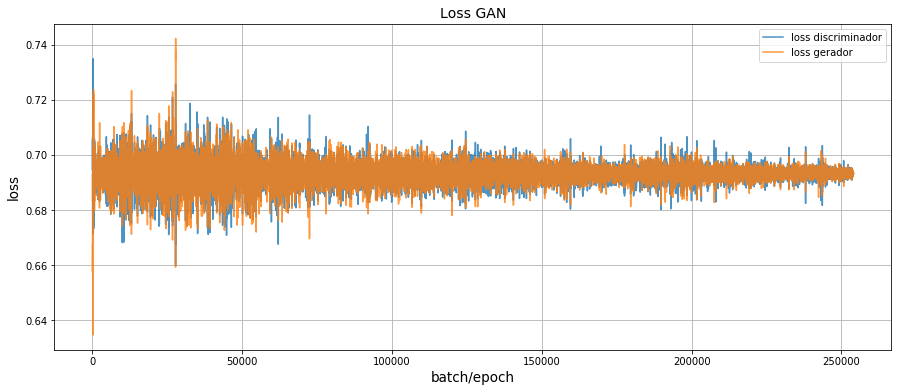

In [27]:
g_loss, d_loss = gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador", alpha=.8)
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador", alpha=.8)
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

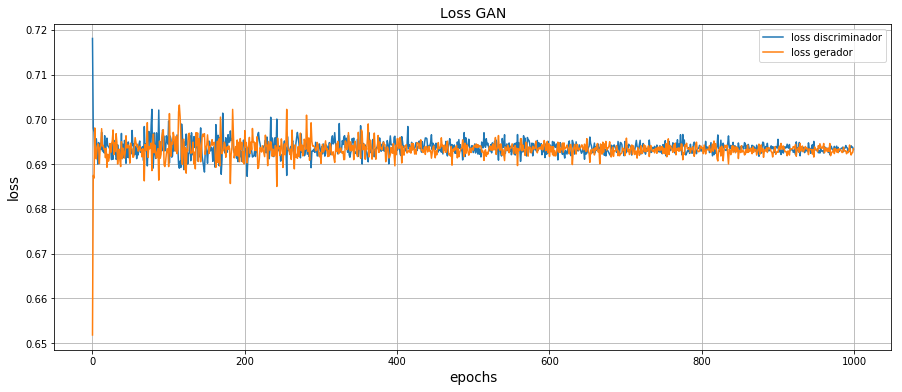

In [28]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("epochs", fontsize=13.5)
plt.plot(range(len(gan.d_lpe)), np.array(gan.d_lpe), label="loss discriminador")
plt.plot(range(len(gan.g_lpe)), np.array(gan.g_lpe), label="loss gerador")
#plt.plot(range(len(gan.g_lpe)), 0.5*np.ones(len(gan.g_lpe)),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.legend();

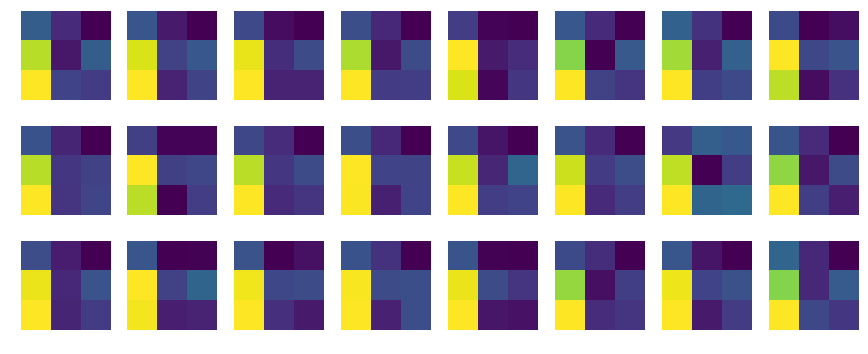

In [30]:
num_imgs = 24 #número de imágenes a mostrar aleatoriamente
img_pre = gan.G.predict(np.random.normal(0,1,(num_imgs,100)))
fig = plt.figure(figsize=(15,6))
for i in range(num_imgs):
    ax=fig.add_subplot(3,8,i+1)
    img = img_pre[i]
    plt.imshow(img.reshape((3,3)))
    ax.axis("off")
plt.show()

In [41]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,100)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)

imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


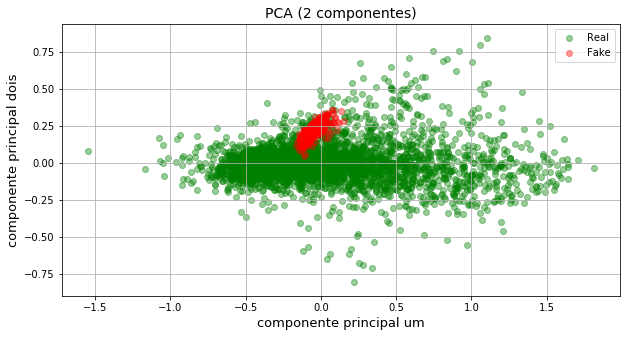

In [42]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();